## Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores.

To build a forecasting model to forecast the daily sales for the next six weeks of nine key stores(1,3,8,9,13,25,29,31 and 46) across Europe.

### Table of Contents
- EDA
- Data Visualization
- Utility Functions
- Model Building
    - Store 1
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 3
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 8
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 9
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 3
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 25
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 29
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 31
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
    - Store 46
        - ARIMA MODEL, SARIMA MODEL, SARIMAX MODEL, VARMAX MODEL
- Model Evaluation
    - Store 1
    - Store 3
    - Store 8
    - Store 9
    - Store 25
    - Store 29
    - Store 31
    - Store 46

In [1]:
#import required libraries
import calendar

import pandas as pd
import numpy as np

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Read the dataset
sales_data = pd.read_csv("./train.csv")
store_data = pd.read_csv("./store.csv")

In [3]:
sales_data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [4]:
store_data.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

### EDA

In [5]:
#Print the Shape of the Sales and Store date.
print(f"Shape of the Sales Data {sales_data.shape}")
print(f"Shape of the Store Data {store_data.shape}")

Shape of the Sales Data (1017209, 9)
Shape of the Store Data (1115, 10)


In [6]:
#Sales data columns information
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
#Store data columns information
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
#Merge the two dataset
data = pd.merge(sales_data,store_data,on='Store')

data.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [9]:
#Filter records of the key stores across Europe.  1,3,8,9,13,25,29,31 and 46.
keyStores = [1,3,8,9,13,25,29,31,46]
keyStoresData = data[data['Store'].isin(keyStores)]

#Print the Shape of the dataset for filtered key stores across Europe.
print(f"Shape of the Sales Data for key stores across Europe {keyStoresData.shape}")

Shape of the Sales Data for key stores across Europe (8110, 18)


In [10]:
#DataType and Non-Null value count of dataframe.
keyStoresData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8110 entries, 0 to 42043
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      8110 non-null   int64  
 1   DayOfWeek                  8110 non-null   int64  
 2   Date                       8110 non-null   object 
 3   Sales                      8110 non-null   int64  
 4   Customers                  8110 non-null   int64  
 5   Open                       8110 non-null   int64  
 6   Promo                      8110 non-null   int64  
 7   StateHoliday               8110 non-null   object 
 8   SchoolHoliday              8110 non-null   int64  
 9   StoreType                  8110 non-null   object 
 10  Assortment                 8110 non-null   object 
 11  CompetitionDistance        8110 non-null   float64
 12  CompetitionOpenSinceMonth  6410 non-null   float64
 13  CompetitionOpenSinceYear   6410 non-null   floa

In [11]:
#Change the Data type of a column.
keyStoresData['Date'] = pd.to_datetime(keyStoresData['Date'])

In [12]:
#Derived Metrics
keyStoresData['Year'] = keyStoresData.Date.dt.year
keyStoresData['Month'] = keyStoresData.Date.dt.month
keyStoresData['Day'] = keyStoresData.Date.dt.day
keyStoresData['WeekOfYear'] = keyStoresData.Date.dt.weekofyear

#CompetitionOpen represent number of month the comprtition is open
keyStoresData['CompetitionOpen'] = 12 * (keyStoresData.Year - keyStoresData.CompetitionOpenSinceYear) + (keyStoresData.Month - keyStoresData.CompetitionOpenSinceMonth)

#PromoOpen represent number of months the promo is open
keyStoresData['PromoOpen'] = 12 * (keyStoresData.Year - keyStoresData.Promo2SinceYear) + (keyStoresData.WeekOfYear - keyStoresData.Promo2SinceWeek) / 4.0

keyStoresData['CompetitionOpen'] = keyStoresData.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
keyStoresData['PromoOpen'] = keyStoresData.PromoOpen.apply(lambda x: x if x > 0 else 0)

#Drop redundant columns
keyStoresData.drop(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceYear','Promo2SinceWeek'],axis=1,inplace=True)

#### Sanity Checks

In [13]:
#Check is there any duplicate row present.
keyStoresData[keyStoresData.duplicated()]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Year, Month, Day, WeekOfYear, CompetitionOpen, PromoOpen]
Index: []

In [14]:
#Check is there any record where Customer is 0 and there is a sale of drugs.
keyStoresData[(keyStoresData.Customers == 0) & (keyStoresData.Sales > 0)]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Year, Month, Day, WeekOfYear, CompetitionOpen, PromoOpen]
Index: []

In [15]:
#Check is there any record where shope is closed and there is a sale of drugs.
keyStoresData[(keyStoresData.Open == 0) & (keyStoresData.Sales > 0)]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Year, Month, Day, WeekOfYear, CompetitionOpen, PromoOpen]
Index: []

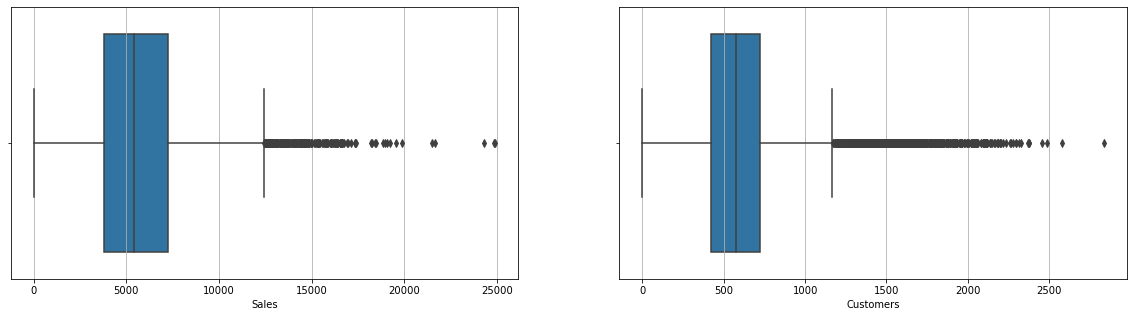

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


count         mean          std  min   1%   5%      25%     50%  \
Sales      8110.0  5394.031566  3455.976814  0.0  0.0  0.0  3792.25  5406.0   
Customers  8110.0   590.330210   421.269874  0.0  0.0  0.0   421.00   573.0   

              75%       95%       99%      max  
Sales      7252.5  11377.70  14810.28  24882.0  
Customers   720.0   1521.55   1929.91   2835.0

In [16]:
#Create a function to visualize the outliers for each of the key stores data

'''Function to check outliers for the Sales and Customers column in dataframe'''
def outlierCheck(dataframe):
    plt.figure(figsize=(20,5)) 
    plt.subplot(1, 2, 1)
    plt.grid()
    sns.boxplot(x=dataframe['Sales'], data=dataframe)
    plt.subplot(1, 2, 2)
    plt.grid()
    sns.boxplot(x=dataframe['Customers'], data=dataframe)
    plt.show()
    print(" * "*40)
    display(dataframe[['Sales','Customers']].describe([0.01,0.05,0.25,0.50,0.75,0.95,0.99]).T)

    
'''Function to remove outliers for a selected columns.
   Removes data above 99 percentile fr the respective columns.'''
def outlierRemove(dataframe,columns):
    for col in columns: 
        percentile = np.percentile(dataframe[col],[99])
        dataframe = dataframe[(dataframe[col] < percentile[0])]
    return dataframe

outlierCheck(keyStoresData)

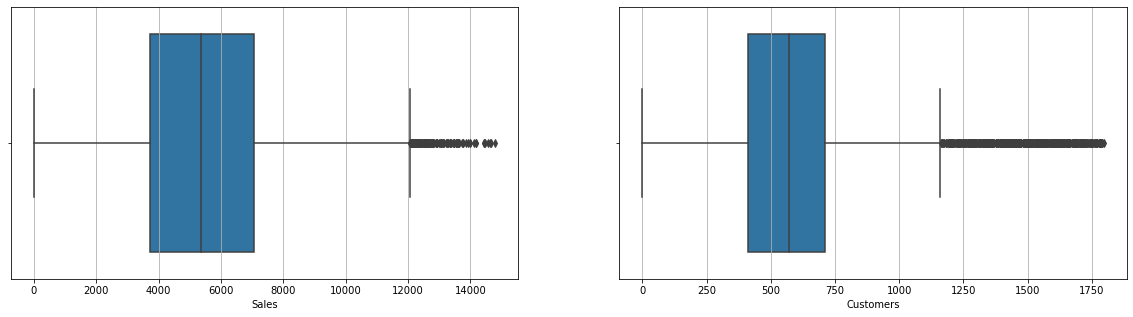

 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 


count         mean          std  min   1%   5%     25%     50%  \
Sales      7947.0  5192.827356  3174.285968  0.0  0.0  0.0  3740.0  5356.0   
Customers  7947.0   562.260853   375.099283  0.0  0.0  0.0   412.0   569.0   

              75%      95%      99%      max  
Sales      7069.5  10498.1  12542.4  14784.0  
Customers   710.0   1377.0   1692.0   1796.0

In [17]:
#Remove the outliers
keyStoresData = outlierRemove(keyStoresData,['Sales','Customers'])

#Visualize after removing outliers
outlierCheck(keyStoresData)

### Data Visualization

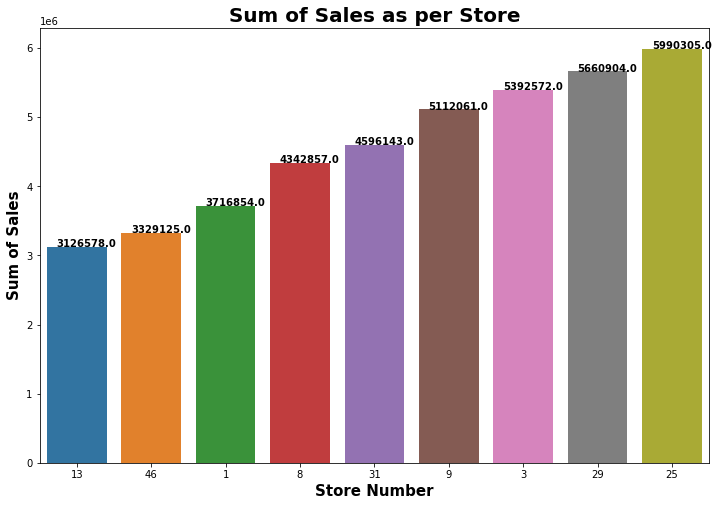

In [18]:
#Sum of Sales as per the Store.
salessum = pd.DataFrame(keyStoresData.groupby('Store')['Sales'].sum().sort_values()).reset_index()
plt.figure(figsize=(12, 8))
ax=sns.barplot(x='Store',y='Sales', data=salessum,order=keyStoresData.groupby('Store')['Sales'].sum().sort_values().index)
plt.xlabel('Store Number',fontweight ='bold',fontsize = 15)
plt.ylabel('Sum of Sales',fontweight ='bold',fontsize = 15)
plt.title("Sum of Sales as per Store",fontweight ='bold',fontsize = 20)
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

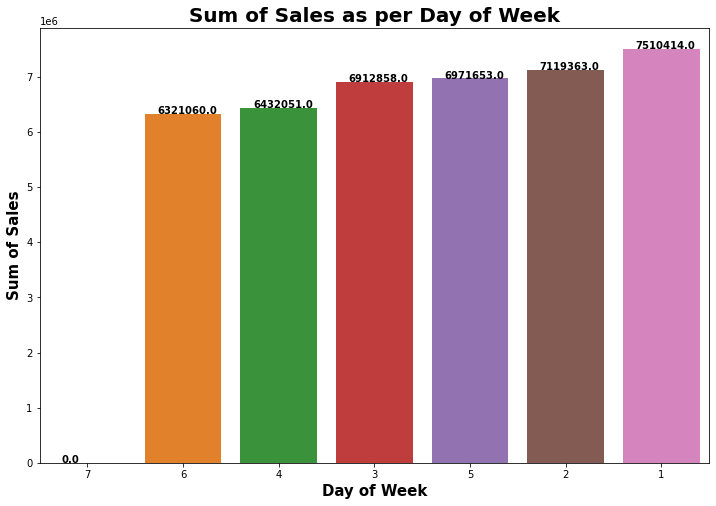

In [19]:
#Sum of Sales as per the Day of Week.
salessum = pd.DataFrame(keyStoresData.groupby('DayOfWeek')['Sales'].sum().sort_values()).reset_index()
plt.figure(figsize=(12, 8))
ax=sns.barplot(x='DayOfWeek',y='Sales', data=salessum,order=keyStoresData.groupby('DayOfWeek')['Sales'].sum().sort_values().index)
plt.xlabel('Day of Week',fontweight ='bold',fontsize = 15)
plt.ylabel('Sum of Sales',fontweight ='bold',fontsize = 15)
plt.title("Sum of Sales as per Day of Week",fontweight ='bold',fontsize = 20)
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

Observations:
- All the 9 key store are closed on 7th Day of week i.e Sunday
- Monday (1st Day of Week) has the highest number of sales.

In [20]:
#Remove all the records where Day of Week is 7th i.e(Sunday) and when stores are closed because these two days no sales are recorded.
keyStoresData = keyStoresData[~((keyStoresData['DayOfWeek'] == 7) |(keyStoresData['Open']==0))]

#Drop Open Column
keyStoresData.drop(['Open'],axis=1,inplace=True)

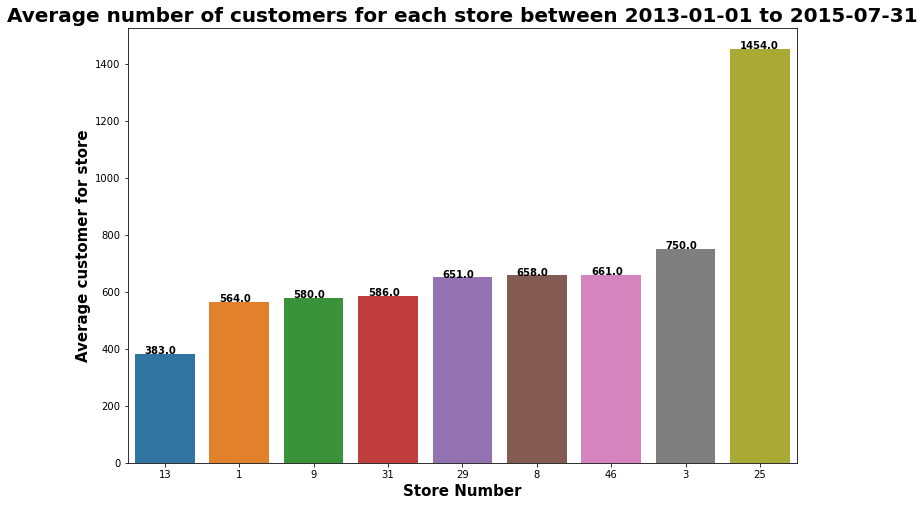

In [21]:
#Average number of customers for each store between "2013-01-01" to "2015-07-31"
custavg = pd.DataFrame(round(keyStoresData.groupby('Store')['Customers'].mean(),0).sort_values()).reset_index()
plt.figure(figsize=(12, 8))
ax=sns.barplot(x='Store',y='Customers', data=custavg,order=round(keyStoresData.groupby('Store')['Customers'].mean(),0).sort_values().index)
plt.xlabel('Store Number',fontweight ='bold',fontsize = 15)
plt.ylabel('Average customer for store',fontweight ='bold',fontsize = 15)
plt.title("Average number of customers for each store between 2013-01-01 to 2015-07-31",fontweight ='bold',fontsize = 20)
for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.13, p.get_height()),fontweight ='bold')

Observations:
- Average Customer for Store 25 is way higher. Need to check for outliers

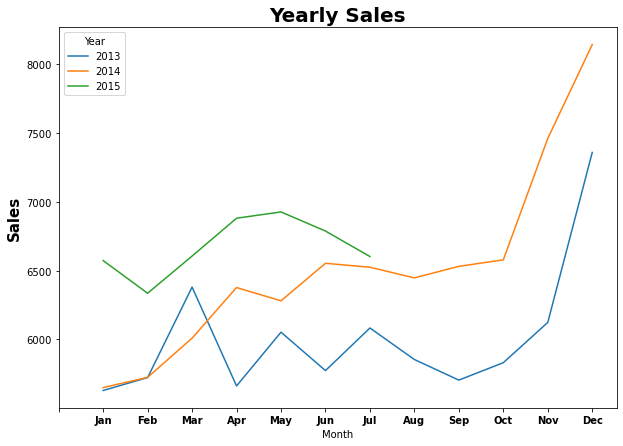

In [22]:
# Yearly Sales
selected_sales = keyStoresData.groupby(['Year', 'Month'])['Sales'].mean()
fig, (axis1) = plt.subplots(1,1, figsize=(10,7))
selected_sales.unstack().T.plot(ax=axis1)
tmp = axis1.set_title("Yearly Sales",fontweight ='bold',fontsize = 20)
tmp = axis1.set_ylabel("Sales",fontweight ='bold',fontsize = 15)
tmp = axis1.set_xticks(range(0,13))
tmp = axis1.set_xticklabels(calendar.month_abbr,fontweight ='bold',fontsize = 10)

#### Observations:
- Average monthly sales at the end of the year( between October - December) drastically increases.

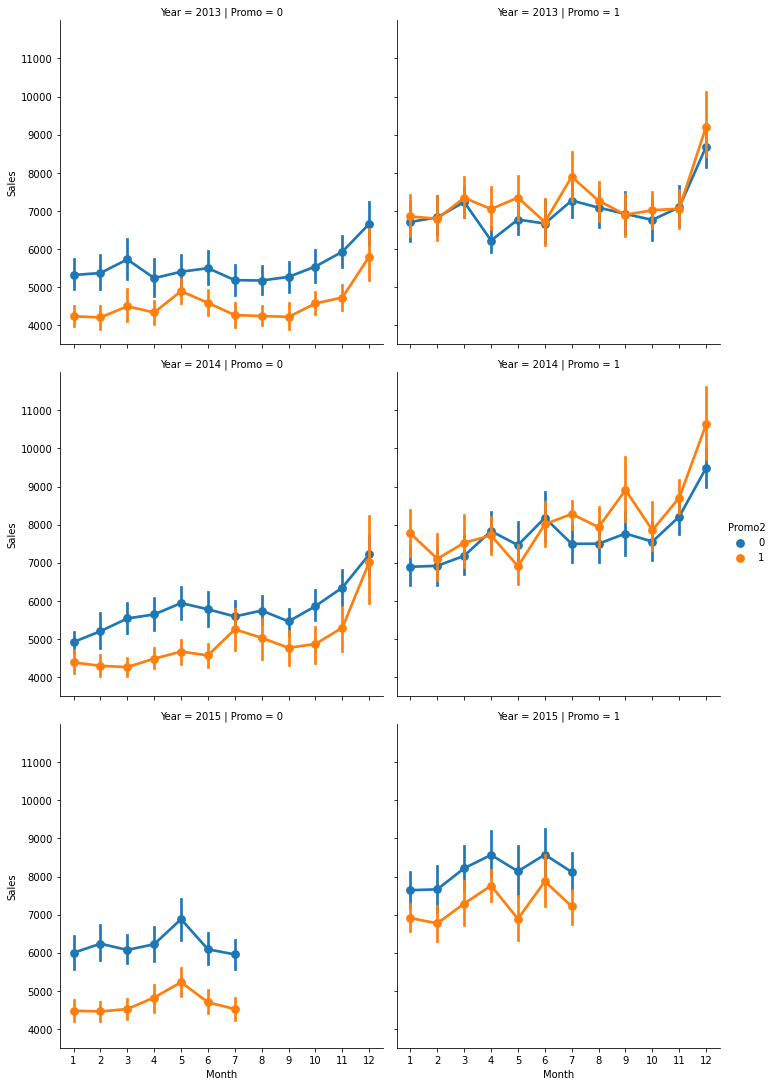

In [23]:
# Sales trend over the months
sns.factorplot(data = keyStoresData, x ="Month", y = "Sales", col = 'Promo',hue = 'Promo2',row = "Year")

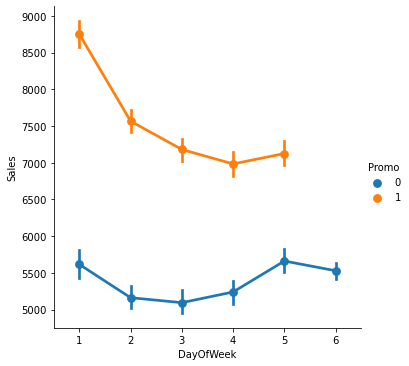

In [24]:
#Sales as the per the Promo
sns.factorplot(data = keyStoresData, x = "DayOfWeek", y = "Sales", hue = "Promo")
plt.show()

#### Observation:
- There is no promotion on Saturday(Weekend).
- Sales is increases when there is a Promo.

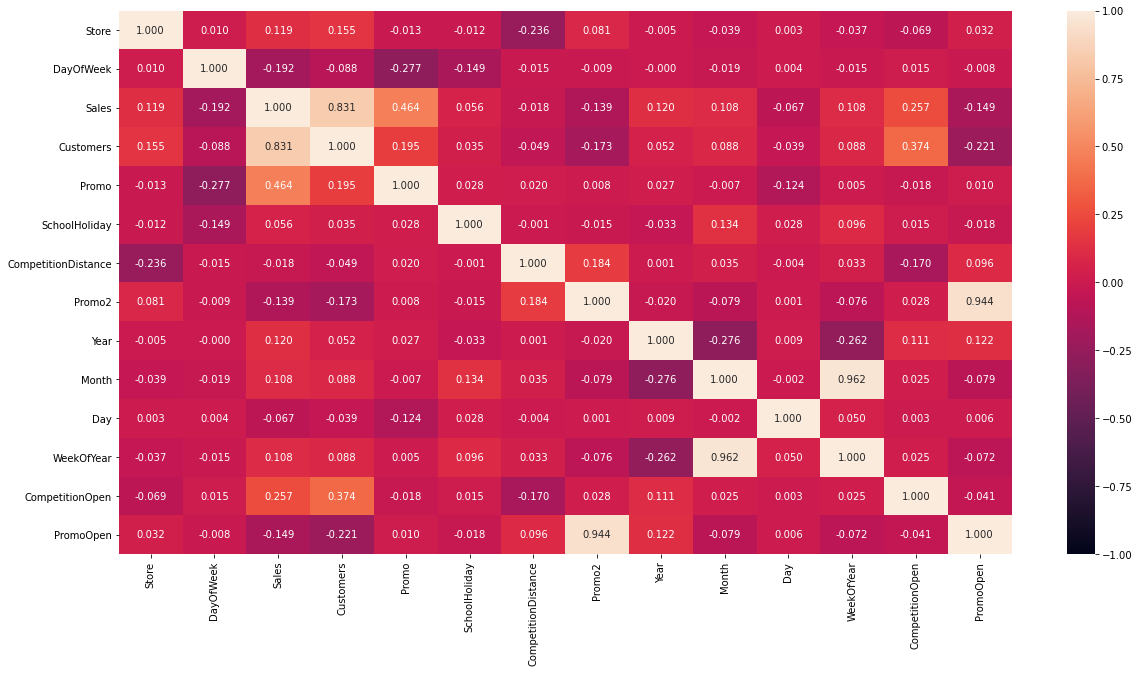

In [25]:
#Heat Map to represent corelation between variables.
plt.figure(figsize = (20, 10))
sns.heatmap(keyStoresData.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')
plt.show()

#### Observation:
- Customer and Sales shows a high correlation

In [26]:
#Store Type for all the 9 key store
keyStoresData.groupby('StoreType')['Store'].unique()

StoreType
a       [3, 8, 9]
c     [1, 25, 46]
d    [13, 29, 31]
Name: Store, dtype: object

In [27]:
#Assortment Type for all the 9 key store
#Assortment - describes an assortment level: a = basic, b = extra, c = extended
keyStoresData.groupby('Assortment')['Store'].unique()

Assortment
a    [1, 3, 8, 13, 25, 46]
c              [9, 29, 31]
Name: Store, dtype: object

Store 1


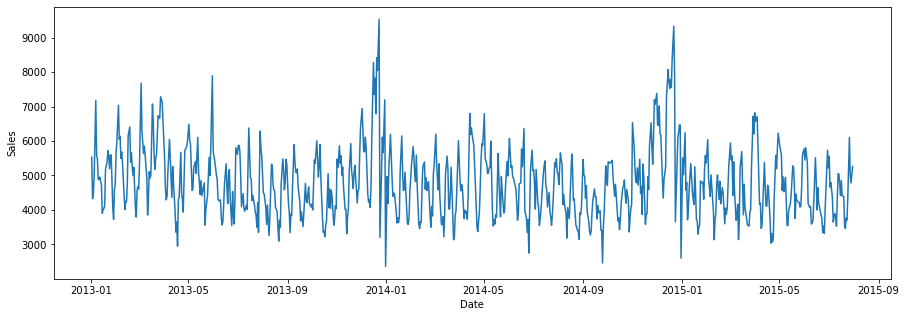

*****************************************************************************************************************************
Store 3


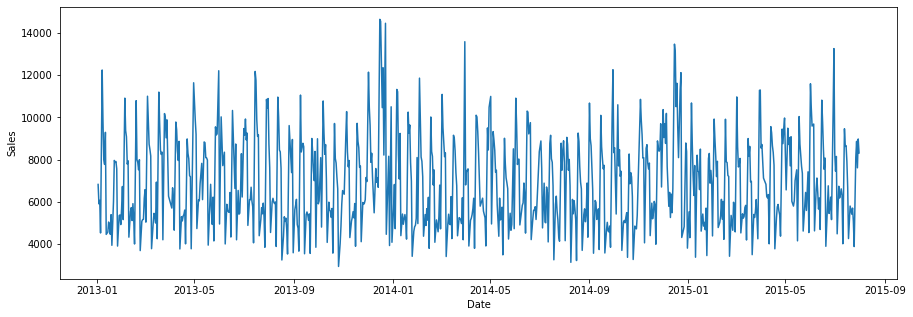

*****************************************************************************************************************************
Store 8


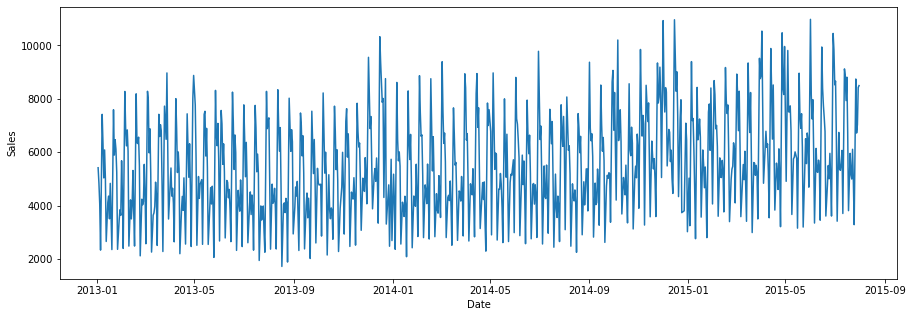

*****************************************************************************************************************************
Store 9


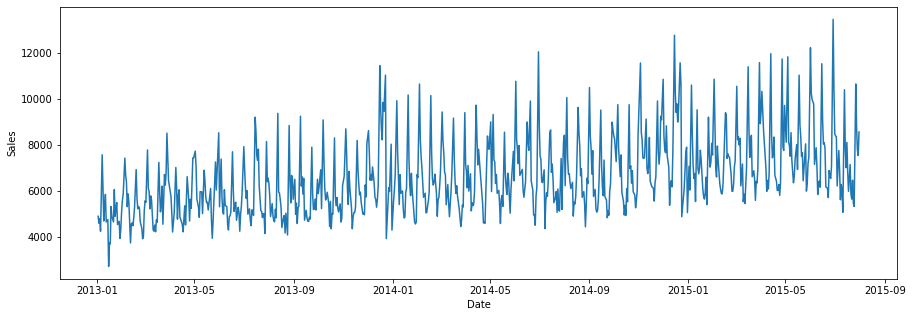

*****************************************************************************************************************************
Store 13


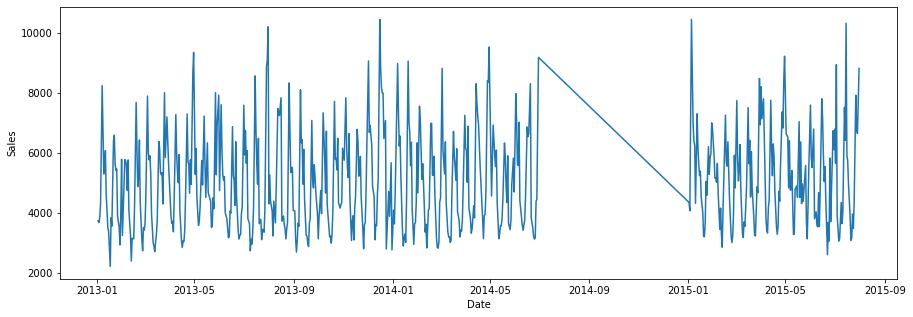

*****************************************************************************************************************************
Store 25


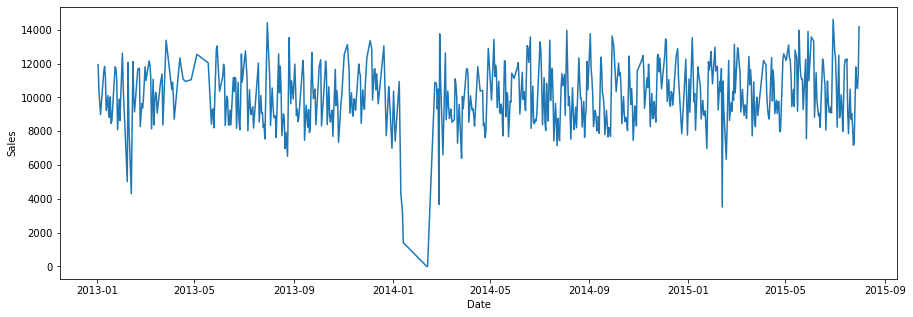

*****************************************************************************************************************************
Store 29


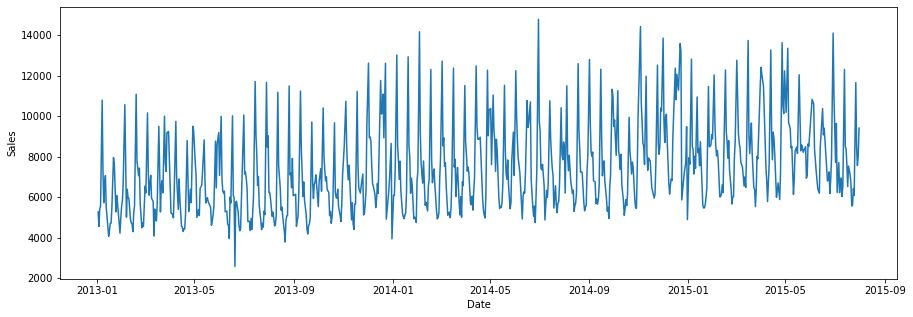

*****************************************************************************************************************************
Store 31


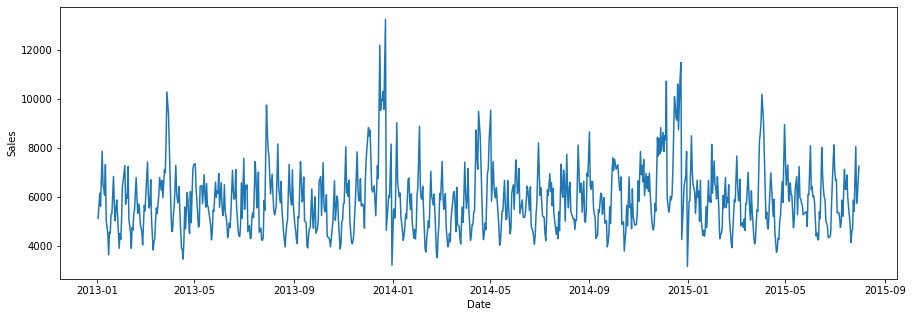

*****************************************************************************************************************************
Store 46


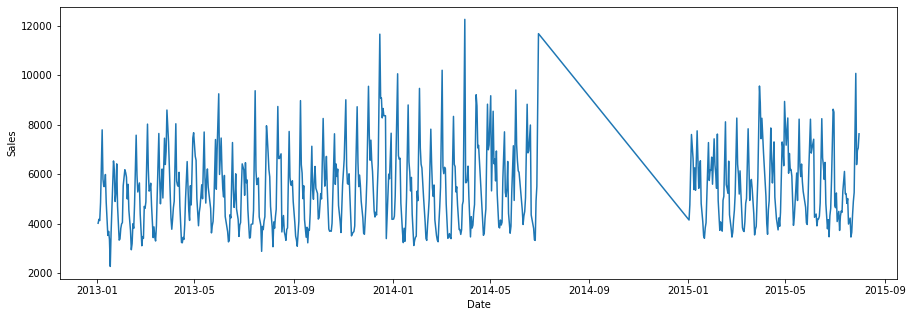

*****************************************************************************************************************************


In [28]:
#Visualize the Sales record for each store.

def plot_storeSales(storeNumber):
    print(f"Store {storeNumber}")
    dataframe = keyStoresData[keyStoresData['Store'] == storeNumber]
    dataframe = dataframe[['Sales','Date']]
    plt.figure(figsize=(15, 5))
    sns.lineplot(x='Date',y='Sales',data=dataframe)
    plt.show()
    print("*"*125)
                          
keyStores = [1,3,8,9,13,25,29,31,46]
for i in keyStores:
    plot_storeSales(i)

### Utility Functions/ Preprocessing Steps before Model Building

In [29]:
#Dummy variable creation.
dummyvar = pd.get_dummies(keyStoresData['DayOfWeek'].astype('object'),drop_first=True)
dummyvar.rename(columns={2:'DayOfWeek_2',3:'DayOfWeek_3',4:'DayOfWeek_4',
                         5:'DayOfWeek_5',6:'DayOfWeek_6'},inplace=True)

#concat the created dummy variables with the dataset.
keyStoresData = pd.concat([keyStoresData,dummyvar],axis=1)

#Drop the variables
keyStoresData.drop(['DayOfWeek','Assortment','PromoInterval','StateHoliday'],axis=1,inplace=True)

In [30]:
#Create seprate dataframe for each of the 9 key store across Europe i.e. 1,3,8,9,13,25,29,31 and 46.

''' Function to create and return seprate dataframe based on store number'''
def storesDataframe(storeNumber):
    dataframe = keyStoresData[keyStoresData['Store'] == storeNumber]
    return dataframe

keyStores = [1,3,8,9,13,25,29,31,46]
for i in keyStores:
    globals()["store" + str(i)] = storesDataframe(i)

In [31]:
#Function to create a test and trendain dataset.
def test_train_split(dataframe):
    train_dataset = dataframe[:dataframe.shape[0] - 36]
    test_datset = dataframe[dataframe.shape[0] - 36:]
    return train_dataset,test_datset


#Create a function to standardise the Sales and Customers column in a dataframe.
def standardiseColumns(dataframe):
    scaler = MinMaxScaler(feature_range=(0.5, 1.5))
    outputdf = scaler.fit_transform(dataframe)
    return outputdf,scaler


#Create a function to determine if the data is stationary
''' 
   Using Augmented Dickey-Fuller (ADF) test
   - Null Hypothesis (H0): The series is not stationary. p-value >  0.5
   - Alternate Hypothesis(H1): The series is stationary. p-value <= 0.5
'''
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6):
        return str(val).ljust(length)
    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


#Create a function to test the cointegration.        
"""
    Johansen cointegration test of the cointegration rank of a VECM
    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

    
#Plot the ACF and PACF    
def plot_acf_pacf(column,index,lagvalue):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(2,2,1)
    fig = sm.graphics.tsa.plot_acf(column.iloc[index:],lags=lagvalue,ax=ax1)
    ax2 = fig.add_subplot(2,2,2)
    fig = sm.graphics.tsa.plot_pacf(column.iloc[index:],lags=lagvalue,ax=ax2)
    ax3 = fig.add_subplot(2,1,2)
    fig = autocorrelation_plot(column,ax=ax3)

    
#Plot the decomposition which shows the trend, Seasonality and residuals in sales for store.
def plot_timeseries(sales):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    plt.suptitle('Decomposition for Store')
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

In [32]:
#create a function to predict the sales for next 6 week and plot the prediction graph.
def predict_sales(model,storeTrainDataframe,storeTestDataframe,exogeneousVariable = None):
    prediction = model.predict(start=storeTrainDataframe.shape[0],end=(storeTrainDataframe.shape[0] + storeTestDataframe.shape[0] - 1),exog =exogeneousVariable,dynamic=True)
    prediction.index = storeTestDataframe.index   
    return prediction

def plot_predictiongrah(traindatframe,testdataframe,predictiondataframe,modelname):
    plt.figure(figsize=(15,5))
    plt.plot(traindatframe['Sales'], label='Train')
    plt.plot(testdataframe['Sales'], label='Test')
    plt.plot(predictiondataframe['Sales'], label= modelname + ' Model Prediction')
    plt.legend(loc='best')
    plt.title(modelname+' Model')
    plt.show()


#Create a function to calculate RMSE and MAPE
def modelEvalution(testval,predictedval,model,storeDataframeResults):    
    rmse = np.sqrt(mean_squared_error(testval, predictedval)).round(2)
    mape = np.round(np.mean(np.abs(testval-predictedval)/testval)*100,2)
    
    tempResults = pd.DataFrame({'Method':[model], 'RMSE': [rmse],'MAPE': [mape] })
    
    if (storeDataframeResults.shape[0] > 0) :
        if model in set(storeDataframeResults['Method']):
            return storeDataframeResults
        results = pd.concat([storeDataframeResults, tempResults])
        results = results[['Method', 'RMSE', 'MAPE']]
        return results
    else:
        results = tempResults[['Method', 'RMSE', 'MAPE']]
        return results

### Model Building

#### Store 1

In [33]:
store1.set_index('Date',drop=True,inplace=True)
store1 = store1.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store1_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store1[col],scaler1 = standardiseColumns(store1[col])

store1.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02      1  0.942088   0.944712    0.5            1.5         c   
2013-01-03      1  0.774212   0.836538    0.5            1.5         c   
2013-01-04      1  0.796400   0.885817    0.5            1.5         c   
2013-01-05      1  0.867709   0.905048    0.5            1.5         c   
2013-01-07      1  1.171783   1.085337    1.5            1.5         c   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               1270.0       0  2013      1    2           1   
2013-01-03               1270.0       0  2013      1    3           1   
2013-01-04               1270.0       0  2013      1    4           1   
2013-01-05               1270.0       0  2013      1    5           1   
2013-01-07               1270.0       0  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5        0.0          0.5          1.5          0.5   
2013-01-03              0.5        0.0          0.5          0.5          1.5   
2013-01-04              0.5        0.0          0.5          0.5          0.5   
2013-01-05              0.5        0.0          0.5          0.5          0.5   
2013-01-07              0.5        0.0          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 1


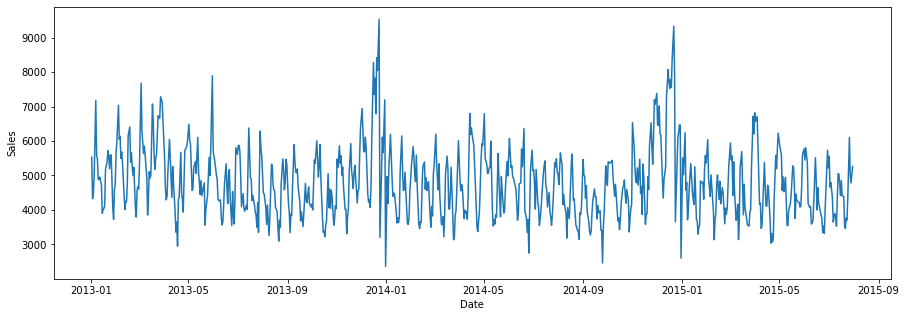

*****************************************************************************************************************************


In [34]:
plot_storeSales(1)

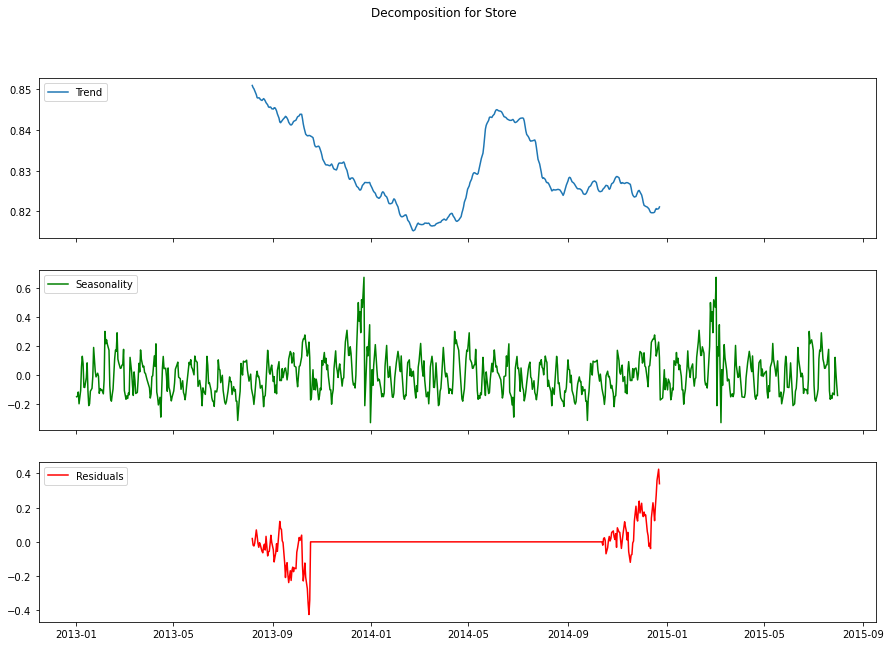

In [35]:
#Decomposition plot for the Store 1 timeseries.
plot_timeseries(store1['Sales'])

In [36]:
#Check stationarity of the sales and Customers for store 1
for column in col:
    adfuller_test(store1[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3996
 No. Lags Chosen       = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3204
 No. Lags Chosen       = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Leve

In [37]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store1_differenced = store1[col].diff().dropna()

In [38]:
#Check stationarity of the sales and Customers for store 1
for column in col:
    adfuller_test(store1_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4935
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8524
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [39]:
#Check cointegration for store 1
joh_model1 = coint_johansen(store1_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    631.706871  989.654872
1    357.948001  357.948001 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [40]:
#Train-Test split
store1_train,store1_test = test_train_split(store1)

##### ARIMA MODEL

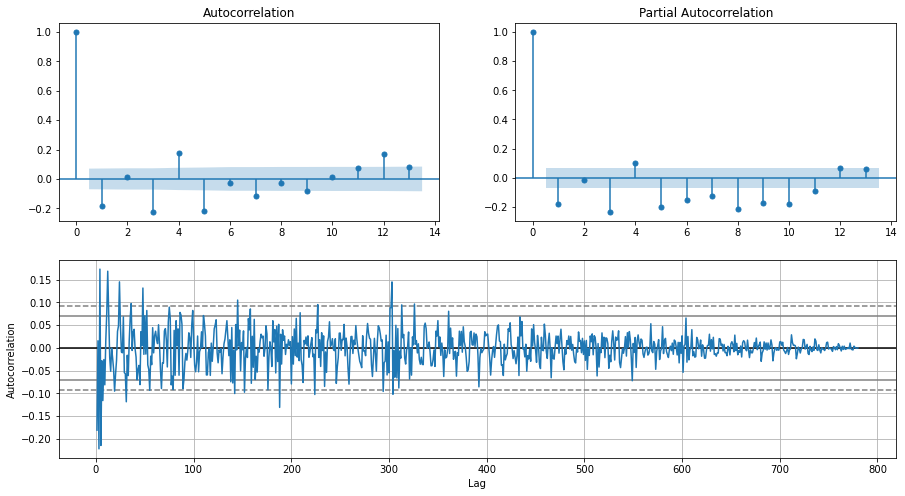

In [41]:
#Plot the ACF and PACF
plot_acf_pacf(store1_differenced['Sales'],0,13)

In [42]:
#Create a copy of test and train dataframe for this model.
store1_train_arima = store1_train.copy()
store1_test_arima = store1_test.copy()

#Build the ARIMA Model
store1_model_arima = ARIMA(store1_train_arima['Sales'], order=(7,1,1))
arima_model_store1 = store1_model_arima.fit()

# summary of fit model
print(arima_model_store1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  745
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 661.654
Date:                Wed, 13 Apr 2022   AIC                          -1305.307
Time:                        10:18:00   BIC                          -1263.799
Sample:                             0   HQIC                         -1289.307
                                - 745                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6025      0.034     17.859      0.000       0.536       0.669
ar.L2          0.0222      0.043      0.513      0.608      -0.063       0.107
ar.L3         -0.1815      0.049     -3.732      0.0

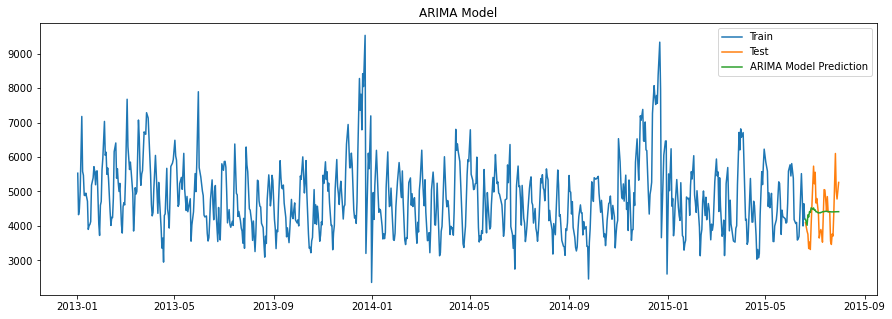

In [43]:
store1_arimamodel_pred = store1_test_arima.copy()

#Predict the sales for 6 weeks
store1_arimamodel_pred['Sales'] = predict_sales(arima_model_store1,store1_train_arima,store1_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store1_train_arima[col] = scaler1.inverse_transform(store1[col][:store1_train.shape[0]])
store1_test_arima[col] = scaler1.inverse_transform(store1[col][store1_train.shape[0]:])
store1_arimamodel_pred[col] = scaler1.inverse_transform(store1_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store1_train_arima,store1_test_arima,store1_arimamodel_pred,'ARIMA')

In [44]:
#ARIMA Model Evaluation.
store1_result = modelEvalution(store1_test_arima['Sales'],store1_arimamodel_pred['Sales'],'ARIMA Model',store1_result)
store1_result

Method    RMSE   MAPE
0  ARIMA Model  700.37  13.78

##### SARIMA MODEL

In [45]:
#Create a copy of test and train dataframe for this model.
store1_train_sarima = store1_train.copy()
store1_test_sarima = store1_test.copy()

#SARIMA Model Building
store1_model_sarima = SARIMAX(store1_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store1 = store1_model_sarima.fit()

# summary of fit model
print(sarima_model_store1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  745
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 647.408
Date:                            Wed, 13 Apr 2022   AIC                          -1260.815
Time:                                    10:21:44   BIC                          -1182.687
Sample:                                         0   HQIC                         -1230.677
                                            - 745                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6178      0.030     20.392      0.000       0.558       0.677
ar.L2          0.0608      0.041   

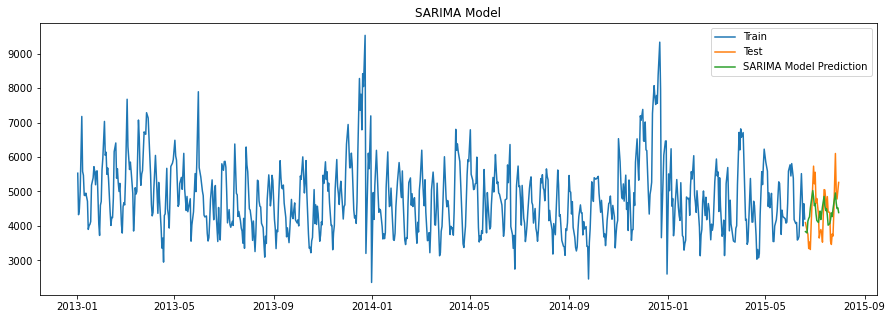

In [46]:
store1_sarimamodel_pred = store1_test_sarima.copy()

#Predict the sales for 6 weeks
store1_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store1,store1_train_sarima,store1_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store1_train_sarima[col] = scaler1.inverse_transform(store1[col][:store1_train.shape[0]])
store1_test_sarima[col] = scaler1.inverse_transform(store1[col][store1_train.shape[0]:])
store1_sarimamodel_pred[col] = scaler1.inverse_transform(store1_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store1_train_sarima,store1_test_sarima,store1_sarimamodel_pred,'SARIMA')

In [47]:
#SARIMA Model Evaluation.
store1_result = modelEvalution(store1_test_sarima['Sales'],store1_sarimamodel_pred['Sales'],'SARIMA Model',store1_result)
store1_result

Method    RMSE   MAPE
0   ARIMA Model  700.37  13.78
0  SARIMA Model  619.44  12.95

##### SARIMAX MODEL

In [48]:
#Create a copy of test and train dataframe for this model.
store1_train_sarimax = store1_train.copy()
store1_test_sarimax = store1_test.copy()

#SARIMAX Model Building.
exog = store1_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store1_model_sarimax = SARIMAX(store1_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store1 = store1_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  745
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 761.427
Date:                            Wed, 13 Apr 2022   AIC                          -1472.855
Time:                                    10:26:34   BIC                          -1357.960
Sample:                                         0   HQIC                         -1428.533
                                            - 745                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.1625      0.009     17.835      0.000       0.145       0.180
SchoolHoliday      -

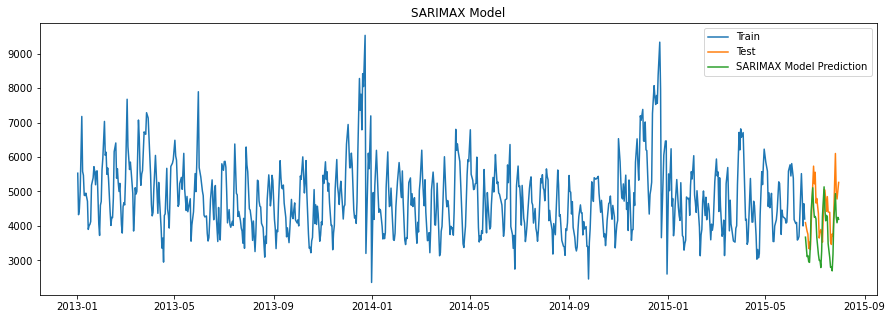

In [49]:
#Create a copy of test dataframe
store1_sarimaxmodel_pred = store1_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store1_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store1_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store1,store1_train_sarimax,store1_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store1_train_sarimax[col] = scaler1.inverse_transform(store1[col][:store1_train.shape[0]])
store1_test_sarimax[col] = scaler1.inverse_transform(store1[col][store1_train.shape[0]:])
store1_sarimaxmodel_pred[col] = scaler1.inverse_transform(store1_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store1_train_sarimax,store1_test_sarimax,store1_sarimaxmodel_pred,'SARIMAX')

In [50]:
#SARIMAX Model Evaluation.
store1_result = modelEvalution(store1_test_sarimax['Sales'],store1_sarimaxmodel_pred['Sales'],'SARIMAX Model',store1_result)
store1_result

Method    RMSE   MAPE
0    ARIMA Model  700.37  13.78
0   SARIMA Model  619.44  12.95
0  SARIMAX Model  783.07  16.07

##### VARMAX MODEL

In [51]:
#Create a copy of test and train dataframe for this model.
store1_train_varmax = store1_train.copy()
store1_test_varmax = store1_test.copy()

exog = store1_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store1_model_varmax = sm.tsa.VARMAX(store1_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store1 = store1_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store1.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  745
Model:                        VARMAX(1,1)   Log Likelihood                2307.872
Date:                    Wed, 13 Apr 2022   AIC                          -4561.743
Time:                            10:27:56   BIC                          -4437.182
Sample:                                 0   HQIC                         -4513.732
                                    - 745                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             1.49, 0.05   Jarque-Bera (JB):       678.04, 132.85
Prob(Q):                        0.22, 0.83   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.56, 1.14   Skew:                      0.01, -0.18
Prob(H) (two-sided):            0.00, 0.31   Kurtosis:                   7.67, 5.04


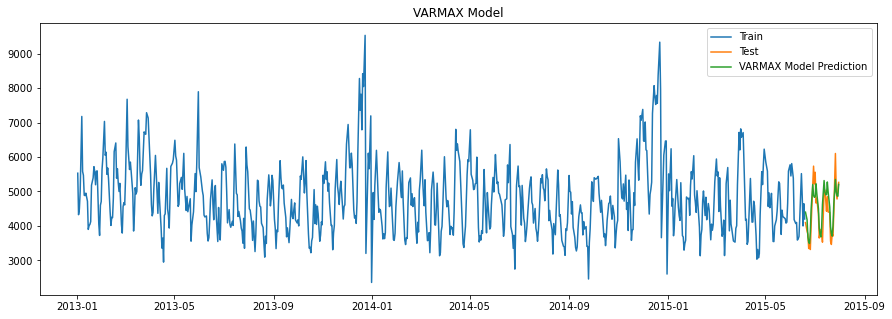

In [52]:
#Create a copy of test dataframe
store1_varmaxmodel_pred = store1_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store1_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store1_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store1,store1_train_varmax,store1_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store1_train_varmax[col] = scaler1.inverse_transform(store1[col][:store1_train.shape[0]])
store1_test_varmax[col] = scaler1.inverse_transform(store1[col][store1_train.shape[0]:])
store1_varmaxmodel_pred[col] = scaler1.inverse_transform(store1_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store1_train_varmax,store1_test_varmax,store1_varmaxmodel_pred,'VARMAX')

In [53]:
#VARMAX Model Evaluation.
store1_result = modelEvalution(store1_test_varmax['Sales'],store1_varmaxmodel_pred['Sales'],'VARMAX Model',store1_result)
store1_result

Method    RMSE   MAPE
0    ARIMA Model  700.37  13.78
0   SARIMA Model  619.44  12.95
0  SARIMAX Model  783.07  16.07
0   VARMAX Model  398.32   7.13

#### Store 3

In [54]:
store3.set_index('Date',drop=True,inplace=True)
store3 = store3.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store3_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','CompetitionOpen','PromoOpen',
       'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store3[col],scaler3 = standardiseColumns(store3[col])

store3.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02      3  0.831910   0.853923    0.5            1.5         a   
2013-01-03      3  0.753266   0.783806    0.5            1.5         a   
2013-01-04      3  0.767526   0.757930    0.5            1.5         a   
2013-01-05      3  0.635514   0.620200    0.5            0.5         a   
2013-01-07      3  1.295064   1.082638    1.5            0.5         a   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02              14130.0       1  2013      1    2           1   
2013-01-03              14130.0       1  2013      1    3           1   
2013-01-04              14130.0       1  2013      1    4           1   
2013-01-05              14130.0       1  2013      1    5           1   
2013-01-07              14130.0       1  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5   0.500000          0.5          1.5          0.5   
2013-01-03              0.5   0.500000          0.5          0.5          1.5   
2013-01-04              0.5   0.500000          0.5          0.5          0.5   
2013-01-05              0.5   0.500000          0.5          0.5          0.5   
2013-01-07              0.5   0.507937          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 3


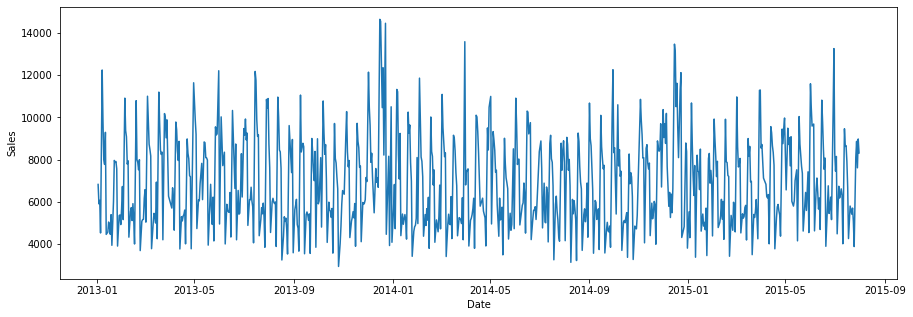

*****************************************************************************************************************************


In [55]:
plot_storeSales(3)

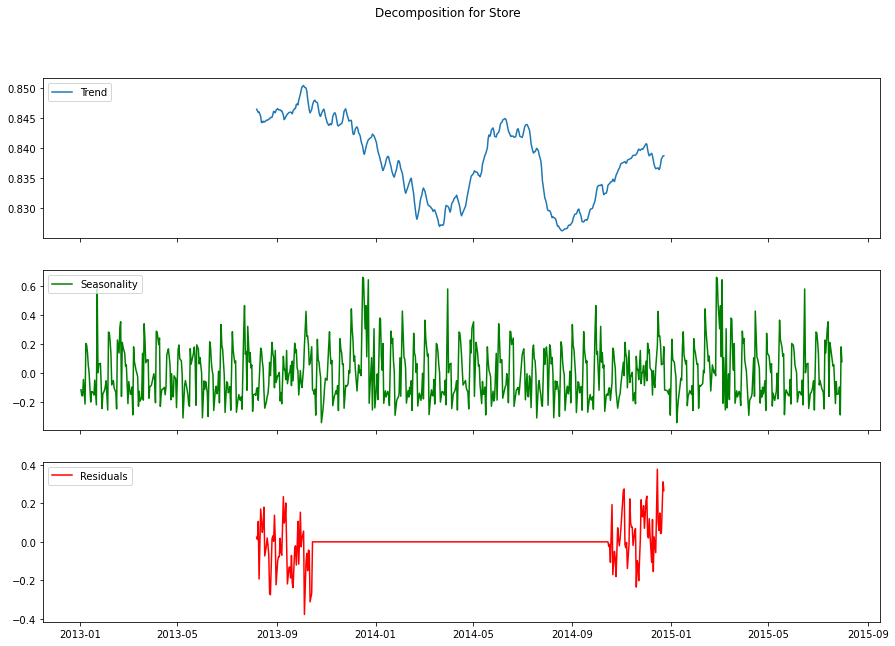

In [56]:
#Decomposition plot for the Store 3 timeseries.
plot_timeseries(store3['Sales'])

In [57]:
#Check stationarity of the sales and Customers for store 3
for column in col:
    adfuller_test(store3[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5057
 No. Lags Chosen       = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5186
 No. Lags Chosen       = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [58]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store3_differenced = store3[col].diff().dropna()

In [59]:
#Check stationarity of the sales and Customers for store 3
for column in col:
    adfuller_test(store3_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.0054
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.565
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [60]:
#Check cointegration for store 3
joh_model1 = coint_johansen(store3_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat   trace_stat
0    760.190803  1135.249399
1    375.058596   375.058596 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [61]:
#Train-Test split
store3_train,store3_test = test_train_split(store3)

##### ARIMA MODEL

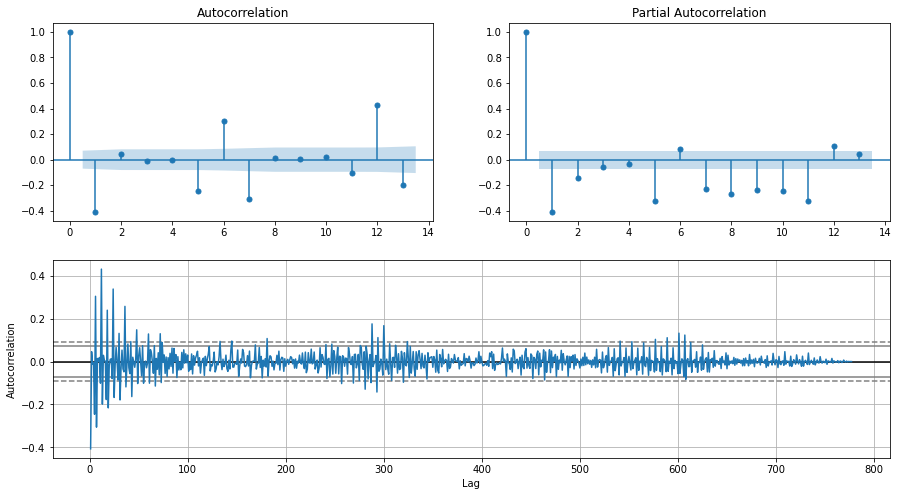

In [62]:
#Plot the ACF and PACF
plot_acf_pacf(store3_differenced['Sales'],0,13)

In [63]:
#Create a copy of test and train dataframe for this model.
store3_train_arima = store3_train.copy()
store3_test_arima = store3_test.copy()

#Build the ARIMA Model
store3_model_arima = ARIMA(store3_train_arima['Sales'], order=(7,1,1))
arima_model_store3 = store3_model_arima.fit()

# summary of fit model
print(arima_model_store3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  742
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 315.733
Date:                Wed, 13 Apr 2022   AIC                           -613.466
Time:                        10:31:45   BIC                           -571.994
Sample:                             0   HQIC                          -597.477
                                - 742                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2574      0.034      7.600      0.000       0.191       0.324
ar.L2          0.0620      0.042      1.464      0.143      -0.021       0.145
ar.L3         -0.0424      0.045     -0.934      0.3

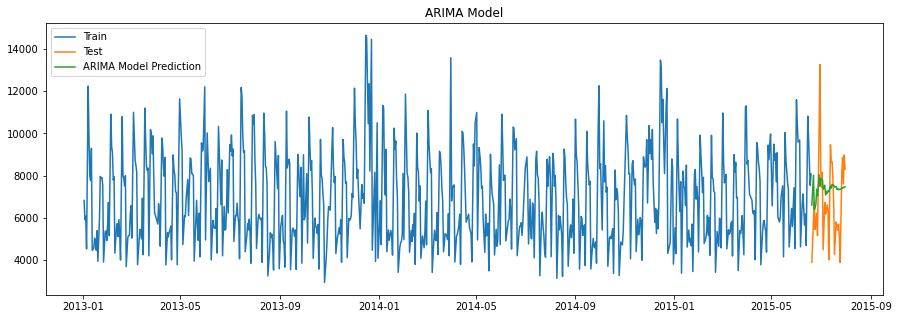

In [64]:
store3_arimamodel_pred = store3_test_arima.copy()

#Predict the sales for 6 weeks
store3_arimamodel_pred['Sales'] = predict_sales(arima_model_store3,store3_train_arima,store3_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store3_train_arima[col] = scaler3.inverse_transform(store3[col][:store3_train.shape[0]])
store3_test_arima[col] = scaler3.inverse_transform(store3[col][store3_train.shape[0]:])
store3_arimamodel_pred[col] = scaler3.inverse_transform(store3_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store3_train_arima,store3_test_arima,store3_arimamodel_pred,'ARIMA')

In [65]:
#ARIMA Model Evaluation.
store3_result = modelEvalution(store3_test_arima['Sales'],store3_arimamodel_pred['Sales'],'ARIMA Model',store3_result)
store3_result

Method     RMSE   MAPE
0  ARIMA Model  1919.21  26.21

##### SARIMA MODEL

In [66]:
#Create a copy of test and train dataframe for this model.
store3_train_sarima = store3_train.copy()
store3_test_sarima = store3_test.copy()

#SARIMA Model Building
store3_model_sarima = SARIMAX(store3_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store3 = store3_model_sarima.fit()

# summary of fit model
print(sarima_model_store3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  742
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 350.865
Date:                            Wed, 13 Apr 2022   AIC                           -667.729
Time:                                    10:34:42   BIC                           -589.671
Sample:                                         0   HQIC                          -637.612
                                            - 742                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2738      0.031      8.938      0.000       0.214       0.334
ar.L2          0.1577      0.038   

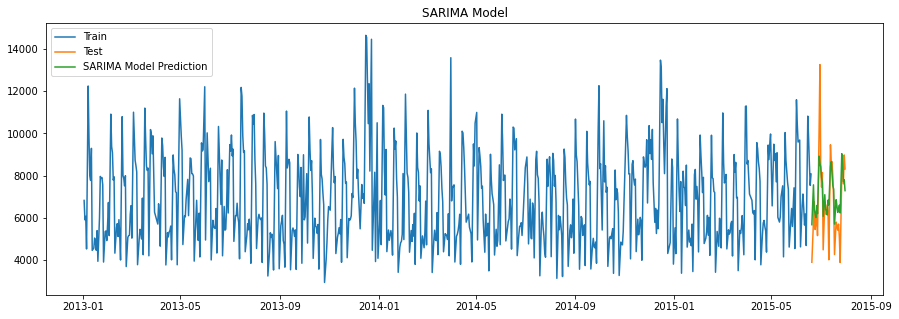

In [67]:
store3_sarimamodel_pred = store3_test_sarima.copy()

#Predict the sales for 6 weeks
store3_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store3,store3_train_sarima,store3_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store3_train_sarima[col] = scaler3.inverse_transform(store3[col][:store3_train.shape[0]])
store3_test_sarima[col] = scaler3.inverse_transform(store3[col][store3_train.shape[0]:])
store3_sarimamodel_pred[col] = scaler3.inverse_transform(store3_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store3_train_sarima,store3_test_sarima,store3_sarimamodel_pred,'SARIMA')

In [68]:
#SARIMA Model Evaluation.
store3_result = modelEvalution(store3_test_sarima['Sales'],store3_sarimamodel_pred['Sales'],'SARIMA Model',store3_result)
store3_result

Method     RMSE   MAPE
0   ARIMA Model  1919.21  26.21
0  SARIMA Model  1300.47  15.95

##### SARIMAX MODEL

In [69]:
#Create a copy of test and train dataframe for this model.
store3_train_sarimax = store3_train.copy()
store3_test_sarimax = store3_test.copy()

#SARIMAX Model Building.
exog = store3_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','PromoOpen','DayOfWeek_2',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store3_model_sarimax = SARIMAX(store3_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store3 = store3_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  742
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 707.501
Date:                            Wed, 13 Apr 2022   AIC                          -1363.003
Time:                                    10:39:49   BIC                          -1243.619
Sample:                                         0   HQIC                         -1316.941
                                            - 742                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.2591      0.011     22.958      0.000       0.237       0.281
SchoolHoliday       

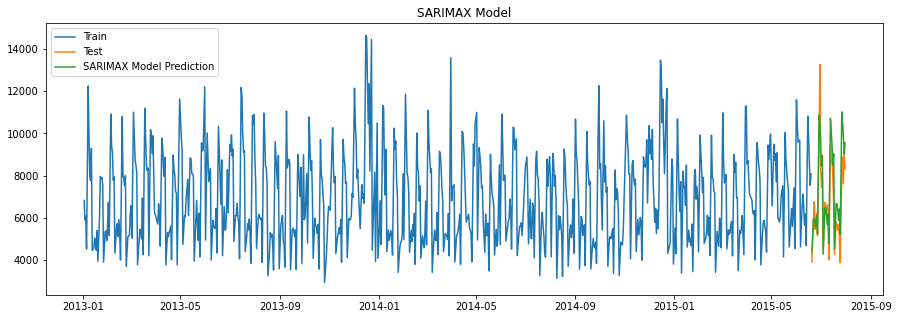

In [70]:
#Create a copy of test dataframe
store3_sarimaxmodel_pred = store3_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store3_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','PromoOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store3_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store3,store3_train_sarimax,store3_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store3_train_sarimax[col] = scaler3.inverse_transform(store3[col][:store3_train.shape[0]])
store3_test_sarimax[col] = scaler3.inverse_transform(store3[col][store3_train.shape[0]:])
store3_sarimaxmodel_pred[col] = scaler3.inverse_transform(store3_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store3_train_sarimax,store3_test_sarimax,store3_sarimaxmodel_pred,'SARIMAX')

In [71]:
#SARIMAX Model Evaluation.
store3_result = modelEvalution(store3_test_sarimax['Sales'],store3_sarimaxmodel_pred['Sales'],'SARIMAX Model',store3_result)
store3_result

Method     RMSE   MAPE
0    ARIMA Model  1919.21  26.21
0   SARIMA Model  1300.47  15.95
0  SARIMAX Model  1149.76  12.65

##### VARMAX MODEL

In [72]:
#Create a copy of test and train dataframe for this model.
store3_train_varmax = store3_train.copy()
store3_test_varmax = store3_test.copy()

exog = store3_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','PromoOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store3_model_varmax = sm.tsa.VARMAX(store3_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store3 = store3_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store3.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                        VARMAX(1,1)   Log Likelihood                1975.317
Date:                    Wed, 13 Apr 2022   AIC                          -3892.634
Time:                            10:40:57   BIC                          -3758.963
Sample:                                 0   HQIC                         -3841.102
                                    - 742                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            27.40, 6.25   Jarque-Bera (JB):       508.15, 194.15
Prob(Q):                        0.00, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.22, 1.24   Skew:                       1.01, 0.02
Prob(H) (two-sided):            0.12, 0.09   Kurtosis:                   6.51, 5.51


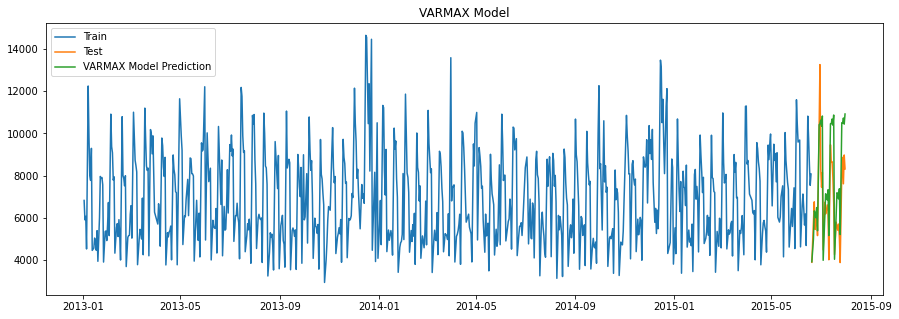

In [73]:
#Create a copy of test dataframe
store3_varmaxmodel_pred = store3_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store3_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','PromoOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store3_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store3,store3_train_varmax,store3_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store3_train_varmax[col] = scaler3.inverse_transform(store3[col][:store3_train.shape[0]])
store3_test_varmax[col] = scaler3.inverse_transform(store3[col][store3_train.shape[0]:])
store3_varmaxmodel_pred[col] = scaler3.inverse_transform(store3_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store3_train_varmax,store3_test_varmax,store3_varmaxmodel_pred,'VARMAX')

In [74]:
#VARMAX Model Evaluation.
store3_result = modelEvalution(store3_test_varmax['Sales'],store3_varmaxmodel_pred['Sales'],'VARMAX Model',store3_result)
store3_result

Method     RMSE   MAPE
0    ARIMA Model  1919.21  26.21
0   SARIMA Model  1300.47  15.95
0  SARIMAX Model  1149.76  12.65
0   VARMAX Model  1735.70  20.14

#### Store 8

In [75]:
store8.set_index('Date',drop=True,inplace=True)
store8 = store8.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store8_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store8[col],scaler8 = standardiseColumns(store8[col])

store8.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02      8  0.899524   0.998270    0.5            1.5         a   
2013-01-03      8  0.837119   0.956747    0.5            1.5         a   
2013-01-04      8  0.752433   0.789504    0.5            1.5         a   
2013-01-05      8  0.566191   0.553057    0.5            0.5         a   
2013-01-07      8  1.115509   1.118224    1.5            0.5         a   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               7520.0       0  2013      1    2           1   
2013-01-03               7520.0       0  2013      1    3           1   
2013-01-04               7520.0       0  2013      1    4           1   
2013-01-05               7520.0       0  2013      1    5           1   
2013-01-07               7520.0       0  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5        0.0          0.5          1.5          0.5   
2013-01-03              0.5        0.0          0.5          0.5          1.5   
2013-01-04              0.5        0.0          0.5          0.5          0.5   
2013-01-05              0.5        0.0          0.5          0.5          0.5   
2013-01-07              0.5        0.0          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 8


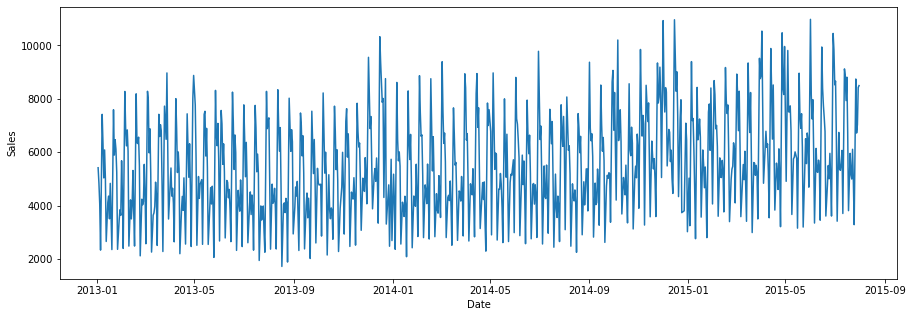

*****************************************************************************************************************************


In [76]:
plot_storeSales(8)

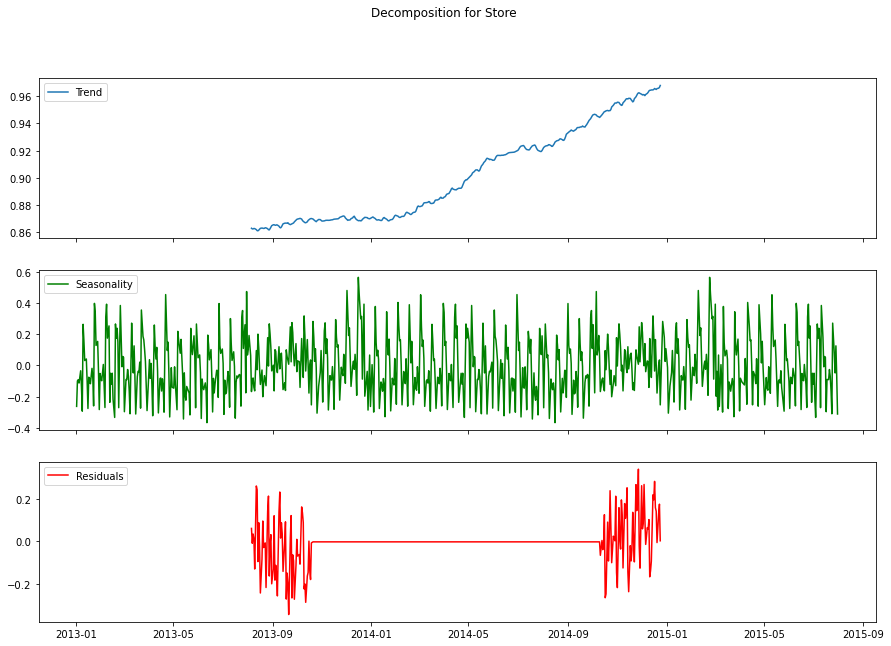

In [77]:
#Decomposition plot for the Store 8 timeseries.
plot_timeseries(store8['Sales'])

In [78]:
#Check stationarity of the sales and Customers for store 8
for column in col:
    adfuller_test(store8[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1666
 No. Lags Chosen       = 18
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7096
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0724. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [79]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store8_differenced = store8[col].diff().dropna()

In [80]:
#Check stationarity of the sales and Customers for store 1
for column in col:
    adfuller_test(store8_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6484
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4868
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [81]:
#Check cointegration for store 1
joh_model1 = coint_johansen(store8_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat   trace_stat
0   1112.405657  1486.835741
1    374.430084   374.430084 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [82]:
#Train-Test split
store8_train,store8_test = test_train_split(store8)

##### ARIMA MODEL

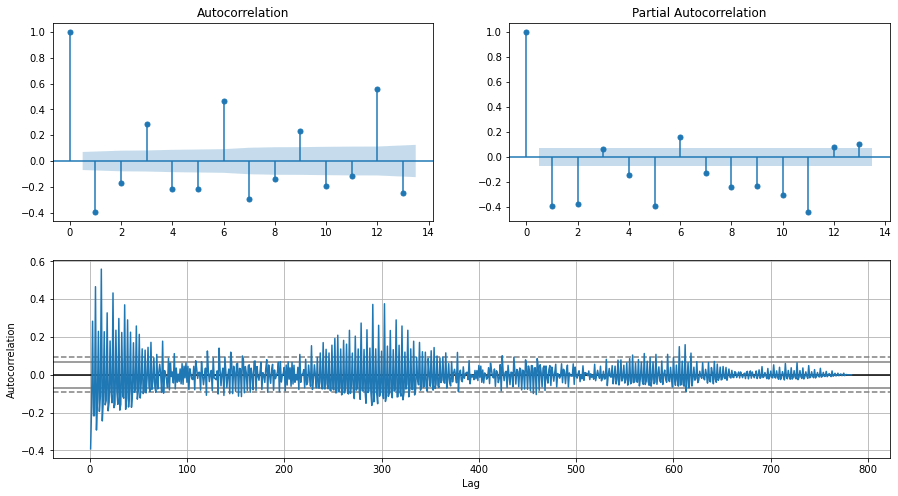

In [83]:
#Plot the ACF and PACF
plot_acf_pacf(store8_differenced['Sales'],0,13)

In [84]:
#Create a copy of test and train dataframe for this model.
store8_train_arima = store8_train.copy()
store8_test_arima = store8_test.copy()

#Build the ARIMA Model
store8_model_arima = ARIMA(store8_train_arima['Sales'], order=(7,1,1))
arima_model_store8 = store8_model_arima.fit()

# summary of fit model
print(arima_model_store8.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  748
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 276.727
Date:                Wed, 13 Apr 2022   AIC                           -535.455
Time:                        10:41:33   BIC                           -493.910
Sample:                             0   HQIC                          -519.444
                                - 748                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2705      0.035      7.794      0.000       0.202       0.338
ar.L2         -0.0497      0.041     -1.210      0.226      -0.130       0.031
ar.L3          0.0464      0.044      1.052      0.2

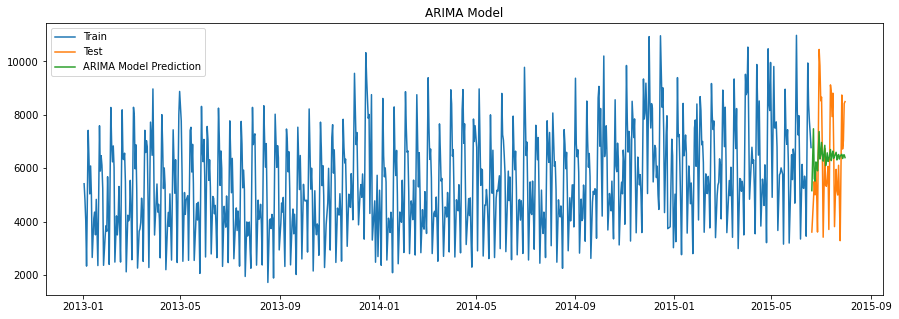

In [85]:
store8_arimamodel_pred = store8_test_arima.copy()

#Predict the sales for 6 weeks
store8_arimamodel_pred['Sales'] = predict_sales(arima_model_store8,store8_train_arima,store8_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store8_train_arima[col] = scaler8.inverse_transform(store8[col][:store8_train.shape[0]])
store8_test_arima[col] = scaler8.inverse_transform(store8[col][store8_train.shape[0]:])
store8_arimamodel_pred[col] = scaler8.inverse_transform(store8_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store8_train_arima,store8_test_arima,store8_arimamodel_pred,'ARIMA')

In [86]:
#ARIMA Model Evaluation.
store8_result = modelEvalution(store8_test_arima['Sales'],store8_arimamodel_pred['Sales'],'ARIMA Model',store8_result)
store8_result

Method     RMSE   MAPE
0  ARIMA Model  1812.38  26.98

##### SARIMA MODEL

In [87]:
#Create a copy of test and train dataframe for this model.
store8_train_sarima = store8_train.copy()
store8_test_sarima = store8_test.copy()

#SARIMA Model Building
store8_model_sarima = SARIMAX(store8_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store8 = store8_model_sarima.fit()

# summary of fit model
print(sarima_model_store8.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  748
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 336.989
Date:                            Wed, 13 Apr 2022   AIC                           -639.977
Time:                                    10:44:14   BIC                           -561.780
Sample:                                         0   HQIC                          -609.818
                                            - 748                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2416      0.029      8.461      0.000       0.186       0.298
ar.L2          0.0686      0.034   

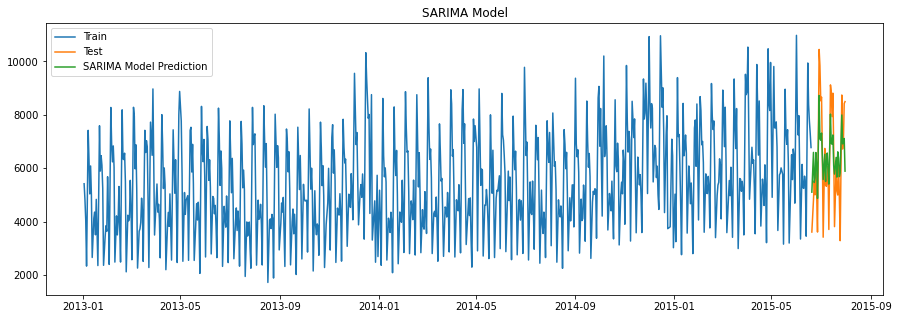

In [88]:
store8_sarimamodel_pred = store8_test_sarima.copy()

#Predict the sales for 6 weeks
store8_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store8,store8_train_sarima,store8_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store8_train_sarima[col] = scaler8.inverse_transform(store8[col][:store8_train.shape[0]])
store8_test_sarima[col] = scaler8.inverse_transform(store8[col][store8_train.shape[0]:])
store8_sarimamodel_pred[col] = scaler8.inverse_transform(store8_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store8_train_sarima,store8_test_sarima,store8_sarimamodel_pred,'SARIMA')

In [89]:
#SARIMA Model Evaluation.
store8_result = modelEvalution(store8_test_sarima['Sales'],store8_sarimamodel_pred['Sales'],'SARIMA Model',store8_result)
store8_result

Method     RMSE   MAPE
0   ARIMA Model  1812.38  26.98
0  SARIMA Model  1342.04  20.02

##### SARIMAX MODEL

In [90]:
#Create a copy of test and train dataframe for this model.
store8_train_sarimax = store8_train.copy()
store8_test_sarimax = store8_test.copy()

#SARIMAX Model Building.
exog = store8_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store8_model_sarimax = SARIMAX(store8_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store8 = store8_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store8.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  748
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 892.618
Date:                            Wed, 13 Apr 2022   AIC                          -1735.235
Time:                                    10:50:21   BIC                          -1620.238
Sample:                                         0   HQIC                         -1690.883
                                            - 748                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.2437      0.010     24.227      0.000       0.224       0.263
SchoolHoliday       

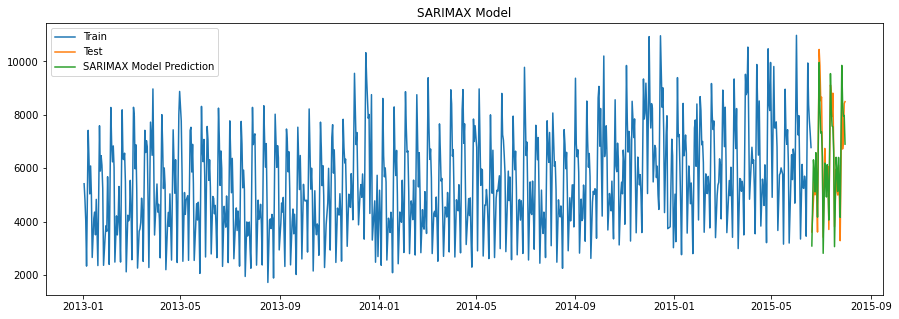

In [91]:
#Create a copy of test dataframe
store8_sarimaxmodel_pred = store8_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store8_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store8_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store8,store8_train_sarimax,store8_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store8_train_sarimax[col] = scaler8.inverse_transform(store8[col][:store8_train.shape[0]])
store8_test_sarimax[col] = scaler8.inverse_transform(store8[col][store8_train.shape[0]:])
store8_sarimaxmodel_pred[col] = scaler8.inverse_transform(store8_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store8_train_sarimax,store8_test_sarimax,store8_sarimaxmodel_pred,'SARIMAX')

In [92]:
#SARIMAX Model Evaluation.
store8_result = modelEvalution(store8_test_sarimax['Sales'],store8_sarimaxmodel_pred['Sales'],'SARIMAX Model',store8_result)
store8_result

Method     RMSE   MAPE
0    ARIMA Model  1812.38  26.98
0   SARIMA Model  1342.04  20.02
0  SARIMAX Model   818.26  11.32

##### VARMAX MODEL

In [93]:
#Create a copy of test and train dataframe for this model.
store8_train_varmax = store8_train.copy()
store8_test_varmax = store8_test.copy()

exog = store8_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store8_model_varmax = sm.tsa.VARMAX(store8_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store8 = store8_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store8.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  748
Model:                        VARMAX(1,1)   Log Likelihood                1961.543
Date:                    Wed, 13 Apr 2022   AIC                          -3869.086
Time:                            10:51:33   BIC                          -3744.416
Sample:                                 0   HQIC                         -3821.042
                                    - 748                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            24.98, 5.58   Jarque-Bera (JB):         17.71, 86.69
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.12, 1.83   Skew:                       0.28, 0.15
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   3.51, 4.64


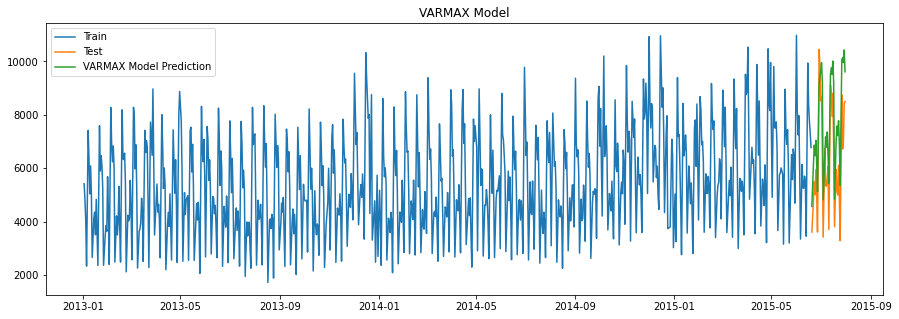

In [94]:
#Create a copy of test dataframe
store8_varmaxmodel_pred = store8_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store8_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store8_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store8,store8_train_varmax,store8_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store8_train_varmax[col] = scaler8.inverse_transform(store8[col][:store8_train.shape[0]])
store8_test_varmax[col] = scaler8.inverse_transform(store8[col][store8_train.shape[0]:])
store8_varmaxmodel_pred[col] = scaler8.inverse_transform(store8_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store8_train_varmax,store8_test_varmax,store8_varmaxmodel_pred,'VARMAX')

In [95]:
#VARMAX Model Evaluation.
store8_result = modelEvalution(store8_test_varmax['Sales'],store8_varmaxmodel_pred['Sales'],'VARMAX Model',store8_result)
store8_result

Method     RMSE   MAPE
0    ARIMA Model  1812.38  26.98
0   SARIMA Model  1342.04  20.02
0  SARIMAX Model   818.26  11.32
0   VARMAX Model  1658.23  26.73

#### Store 9

In [96]:
store9.set_index('Date',drop=True,inplace=True)
store9 = store9.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store9_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store9[col],scaler9 = standardiseColumns(store9[col])

store9.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02      9  0.703019   0.754848    0.5            1.5         a   
2013-01-03      9  0.674974   0.716066    0.5            1.5         a   
2013-01-04      9  0.693236   0.777008    0.5            1.5         a   
2013-01-05      9  0.642551   0.711911    0.5            0.5         a   
2013-01-07      9  0.951877   0.926593    1.5            0.5         a   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               2030.0       0  2013      1    2           1   
2013-01-03               2030.0       0  2013      1    3           1   
2013-01-04               2030.0       0  2013      1    4           1   
2013-01-05               2030.0       0  2013      1    5           1   
2013-01-07               2030.0       0  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5        0.0          0.5          1.5          0.5   
2013-01-03              0.5        0.0          0.5          0.5          1.5   
2013-01-04              0.5        0.0          0.5          0.5          0.5   
2013-01-05              0.5        0.0          0.5          0.5          0.5   
2013-01-07              0.5        0.0          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 9


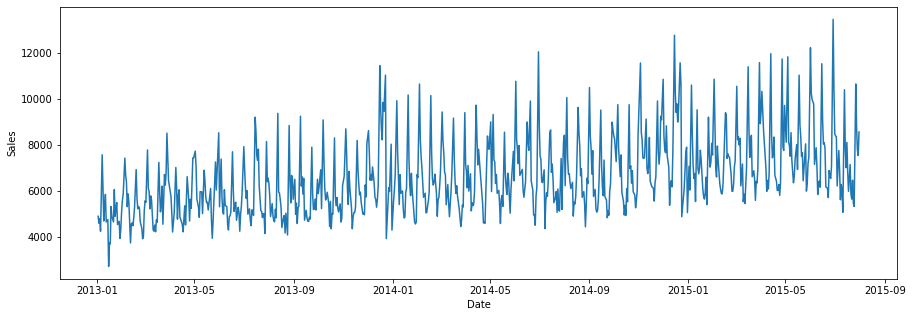

*****************************************************************************************************************************


In [97]:
plot_storeSales(9)

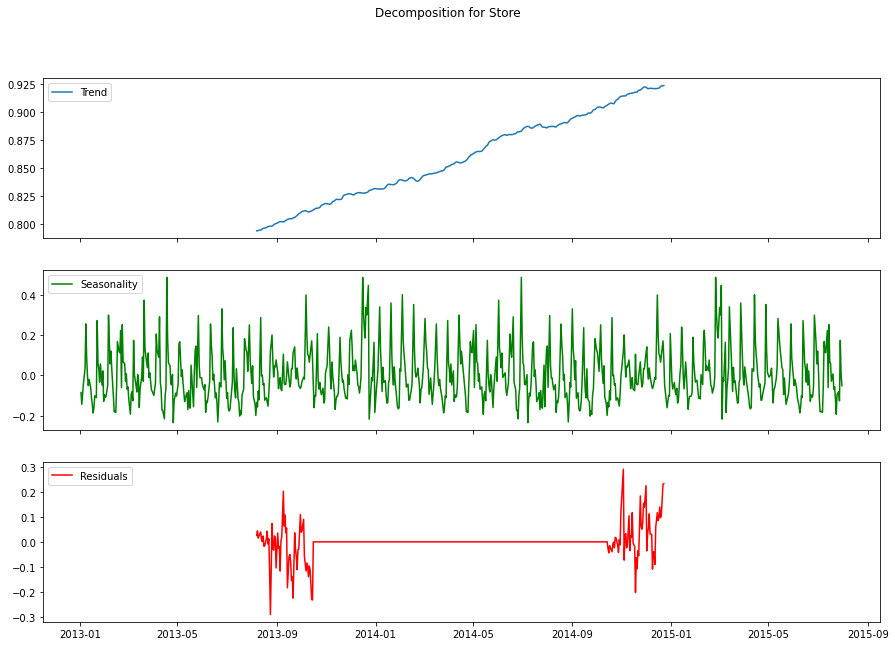

In [98]:
#Decomposition plot for the Store 9 timeseries.
plot_timeseries(store9['Sales'])

In [99]:
#Check stationarity of the sales and Customers for store 1
for column in col:
    adfuller_test(store9[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6716
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0791. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.783
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0607. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has

In [100]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store9_differenced = store9[col].diff().dropna()

In [101]:
#Check stationarity of the sales and Customers for store 1
for column in col:
    adfuller_test(store9_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.5912
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4156
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [102]:
#Check cointegration for store 1
joh_model1 = coint_johansen(store9_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat   trace_stat
0    633.764979  1111.439324
1    477.674345   477.674345 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [103]:
#Train-Test split
store9_train,store9_test = test_train_split(store9)

##### ARIMA MODEL

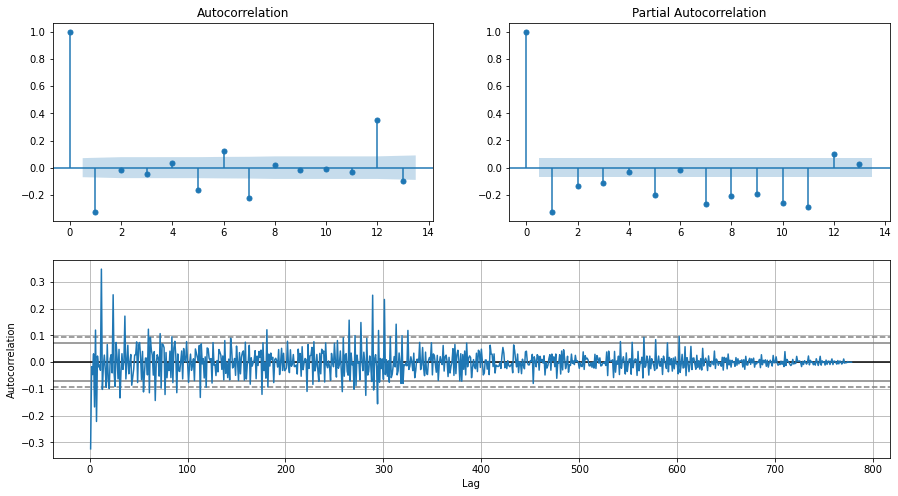

In [104]:
#Plot the ACF and PACF
plot_acf_pacf(store9_differenced['Sales'],0,13)

In [105]:
#Create a copy of test and train dataframe for this model.
store9_train_arima = store9_train.copy()
store9_test_arima = store9_test.copy()

#Build the ARIMA Model
store9_model_arima = ARIMA(store9_train_arima['Sales'], order=(7,1,1))
arima_model_store9 = store9_model_arima.fit()

# summary of fit model
print(arima_model_store9.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  743
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 566.827
Date:                Wed, 13 Apr 2022   AIC                          -1115.654
Time:                        10:53:32   BIC                          -1074.169
Sample:                             0   HQIC                         -1099.661
                                - 743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3261      0.044      7.390      0.000       0.240       0.413
ar.L2          0.0384      0.044      0.865      0.387      -0.049       0.125
ar.L3         -0.0582      0.047     -1.242      0.2

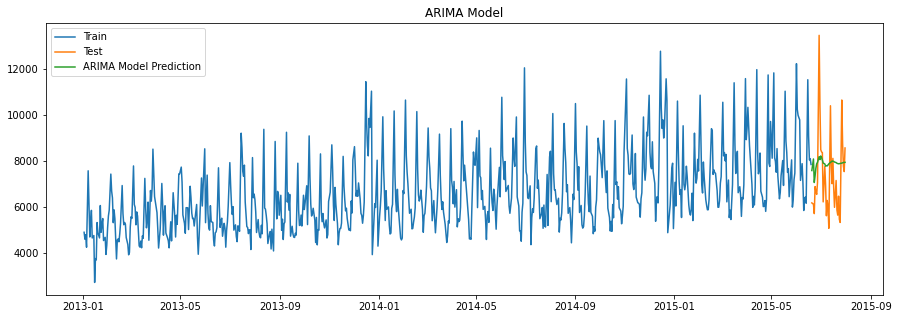

In [106]:
store9_arimamodel_pred = store9_test_arima.copy()

#Predict the sales for 6 weeks
store9_arimamodel_pred['Sales'] = predict_sales(arima_model_store9,store9_train_arima,store9_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store9_train_arima[col] = scaler9.inverse_transform(store9[col][:store9_train.shape[0]])
store9_test_arima[col] = scaler9.inverse_transform(store9[col][store9_train.shape[0]:])
store9_arimamodel_pred[col] = scaler9.inverse_transform(store9_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store9_train_arima,store9_test_arima,store9_arimamodel_pred,'ARIMA')

In [107]:
#ARIMA Model Evaluation.
store9_result = modelEvalution(store9_test_arima['Sales'],store9_arimamodel_pred['Sales'],'ARIMA Model',store9_result)
store9_result

Method     RMSE   MAPE
0  ARIMA Model  1763.56  20.36

##### SARIMA MODEL

In [108]:
#Create a copy of test and train dataframe for this model.
store9_train_sarima = store9_train.copy()
store9_test_sarima = store9_test.copy()

#SARIMA Model Building
store9_model_sarima = SARIMAX(store9_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store9 = store9_model_sarima.fit()

# summary of fit model
print(sarima_model_store9.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  743
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 573.482
Date:                            Wed, 13 Apr 2022   AIC                          -1112.963
Time:                                    10:55:53   BIC                          -1034.881
Sample:                                         0   HQIC                         -1082.839
                                            - 743                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3265      0.036      9.069      0.000       0.256       0.397
ar.L2          0.1103      0.040   

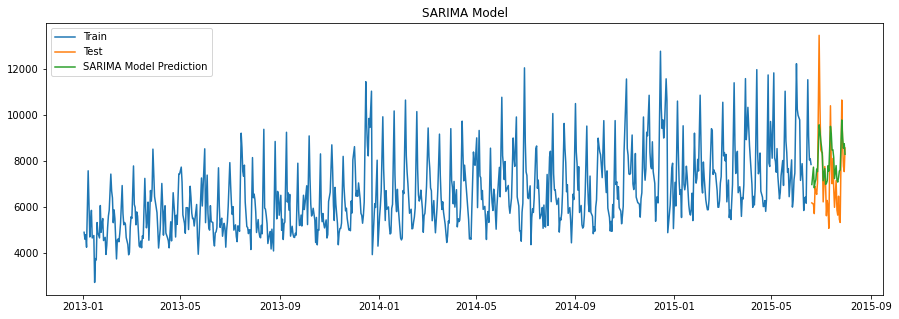

In [109]:
store9_sarimamodel_pred = store9_test_sarima.copy()

#Predict the sales for 6 weeks
store9_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store9,store9_train_sarima,store9_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store9_train_sarima[col] = scaler9.inverse_transform(store9[col][:store9_train.shape[0]])
store9_test_sarima[col] = scaler9.inverse_transform(store9[col][store9_train.shape[0]:])
store9_sarimamodel_pred[col] = scaler9.inverse_transform(store9_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store9_train_sarima,store9_test_sarima,store9_sarimamodel_pred,'SARIMA')

In [110]:
#SARIMA Model Evaluation.
store9_result = modelEvalution(store9_test_sarima['Sales'],store9_sarimamodel_pred['Sales'],'SARIMA Model',store9_result)
store9_result

Method     RMSE   MAPE
0   ARIMA Model  1763.56  20.36
0  SARIMA Model  1305.72  15.49

##### SARIMAX MODEL

In [111]:
#Create a copy of test and train dataframe for this model.
store9_train_sarimax = store9_train.copy()
store9_test_sarimax = store9_test.copy()

#SARIMAX Model Building.
exog = store9_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store9_model_sarimax = SARIMAX(store9_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store9 = store9_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store9.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  743
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 827.413
Date:                            Wed, 13 Apr 2022   AIC                          -1604.826
Time:                                    11:01:11   BIC                          -1490.000
Sample:                                         0   HQIC                         -1560.525
                                            - 743                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.1908      0.011     17.367      0.000       0.169       0.212
SchoolHoliday       

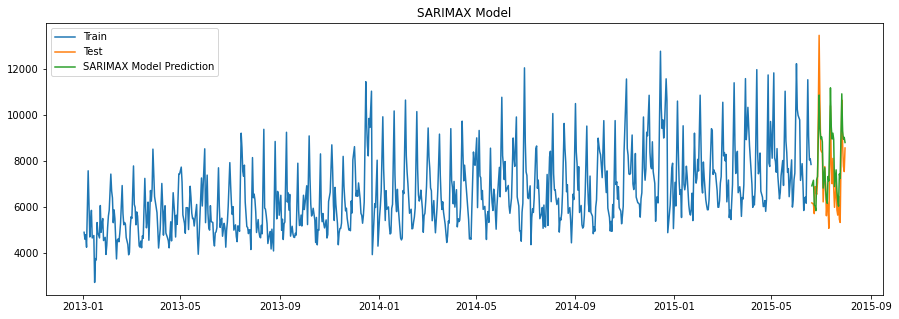

In [112]:
#Create a copy of test dataframe
store9_sarimaxmodel_pred = store9_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store9_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store9_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store9,store9_train_sarimax,store9_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store9_train_sarimax[col] = scaler9.inverse_transform(store9[col][:store9_train.shape[0]])
store9_test_sarimax[col] = scaler9.inverse_transform(store9[col][store9_train.shape[0]:])
store9_sarimaxmodel_pred[col] = scaler9.inverse_transform(store9_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store9_train_sarimax,store9_test_sarimax,store9_sarimaxmodel_pred,'SARIMAX')

In [113]:
#SARIMAX Model Evaluation.
store9_result = modelEvalution(store9_test_sarimax['Sales'],store9_sarimaxmodel_pred['Sales'],'SARIMAX Model',store9_result)
store9_result

Method     RMSE   MAPE
0    ARIMA Model  1763.56  20.36
0   SARIMA Model  1305.72  15.49
0  SARIMAX Model  1125.64  13.42

##### VARMAX MODEL

In [114]:
#Create a copy of test and train dataframe for this model.
store9_train_varmax = store9_train.copy()
store9_test_varmax = store9_test.copy()

exog = store9_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store9_model_varmax = sm.tsa.VARMAX(store9_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store9 = store9_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store9.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  743
Model:                        VARMAX(1,1)   Log Likelihood                2062.301
Date:                    Wed, 13 Apr 2022   AIC                          -4070.602
Time:                            11:02:18   BIC                          -3946.113
Sample:                                 0   HQIC                         -4022.612
                                    - 743                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             5.43, 0.46   Jarque-Bera (JB):        41.87, 152.66
Prob(Q):                        0.02, 0.50   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.34, 1.66   Skew:                      0.41, -0.01
Prob(H) (two-sided):            0.02, 0.00   Kurtosis:                   3.82, 5.22


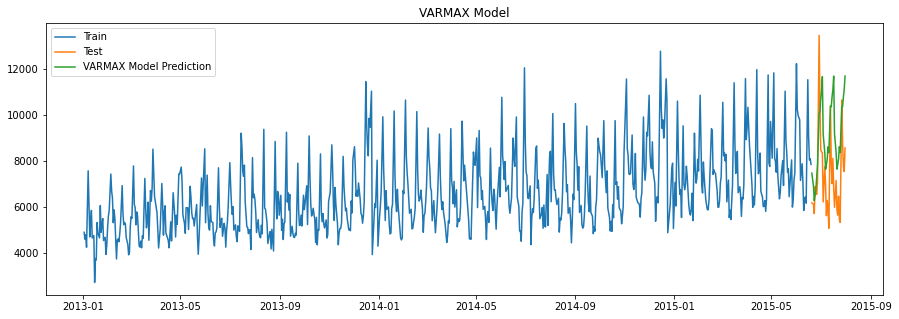

In [115]:
#Create a copy of test dataframe
store9_varmaxmodel_pred = store9_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store9_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store9_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store9,store9_train_varmax,store9_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store9_train_varmax[col] = scaler9.inverse_transform(store9[col][:store9_train.shape[0]])
store9_test_varmax[col] = scaler9.inverse_transform(store9[col][store9_train.shape[0]:])
store9_varmaxmodel_pred[col] = scaler9.inverse_transform(store9_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store9_train_varmax,store9_test_varmax,store9_varmaxmodel_pred,'VARMAX')

In [116]:
#VARMAX Model Evaluation.
store9_result = modelEvalution(store9_test_varmax['Sales'],store9_varmaxmodel_pred['Sales'],'VARMAX Model',store9_result)
store9_result

Method     RMSE   MAPE
0    ARIMA Model  1763.56  20.36
0   SARIMA Model  1305.72  15.49
0  SARIMAX Model  1125.64  13.42
0   VARMAX Model  2371.07  29.34

#### Store 13

In [117]:
store13.set_index('Date',drop=True,inplace=True)
store13 = store13.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store13_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','PromoOpen',
       'DayOfWeek_2', 'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store13[col],scaler13 = standardiseColumns(store13[col])

store13.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02     13  0.685091   0.757322    0.5            1.5         d   
2013-01-03     13  0.677455   0.705021    0.5            1.5         d   
2013-01-04     13  0.698545   0.805439    0.5            1.5         d   
2013-01-05     13  0.751515   0.813808    0.5            0.5         d   
2013-01-07     13  1.231636   1.284519    1.5            0.5         d   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02                310.0       1  2013      1    2           1   
2013-01-03                310.0       1  2013      1    3           1   
2013-01-04                310.0       1  2013      1    4           1   
2013-01-05                310.0       1  2013      1    5           1   
2013-01-07                310.0       1  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.0   0.500000          0.5          1.5          0.5   
2013-01-03              0.0   0.500000          0.5          0.5          1.5   
2013-01-04              0.0   0.500000          0.5          0.5          0.5   
2013-01-05              0.0   0.500000          0.5          0.5          0.5   
2013-01-07              0.0   0.507937          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 13


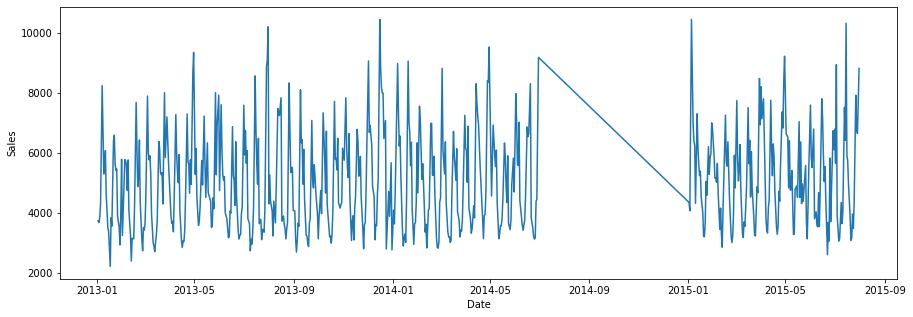

*****************************************************************************************************************************


In [118]:
plot_storeSales(13)

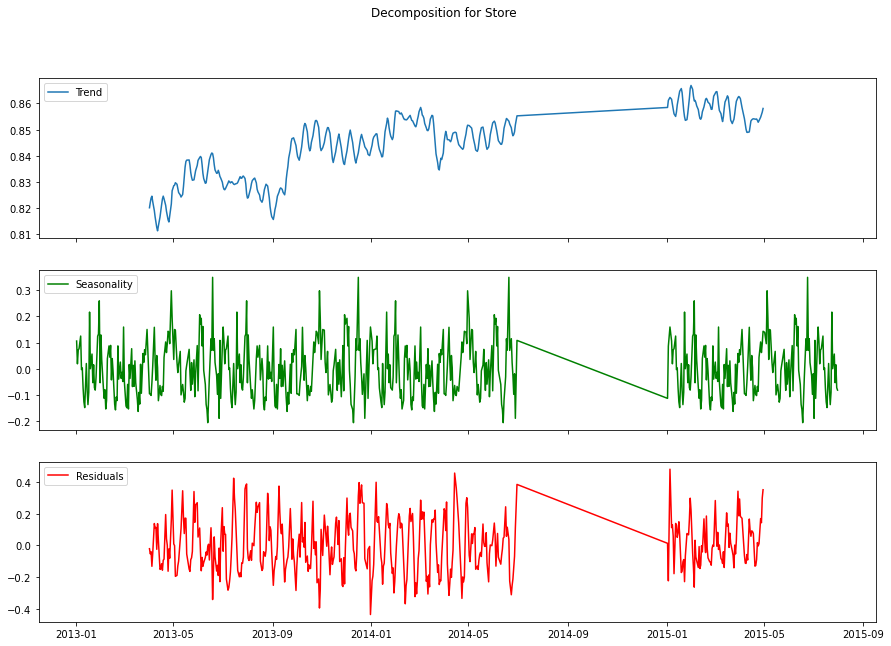

In [119]:
#Plot the decomposition which shows the trend, Seasonality and residuals in sales for store.
def plot_timeseries1(sales):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=150)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    plt.suptitle('Decomposition for Store')
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')
    
#Decomposition plot for the Store 13 timeseries.
plot_timeseries1(store13['Sales'])

In [120]:
#Check stationarity of the sales and Customers for store 13
for column in col:
    adfuller_test(store13[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.301
 No. Lags Chosen       = 12
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4954
 No. Lags Chosen       = 12
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [121]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store13_differenced = store13[col].diff().dropna()

In [122]:
#Check stationarity of the sales and Customers for store 13
for column in col:
    adfuller_test(store13_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.5391
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.1378
 No. Lags Chosen       = 19
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [123]:
#Check cointegration for store 13
joh_model1 = coint_johansen(store13_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    481.612267  799.359796
1    317.747529  317.747529 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [124]:
#Train-Test split
store13_train,store13_test = test_train_split(store13)

##### ARIMA MODEL

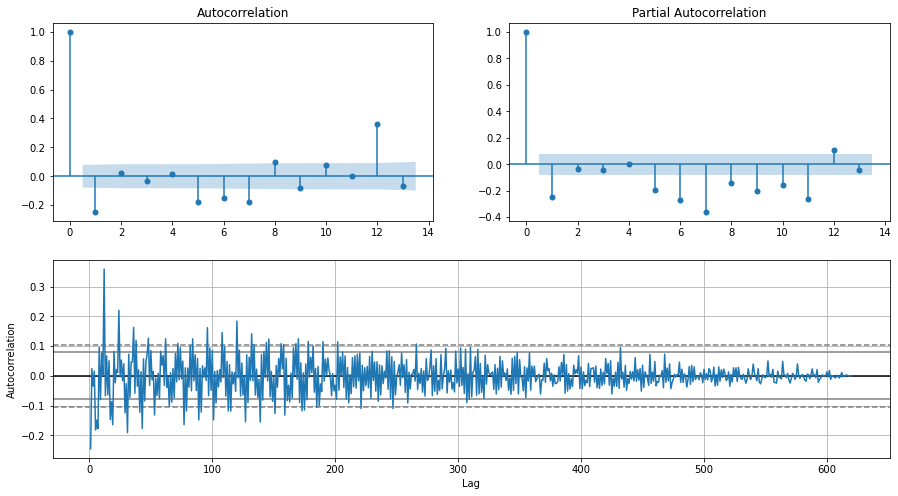

In [125]:
#Plot the ACF and PACF
plot_acf_pacf(store13_differenced['Sales'],0,13)

In [126]:
#Create a copy of test and train dataframe for this model.
store13_train_arima = store13_train.copy()
store13_test_arima = store13_test.copy()

#Build the ARIMA Model
store13_model_arima = ARIMA(store13_train_arima['Sales'], order=(7,1,1))
arima_model_store13 = store13_model_arima.fit()

# summary of fit model
print(arima_model_store13.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  585
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 289.621
Date:                Wed, 13 Apr 2022   AIC                           -561.242
Time:                        11:57:22   BIC                           -521.913
Sample:                             0   HQIC                          -545.914
                                - 585                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3463      0.042      8.325      0.000       0.265       0.428
ar.L2          0.0591      0.045      1.328      0.184      -0.028       0.146
ar.L3         -0.0291      0.039     -0.750      0.4

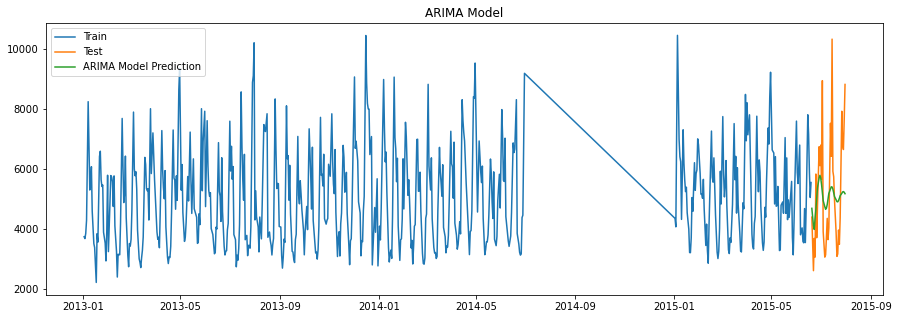

In [127]:
store13_arimamodel_pred = store13_test_arima.copy()

#Predict the sales for 6 weeks
store13_arimamodel_pred['Sales'] = predict_sales(arima_model_store13,store13_train_arima,store13_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store13_train_arima[col] = scaler13.inverse_transform(store13[col][:store13_train.shape[0]])
store13_test_arima[col] = scaler13.inverse_transform(store13[col][store13_train.shape[0]:])
store13_arimamodel_pred[col] = scaler13.inverse_transform(store13_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store13_train_arima,store13_test_arima,store13_arimamodel_pred,'ARIMA')

In [128]:
#ARIMA Model Evaluation.
store13_result = modelEvalution(store13_test_arima['Sales'],store13_arimamodel_pred['Sales'],'ARIMA Model',store13_result)
store13_result

Method     RMSE  MAPE
0  ARIMA Model  1732.92  27.6

##### SARIMA MODEL

In [129]:
#Create a copy of test and train dataframe for this model.
store13_train_sarima = store13_train.copy()
store13_test_sarima = store13_test.copy()

#SARIMA Model Building
store13_model_sarima = SARIMAX(store13_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store13 = store13_model_sarima.fit()

# summary of fit model
print(sarima_model_store13.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  585
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 299.458
Date:                            Wed, 13 Apr 2022   AIC                           -564.916
Time:                                    11:59:58   BIC                           -490.981
Sample:                                         0   HQIC                          -536.073
                                            - 585                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4030      0.035     11.391      0.000       0.334       0.472
ar.L2          0.0121      0.042   

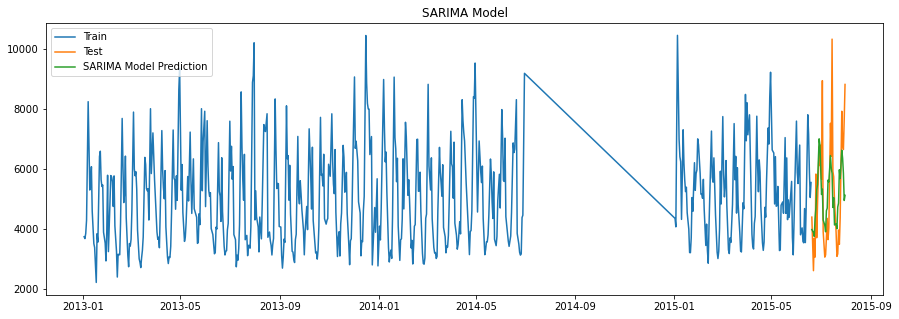

In [130]:
store13_sarimamodel_pred = store13_test_sarima.copy()

#Predict the sales for 6 weeks
store13_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store13,store13_train_sarima,store13_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store13_train_sarima[col] = scaler13.inverse_transform(store13[col][:store13_train.shape[0]])
store13_test_sarima[col] = scaler13.inverse_transform(store13[col][store13_train.shape[0]:])
store13_sarimamodel_pred[col] = scaler13.inverse_transform(store13_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store13_train_sarima,store13_test_sarima,store13_sarimamodel_pred,'SARIMA')

In [131]:
#SARIMA Model Evaluation.
store13_result = modelEvalution(store13_test_sarima['Sales'],store13_sarimamodel_pred['Sales'],'SARIMA Model',store13_result)
store13_result

Method     RMSE   MAPE
0   ARIMA Model  1732.92  27.60
0  SARIMA Model  1590.71  24.63

##### SARIMAX MODEL

In [132]:
#Create a copy of test and train dataframe for this model.
store13_train_sarimax = store13_train.copy()
store13_test_sarimax = store13_test.copy()

#SARIMAX Model Building.
exog = store13_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store13_model_sarimax = SARIMAX(store13_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store13 = store13_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store13.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  585
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 512.538
Date:                            Wed, 13 Apr 2022   AIC                           -973.076
Time:                                    12:03:49   BIC                           -859.998
Sample:                                         0   HQIC                          -928.963
                                            - 585                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Promo                   0.3395      0.015     21.965      0.000       0.309       0.370
SchoolHo

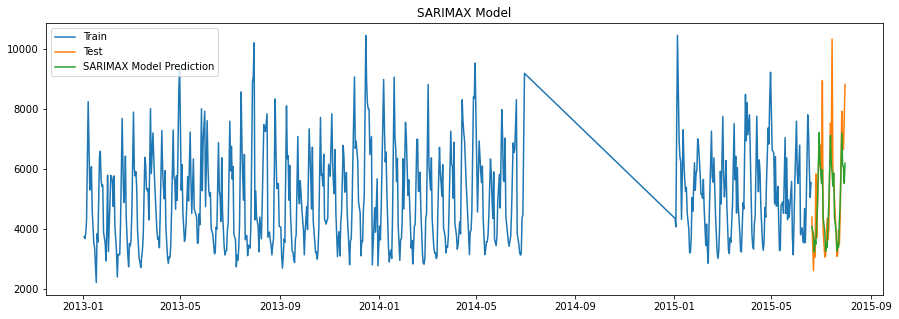

In [133]:
#Create a copy of test dataframe
store13_sarimaxmodel_pred = store13_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store13_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store13_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store13,store13_train_sarimax,store13_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store13_train_sarimax[col] = scaler13.inverse_transform(store13[col][:store13_train.shape[0]])
store13_test_sarimax[col] = scaler13.inverse_transform(store13[col][store13_train.shape[0]:])
store13_sarimaxmodel_pred[col] = scaler13.inverse_transform(store13_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store13_train_sarimax,store13_test_sarimax,store13_sarimaxmodel_pred,'SARIMAX')

In [134]:
#SARIMAX Model Evaluation.
store13_result = modelEvalution(store13_test_sarimax['Sales'],store13_sarimaxmodel_pred['Sales'],'SARIMAX Model',store13_result)
store13_result

Method     RMSE   MAPE
0    ARIMA Model  1732.92  27.60
0   SARIMA Model  1590.71  24.63
0  SARIMAX Model  1240.68  14.81

##### VARMAX MODEL

In [135]:
#Create a copy of test and train dataframe for this model.
store13_train_varmax = store13_train.copy()
store13_test_varmax = store13_test.copy()

exog = store13_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store13_model_varmax = sm.tsa.VARMAX(store13_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store13 = store13_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store13.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  585
Model:                        VARMAX(1,1)   Log Likelihood                1385.398
Date:                    Wed, 13 Apr 2022   AIC                          -2712.796
Time:                            12:04:25   BIC                          -2586.019
Sample:                                 0   HQIC                         -2663.388
                                    - 585                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.39, 0.03   Jarque-Bera (JB):        162.90, 58.21
Prob(Q):                        0.53, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.11, 1.61   Skew:                      0.90, -0.16
Prob(H) (two-sided):            0.46, 0.00   Kurtosis:                   4.86, 4.51


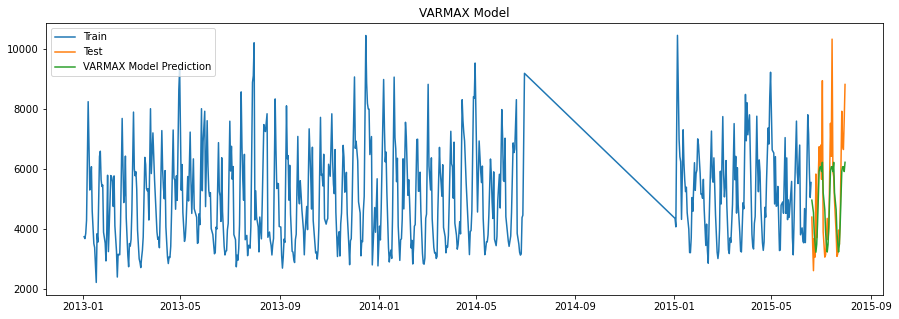

In [136]:
#Create a copy of test dataframe
store13_varmaxmodel_pred = store13_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store13_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store13_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store13,store13_train_varmax,store13_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store13_train_varmax[col] = scaler13.inverse_transform(store13[col][:store13_train.shape[0]])
store13_test_varmax[col] = scaler13.inverse_transform(store13[col][store13_train.shape[0]:])
store13_varmaxmodel_pred[col] = scaler13.inverse_transform(store13_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store13_train_varmax,store13_test_varmax,store13_varmaxmodel_pred,'VARMAX')

In [137]:
#VARMAX Model Evaluation.
store13_result = modelEvalution(store13_test_varmax['Sales'],store13_varmaxmodel_pred['Sales'],'VARMAX Model',store13_result)
store13_result

Method     RMSE   MAPE
0    ARIMA Model  1732.92  27.60
0   SARIMA Model  1590.71  24.63
0  SARIMAX Model  1240.68  14.81
0   VARMAX Model  1335.61  17.69

#### Store 25

In [138]:
store25.set_index('Date',drop=True,inplace=True)
store25 = store25.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store25_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store25[col],scaler25 = standardiseColumns(store25[col])

store25.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02     25  1.316907   1.445434    0.5            1.5         c   
2013-01-03     25  1.211921   1.383630    0.5            1.5         c   
2013-01-04     25  1.165413   1.346325    0.5            1.5         c   
2013-01-05     25  1.114664   1.268931    0.5            0.5         c   
2013-01-09     25  1.289207   1.412027    1.5            0.5         c   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02                430.0       0  2013      1    2           1   
2013-01-03                430.0       0  2013      1    3           1   
2013-01-04                430.0       0  2013      1    4           1   
2013-01-05                430.0       0  2013      1    5           1   
2013-01-09                430.0       0  2013      1    9           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5        0.0          0.5          1.5          0.5   
2013-01-03              0.5        0.0          0.5          0.5          1.5   
2013-01-04              0.5        0.0          0.5          0.5          0.5   
2013-01-05              0.5        0.0          0.5          0.5          0.5   
2013-01-09              0.5        0.0          0.5          1.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-09          0.5          0.5

Store 25


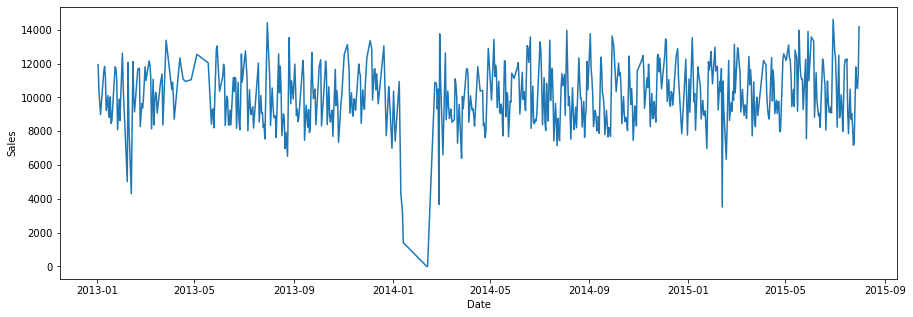

*****************************************************************************************************************************


In [139]:
plot_storeSales(25)

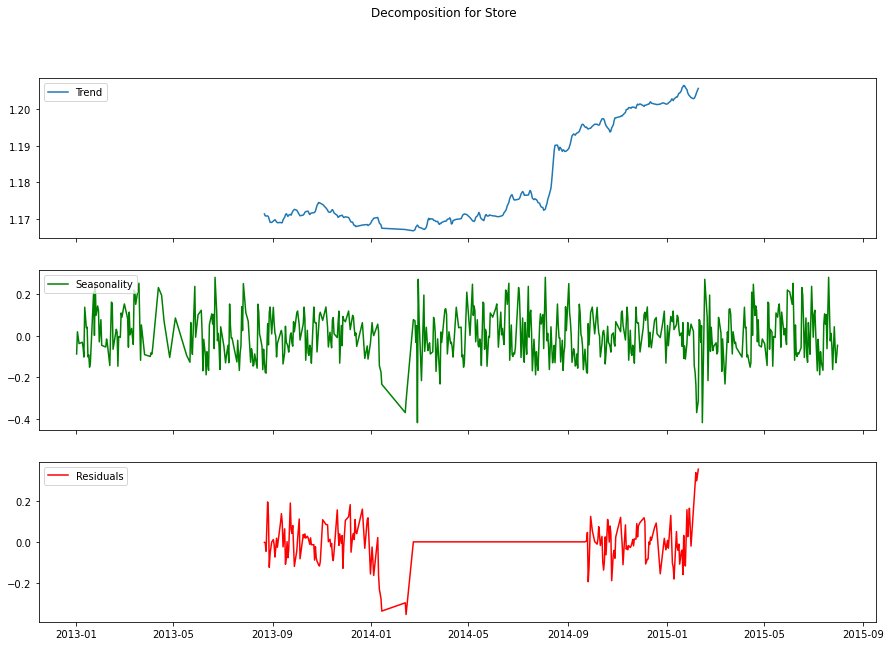

In [140]:
#Plot the decomposition which shows the trend, Seasonality and residuals in sales for store.
def plot_timeseries1(sales):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=250)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    plt.suptitle('Decomposition for Store')
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')
#Decomposition plot for the Store 25 timeseries.
plot_timeseries1(store25['Sales'])

In [141]:
#Check stationarity of the sales and Customers for store 25
for column in col:
    adfuller_test(store25[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2937
 No. Lags Chosen       = 9
 Critical value 1%     = -3.442
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7728
 No. Lags Chosen       = 3
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [142]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store25_differenced = store25[col].diff().dropna()

In [143]:
#Check stationarity of the sales and Customers for store 25
for column in col:
    adfuller_test(store25_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2799
 No. Lags Chosen       = 19
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6474
 No. Lags Chosen       = 15
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [144]:
#Check cointegration for store 25
joh_model1 = coint_johansen(store25_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    652.708596  982.444831
1    329.736235  329.736235 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [145]:
#Train-Test split
store25_train,store25_test = test_train_split(store25)

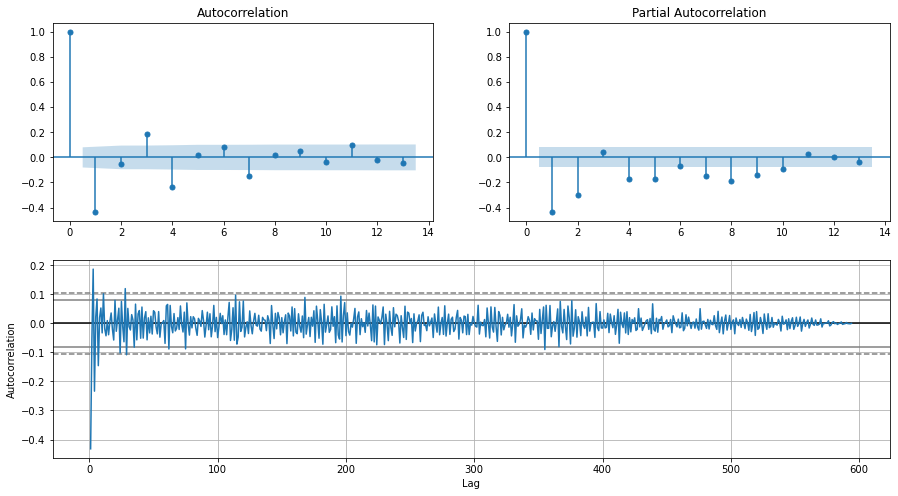

In [146]:
#Plot the ACF and PACF
plot_acf_pacf(store25_differenced['Sales'],0,13)

##### ARIMA MODEL

In [147]:
#Create a copy of test and train dataframe for this model.
store25_train_arima = store25_train.copy()
store25_test_arima = store25_test.copy()

#Build the ARIMA Model
store25_model_arima = ARIMA(store25_train_arima['Sales'], order=(7,1,10))
arima_model_store25 = store25_model_arima.fit()

# summary of fit model
print(arima_model_store25.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  559
Model:                ARIMA(7, 1, 10)   Log Likelihood                 404.912
Date:                Wed, 13 Apr 2022   AIC                           -773.824
Time:                        12:08:10   BIC                           -695.985
Sample:                             0   HQIC                          -743.425
                                - 559                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2417      1.464     -0.165      0.869      -3.111       2.627
ar.L2         -0.4216      0.759     -0.556      0.579      -1.909       1.066
ar.L3         -0.3092      1.190     -0.260      0.7

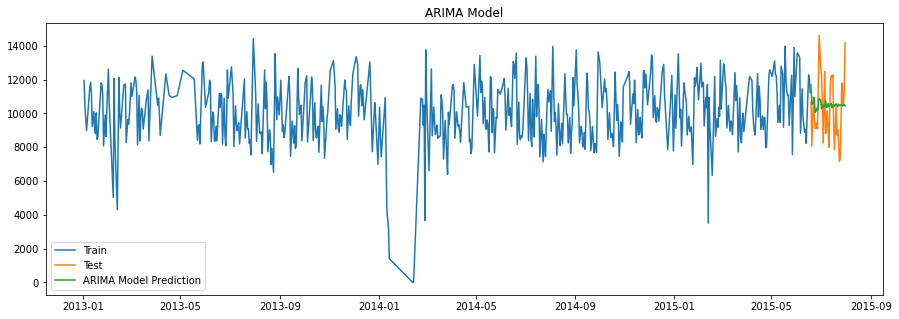

In [148]:
store25_arimamodel_pred = store25_test_arima.copy()

#Predict the sales for 6 weeks
store25_arimamodel_pred['Sales'] = predict_sales(arima_model_store25,store25_train_arima,store25_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store25_train_arima[col] = scaler25.inverse_transform(store25[col][:store25_train.shape[0]])
store25_test_arima[col] = scaler25.inverse_transform(store25[col][store25_train.shape[0]:])
store25_arimamodel_pred[col] = scaler25.inverse_transform(store25_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store25_train_arima,store25_test_arima,store25_arimamodel_pred,'ARIMA')

In [149]:
#ARIMA Model Evaluation.
store25_result = modelEvalution(store25_test_arima['Sales'],store25_arimamodel_pred['Sales'],'ARIMA Model',store25_result)
store25_result

Method     RMSE   MAPE
0  ARIMA Model  1842.36  16.14

##### SARIMA MODEL

In [150]:
#Create a copy of test and train dataframe for this model.
store25_train_sarima = store25_train.copy()
store25_test_sarima = store25_test.copy()

#SARIMA Model Building
store25_model_sarima = SARIMAX(store25_train_sarima['Sales'], order=(7, 1, 10), seasonal_order=(7, 1, 10, 12)) 
sarima_model_store25 = store25_model_sarima.fit()

# summary of fit model
print(sarima_model_store25.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                  559
Model:             SARIMAX(7, 1, 10)x(7, 1, 10, 12)   Log Likelihood                 378.536
Date:                              Wed, 13 Apr 2022   AIC                           -687.071
Time:                                      12:20:39   BIC                           -536.480
Sample:                                           0   HQIC                          -628.204
                                              - 559                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9515     25.867     -0.037      0.971     -51.649      49.746
ar.L2         -0.84

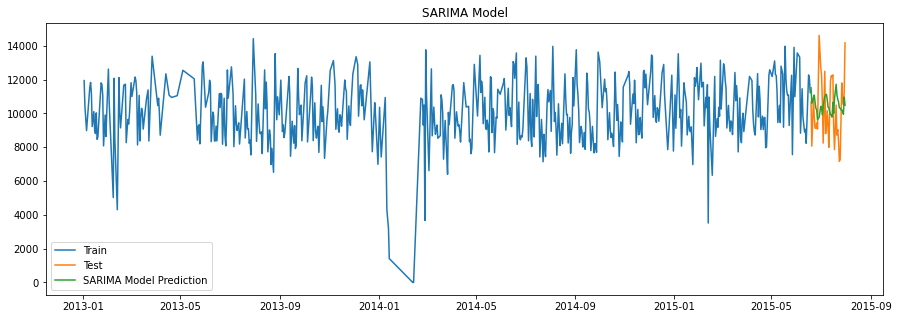

In [151]:
store25_sarimamodel_pred = store25_test_sarima.copy()

#Predict the sales for 6 weeks
store25_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store25,store25_train_sarima,store25_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store25_train_sarima[col] = scaler25.inverse_transform(store25[col][:store25_train.shape[0]])
store25_test_sarima[col] = scaler25.inverse_transform(store25[col][store25_train.shape[0]:])
store25_sarimamodel_pred[col] = scaler25.inverse_transform(store25_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store25_train_sarima,store25_test_sarima,store25_sarimamodel_pred,'SARIMA')

In [152]:
#SARIMA Model Evaluation.
store25_result = modelEvalution(store25_test_sarima['Sales'],store25_sarimamodel_pred['Sales'],'SARIMA Model',store25_result)
store25_result

Method     RMSE   MAPE
0   ARIMA Model  1842.36  16.14
0  SARIMA Model  2035.00  17.97

##### SARIMAX MODEL

In [153]:
#Create a copy of test and train dataframe for this model.
store25_train_sarimax = store25_train.copy()
store25_test_sarimax = store25_test.copy()

exog = store25_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store25_model_sarimax = SARIMAX(store25_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store25 = store25_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store25.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  559
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 501.231
Date:                            Wed, 13 Apr 2022   AIC                           -952.463
Time:                                    12:25:04   BIC                           -844.897
Sample:                                         0   HQIC                          -910.415
                                            - 559                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.1527      0.013     11.355      0.000       0.126       0.179
SchoolHoliday       

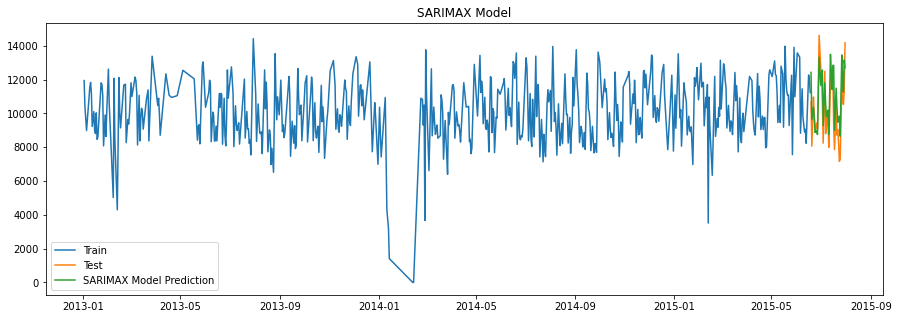

In [154]:
#Create a copy of test dataframe
store25_sarimaxmodel_pred = store25_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store25_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store25_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store25,store25_train_sarimax,store25_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store25_train_sarimax[col] = scaler25.inverse_transform(store25[col][:store25_train.shape[0]])
store25_test_sarimax[col] = scaler25.inverse_transform(store25[col][store25_train.shape[0]:])
store25_sarimaxmodel_pred[col] = scaler25.inverse_transform(store25_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store25_train_sarimax,store25_test_sarimax,store25_sarimaxmodel_pred,'SARIMAX')

In [155]:
#SARIMAX Model Evaluation.
store25_result = modelEvalution(store25_test_sarimax['Sales'],store25_sarimaxmodel_pred['Sales'],'SARIMAX Model',store25_result)
store25_result

Method     RMSE   MAPE
0    ARIMA Model  1842.36  16.14
0   SARIMA Model  2035.00  17.97
0  SARIMAX Model  1320.21  11.19

##### VARMAX MODEL

In [156]:
#Create a copy of test and train dataframe for this model.
store25_train_varmax = store25_train.copy()
store25_test_varmax = store25_test.copy()

exog = store25_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store25_model_varmax = sm.tsa.VARMAX(store25_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store25 = store25_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store25.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  559
Model:                        VARMAX(1,1)   Log Likelihood                1553.058
Date:                    Wed, 13 Apr 2022   AIC                          -3052.116
Time:                            12:26:03   BIC                          -2935.310
Sample:                                 0   HQIC                         -3006.503
                                    - 559                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             1.95, 1.16   Jarque-Bera (JB):         58.21, 40.57
Prob(Q):                        0.16, 0.28   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.10, 1.33   Skew:                     -0.16, -0.47
Prob(H) (two-sided):            0.51, 0.05   Kurtosis:                   4.55, 3.92


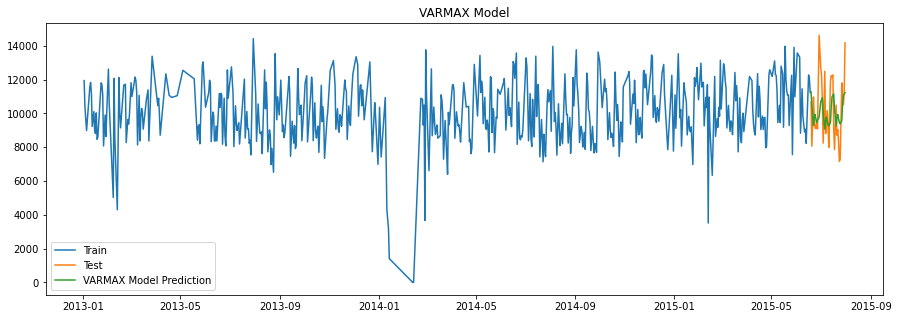

In [157]:
store25_varmaxmodel_pred = store25_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store25_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store25_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store25,store25_train_varmax,store25_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store25_train_varmax[col] = scaler25.inverse_transform(store25[col][:store25_train.shape[0]])
store25_test_varmax[col] = scaler25.inverse_transform(store25[col][store25_train.shape[0]:])
store25_varmaxmodel_pred[col] = scaler25.inverse_transform(store25_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store25_train_varmax,store25_test_varmax,store25_varmaxmodel_pred,'VARMAX')

In [158]:
#VARMAX Model Evaluation.
store25_result = modelEvalution(store25_test_varmax['Sales'],store25_varmaxmodel_pred['Sales'],'VARMAX Model',store25_result)
store25_result

Method     RMSE   MAPE
0    ARIMA Model  1842.36  16.14
0   SARIMA Model  2035.00  17.97
0  SARIMAX Model  1320.21  11.19
0   VARMAX Model  1739.86  13.60

#### Store 29

In [159]:
store29.set_index('Date',drop=True,inplace=True)
store29 = store29.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store29_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','DayOfWeek_2',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store29[col],scaler29 = standardiseColumns(store29[col])

store29.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02     29  0.720593   0.818644    0.5            1.5         d   
2013-01-03     29  0.662025   0.712429    0.5            1.5         d   
2013-01-04     29  0.732225   0.767797    0.5            1.5         d   
2013-01-05     29  0.744758   0.803955    0.5            0.5         d   
2013-01-07     29  1.173329   1.172316    1.5            0.5         d   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               2170.0       0  2013      1    2           1   
2013-01-03               2170.0       0  2013      1    3           1   
2013-01-04               2170.0       0  2013      1    4           1   
2013-01-05               2170.0       0  2013      1    5           1   
2013-01-07               2170.0       0  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.0        0.0          0.5          1.5          0.5   
2013-01-03              0.0        0.0          0.5          0.5          1.5   
2013-01-04              0.0        0.0          0.5          0.5          0.5   
2013-01-05              0.0        0.0          0.5          0.5          0.5   
2013-01-07              0.0        0.0          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 29


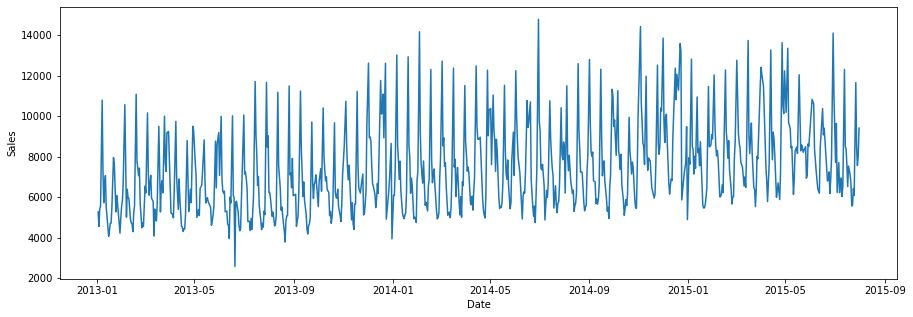

*****************************************************************************************************************************


In [160]:
plot_storeSales(29)

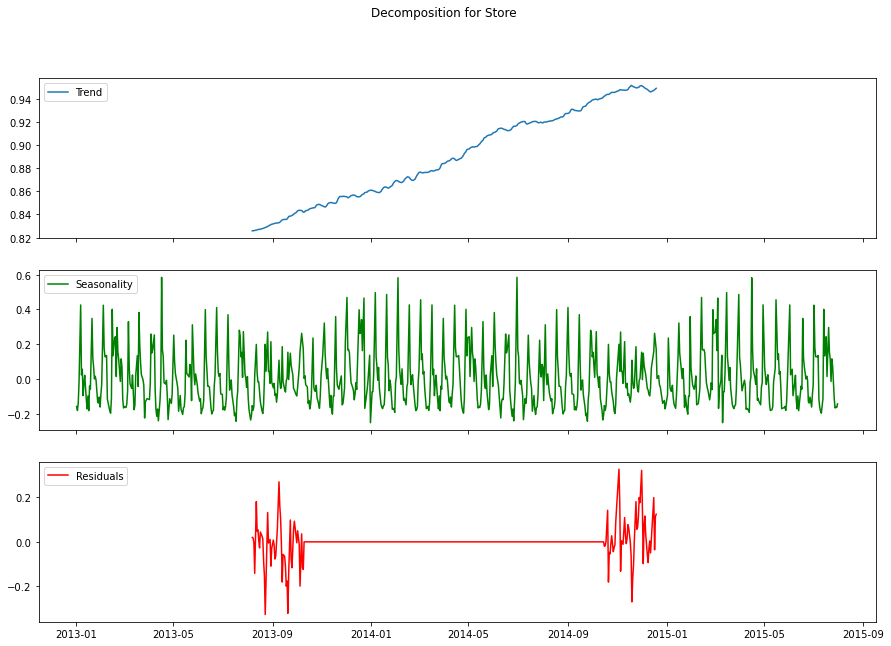

In [161]:
#Decomposition plot for the Store 29 timeseries.
plot_timeseries(store29['Sales'])

In [162]:
#Check stationarity of the sales and Customers for store 29
for column in col:
    adfuller_test(store29[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.371
 No. Lags Chosen       = 17
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.012. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5342
 No. Lags Chosen       = 16
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0072. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Lev

In [163]:
#Check cointegration for store 1
joh_model1 = coint_johansen(store29[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    153.117295  155.032252
1      1.914956    1.914956 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [164]:
#Train-Test split
store29_train,store29_test = test_train_split(store29)

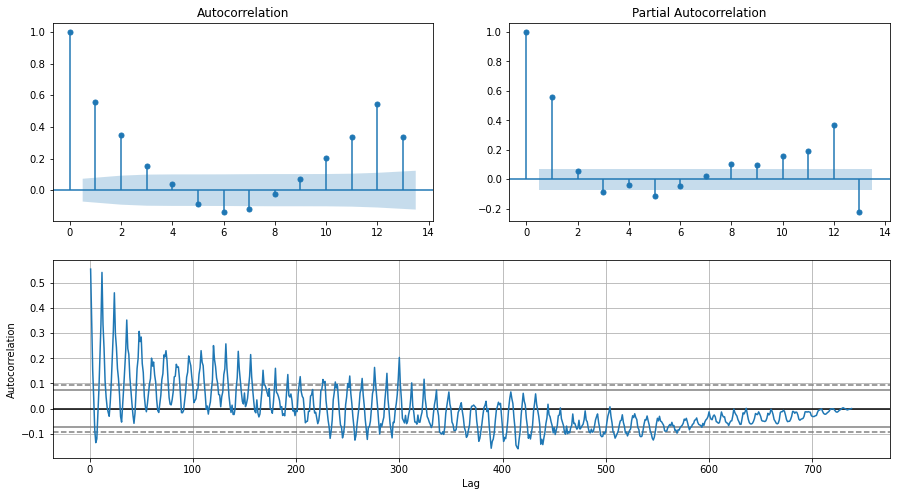

In [165]:
#Plot the ACF and PACF
plot_acf_pacf(store29_train['Sales'],0,13)

##### ARIMA MODEL

In [166]:
#Create a copy of test and train dataframe for this model.
store29_train_arima = store29_train.copy()
store29_test_arima = store29_test.copy()

#Build the ARIMA Model
store29_model_arima = ARIMA(store29_train_arima['Sales'], order=(7,0,1))
arima_model_store29 = store29_model_arima.fit()

# summary of fit model
print(arima_model_store29.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  738
Model:                 ARIMA(7, 0, 1)   Log Likelihood                 425.453
Date:                Wed, 13 Apr 2022   AIC                           -830.906
Time:                        12:26:27   BIC                           -784.866
Sample:                             0   HQIC                          -813.152
                                - 738                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8801      0.052     16.963      0.000       0.778       0.982
ar.L1          1.3818      0.046     30.100      0.000       1.292       1.472
ar.L2         -0.3345      0.081     -4.147      0.0

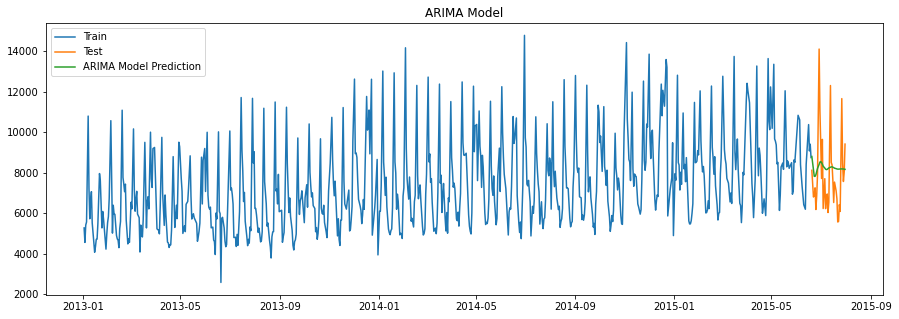

In [167]:
store29_arimamodel_pred = store29_test_arima.copy()

#Predict the sales for 6 weeks
store29_arimamodel_pred['Sales'] = predict_sales(arima_model_store29,store29_train_arima,store29_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store29_train_arima[col] = scaler29.inverse_transform(store29[col][:store29_train.shape[0]])
store29_test_arima[col] = scaler29.inverse_transform(store29[col][store29_train.shape[0]:])
store29_arimamodel_pred[col] = scaler29.inverse_transform(store29_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store29_train_arima,store29_test_arima,store29_arimamodel_pred,'ARIMA')

In [168]:
#ARIMA Model Evaluation.
store29_result = modelEvalution(store29_test_arima['Sales'],store29_arimamodel_pred['Sales'],'ARIMA Model',store29_result)
store29_result

Method     RMSE   MAPE
0  ARIMA Model  1883.13  19.29

##### SARIMA MODEL

In [169]:
#Create a copy of test and train dataframe for this model.
store29_train_sarima = store29_train.copy()
store29_test_sarima = store29_test.copy()

#SARIMA Model Building
store29_model_sarima = SARIMAX(store29_train_sarima['Sales'], order=(7, 0, 1), seasonal_order=(7, 0, 1, 12)) 
sarima_model_store29 = store29_model_sarima.fit()

# summary of fit model
print(sarima_model_store29.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  738
Model:             SARIMAX(7, 0, 1)x(7, 0, 1, 12)   Log Likelihood                 488.378
Date:                            Wed, 13 Apr 2022   AIC                           -942.756
Time:                                    12:28:26   BIC                           -864.489
Sample:                                         0   HQIC                          -912.576
                                            - 738                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4440      0.037     38.927      0.000       1.371       1.517
ar.L2         -0.4305      0.069   

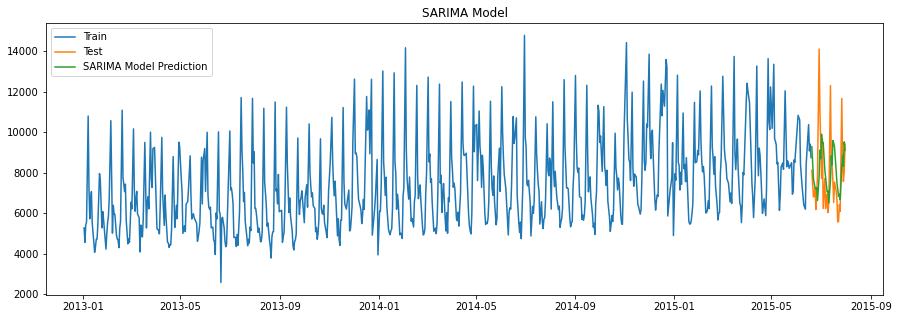

In [170]:
store29_sarimamodel_pred = store29_test_sarima.copy()

#Predict the sales for 6 weeks
store29_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store29,store29_train_sarima,store29_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store29_train_sarima[col] = scaler29.inverse_transform(store29[col][:store29_train.shape[0]])
store29_test_sarima[col] = scaler29.inverse_transform(store29[col][store29_train.shape[0]:])
store29_sarimamodel_pred[col] = scaler29.inverse_transform(store29_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store29_train_sarima,store29_test_sarima,store29_sarimamodel_pred,'SARIMA')

In [171]:
#SARIMA Model Evaluation.
store29_result = modelEvalution(store29_test_sarima['Sales'],store29_sarimamodel_pred['Sales'],'SARIMA Model',store29_result)
store29_result

Method     RMSE   MAPE
0   ARIMA Model  1883.13  19.29
0  SARIMA Model  1881.30  16.17

##### SARIMAX MODEL

In [172]:
#Create a copy of test and train dataframe for this model.
store29_train_sarimax = store29_train.copy()
store29_test_sarimax = store29_test.copy()

#SARIMAX Model Building.
exog = store29_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store29_model_sarimax = SARIMAX(store29_train_sarimax['Sales'], order=(7, 0, 1), seasonal_order=(7, 0, 1, 12),exog=exog) 
sarimax_model_store29 = store29_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store29.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  738
Model:             SARIMAX(7, 0, 1)x(7, 0, 1, 12)   Log Likelihood                 771.971
Date:                            Wed, 13 Apr 2022   AIC                          -1491.942
Time:                                    12:30:02   BIC                          -1372.239
Sample:                                         0   HQIC                         -1445.783
                                            - 738                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Promo                   0.2408      0.011     21.866      0.000       0.219       0.262
SchoolHo

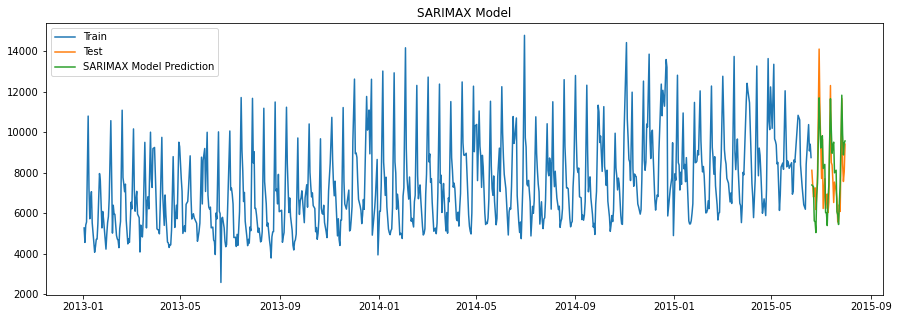

In [173]:
#Create a copy of test dataframe
store29_sarimaxmodel_pred = store29_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store29_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionDistance',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store29_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store29,store29_train_sarimax,store29_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store29_train_sarimax[col] = scaler29.inverse_transform(store29[col][:store29_train.shape[0]])
store29_test_sarimax[col] = scaler29.inverse_transform(store29[col][store29_train.shape[0]:])
store29_sarimaxmodel_pred[col] = scaler29.inverse_transform(store29_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store29_train_sarimax,store29_test_sarimax,store29_sarimaxmodel_pred,'SARIMAX')

In [174]:
#SARIMAX Model Evaluation.
store29_result = modelEvalution(store29_test_sarimax['Sales'],store29_sarimaxmodel_pred['Sales'],'SARIMAX Model',store29_result)
store29_result

Method     RMSE   MAPE
0    ARIMA Model  1883.13  19.29
0   SARIMA Model  1881.30  16.17
0  SARIMAX Model  1180.93  12.59

##### VARMAX MODEL

In [175]:
#Create a copy of test and train dataframe for this model.
store29_train_varmax = store29_train.copy()
store29_test_varmax = store29_test.copy()

exog = store29_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store29_model_varmax = sm.tsa.VARMAX(store29_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store29 = store29_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store29.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  738
Model:                        VARMAX(1,1)   Log Likelihood                2077.233
Date:                    Wed, 13 Apr 2022   AIC                          -4100.467
Time:                            12:31:10   BIC                          -3976.160
Sample:                                 0   HQIC                         -4052.533
                                    - 738                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.26, 12.00   Jarque-Bera (JB):        42.95, 148.20
Prob(Q):                        0.61, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.27, 1.47   Skew:                       0.14, 0.21
Prob(H) (two-sided):            0.06, 0.00   Kurtosis:                   4.15, 5.15


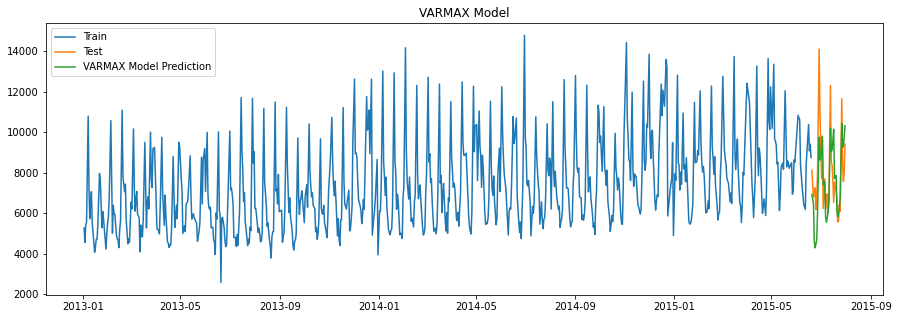

In [176]:
#Create a copy of test dataframe
store29_varmaxmodel_pred = store29_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store29_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store29_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store29,store29_train_varmax,store29_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store29_train_varmax[col] = scaler29.inverse_transform(store29[col][:store29_train.shape[0]])
store29_test_varmax[col] = scaler29.inverse_transform(store29[col][store29_train.shape[0]:])
store29_varmaxmodel_pred[col] = scaler29.inverse_transform(store29_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store29_train_varmax,store29_test_varmax,store29_varmaxmodel_pred,'VARMAX')

In [177]:
#VAR Model Evaluation.
store29_result = modelEvalution(store29_test_varmax['Sales'],store29_varmaxmodel_pred['Sales'],'VARMAX Model',store29_result)
store29_result

Method     RMSE   MAPE
0    ARIMA Model  1883.13  19.29
0   SARIMA Model  1881.30  16.17
0  SARIMAX Model  1180.93  12.59
0   VARMAX Model  1601.02  15.54

#### Store 31

In [178]:
store31.set_index('Date',drop=True,inplace=True)
store31 = store31.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store31_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','DayOfWeek_2','CompetitionOpen',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store31[col],scaler31 = standardiseColumns(store31[col])

store31.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02     31  0.695209   0.715417    0.5            1.5         d   
2013-01-03     31  0.744803   0.727033    0.5            1.5         d   
2013-01-04     31  0.795981   0.785111    0.5            1.5         d   
2013-01-05     31  0.743219   0.775607    0.5            0.5         d   
2013-01-07     31  0.965947   0.901267    1.5            0.5         d   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               9800.0       0  2013      1    2           1   
2013-01-03               9800.0       0  2013      1    3           1   
2013-01-04               9800.0       0  2013      1    4           1   
2013-01-05               9800.0       0  2013      1    5           1   
2013-01-07               9800.0       0  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5        0.0          0.5          1.5          0.5   
2013-01-03              0.5        0.0          0.5          0.5          1.5   
2013-01-04              0.5        0.0          0.5          0.5          0.5   
2013-01-05              0.5        0.0          0.5          0.5          0.5   
2013-01-07              0.5        0.0          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 31


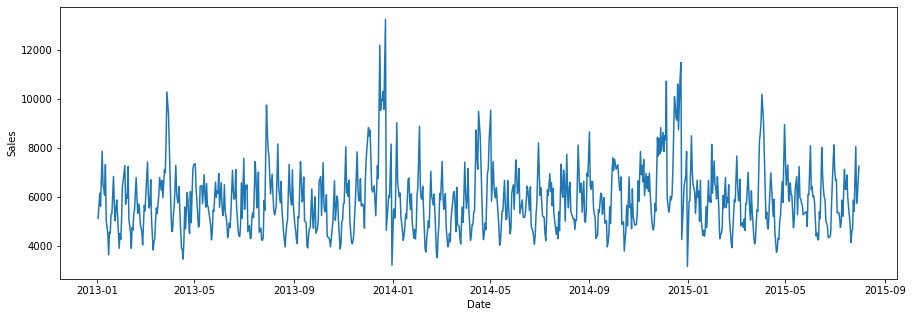

*****************************************************************************************************************************


In [179]:
plot_storeSales(31)

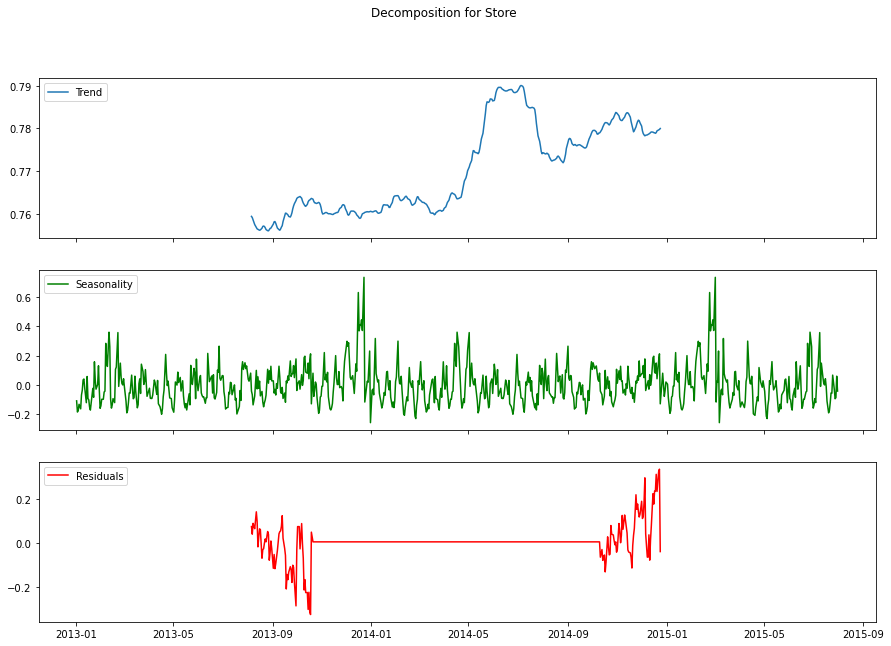

In [180]:
#Decomposition plot for the Store 31 timeseries.
plot_timeseries(store31['Sales'])

In [181]:
#Check stationarity of the sales and Customers for store 31
for column in col:
    adfuller_test(store31[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8654
 No. Lags Chosen       = 12
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.2225
 No. Lags Chosen       = 13
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [182]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store31_differenced = store31[col].diff().dropna()

In [183]:
#Check stationarity of the sales and Customers for store 31
for column in col:
    adfuller_test(store31_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1073
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.6068
 No. Lags Chosen       = 21
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [184]:
#Check cointegration for store 31
joh_model1 = coint_johansen(store31_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    512.196369  922.357511
1    410.161142  410.161142 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [185]:
#Train-Test split
store31_train,store31_test = test_train_split(store31)

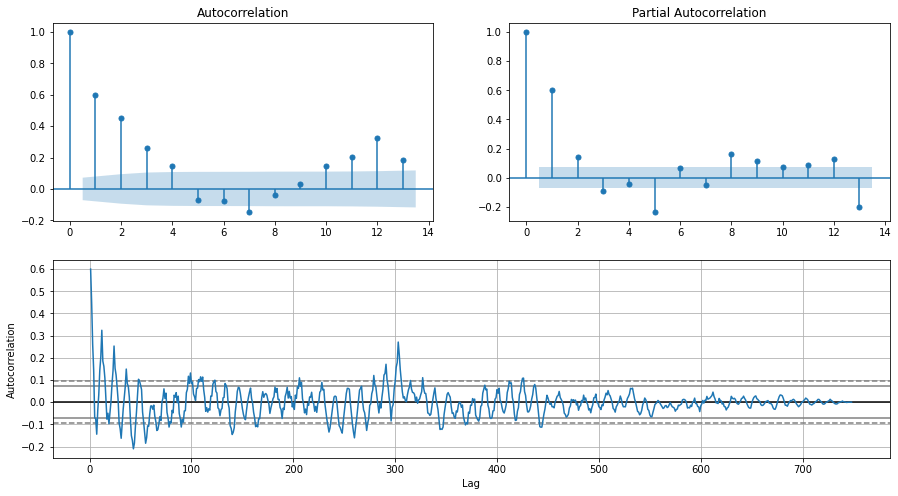

In [186]:
#Plot the ACF and PACF
plot_acf_pacf(store31_train['Sales'],0,13)

##### ARIMA MODEL

In [187]:
#Create a copy of test and train dataframe for this model.
store31_train_arima = store31_train.copy()
store31_test_arima = store31_test.copy()

#Build the ARIMA Model
store31_model_arima = ARIMA(store31_train_arima['Sales'], order=(7,1,1))
arima_model_store31 = store31_model_arima.fit()

# summary of fit model
print(arima_model_store31.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  748
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 653.849
Date:                Wed, 13 Apr 2022   AIC                          -1289.699
Time:                        12:33:09   BIC                          -1248.154
Sample:                             0   HQIC                         -1273.688
                                - 748                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3291      0.050      6.611      0.000       0.232       0.427
ar.L2          0.0590      0.045      1.304      0.192      -0.030       0.148
ar.L3         -0.0365      0.039     -0.939      0.3

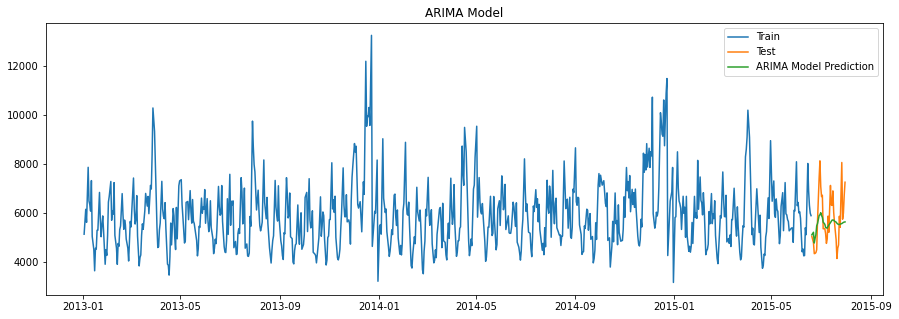

In [188]:
store31_arimamodel_pred = store31_test_arima.copy()

#Predict the sales for 6 weeks
store31_arimamodel_pred['Sales'] = predict_sales(arima_model_store31,store31_train_arima,store31_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store31_train_arima[col] = scaler31.inverse_transform(store31[col][:store31_train.shape[0]])
store31_test_arima[col] = scaler31.inverse_transform(store31[col][store31_train.shape[0]:])
store31_arimamodel_pred[col] = scaler31.inverse_transform(store31_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store31_train_arima,store31_test_arima,store31_arimamodel_pred,'ARIMA')

In [189]:
#ARIMA Model Evaluation.
store31_result = modelEvalution(store31_test_arima['Sales'],store31_arimamodel_pred['Sales'],'ARIMA Model',store31_result)
store31_result

Method    RMSE   MAPE
0  ARIMA Model  947.33  12.57

##### SARIMA MODEL

In [190]:
#Create a copy of test and train dataframe for this model.
store31_train_sarima = store31_train.copy()
store31_test_sarima = store31_test.copy()

#SARIMA Model Building
store31_model_sarima = SARIMAX(store31_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store31 = store31_model_sarima.fit()

# summary of fit model
print(sarima_model_store31.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  748
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 657.139
Date:                            Wed, 13 Apr 2022   AIC                          -1280.277
Time:                                    12:35:34   BIC                          -1202.080
Sample:                                         0   HQIC                         -1250.118
                                            - 748                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5450      0.032     16.923      0.000       0.482       0.608
ar.L2          0.1330      0.044   

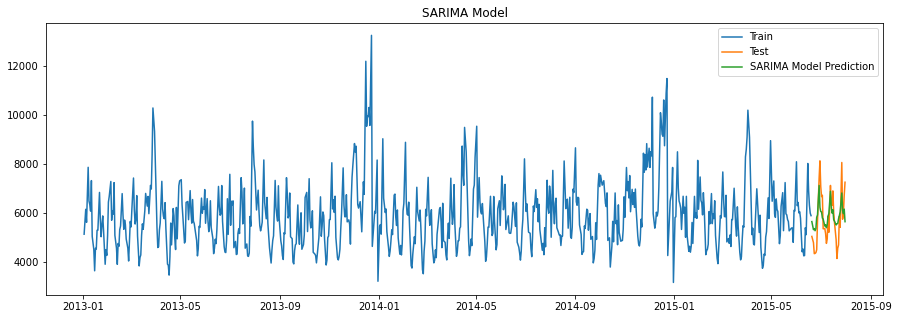

In [191]:
store31_sarimamodel_pred = store31_test_sarima.copy()

#Predict the sales for 6 weeks
store31_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store31,store31_train_sarima,store31_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store31_train_sarima[col] = scaler31.inverse_transform(store31[col][:store31_train.shape[0]])
store31_test_sarima[col] = scaler31.inverse_transform(store31[col][store31_train.shape[0]:])
store31_sarimamodel_pred[col] = scaler31.inverse_transform(store31_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store31_train_sarima,store31_test_sarima,store31_sarimamodel_pred,'SARIMA')

In [192]:
#SARIMA Model Evaluation.
store31_result = modelEvalution(store31_test_sarima['Sales'],store31_sarimamodel_pred['Sales'],'SARIMA Model',store31_result)
store31_result

Method    RMSE   MAPE
0   ARIMA Model  947.33  12.57
0  SARIMA Model  806.19  11.96

##### SARIMAX MODEL

In [193]:
#Create a copy of test and train dataframe for this model.
store31_train_sarimax = store31_train.copy()
store31_test_sarimax = store31_test.copy()

#SARIMAX Model Building.
exog = store31_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionOpen',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store31_model_sarimax = SARIMAX(store31_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store31 = store31_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store31.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  748
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 809.805
Date:                            Wed, 13 Apr 2022   AIC                          -1567.610
Time:                                    12:40:16   BIC                          -1448.014
Sample:                                         0   HQIC                         -1521.484
                                            - 748                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.1795      0.011     16.579      0.000       0.158       0.201
SchoolHoliday       

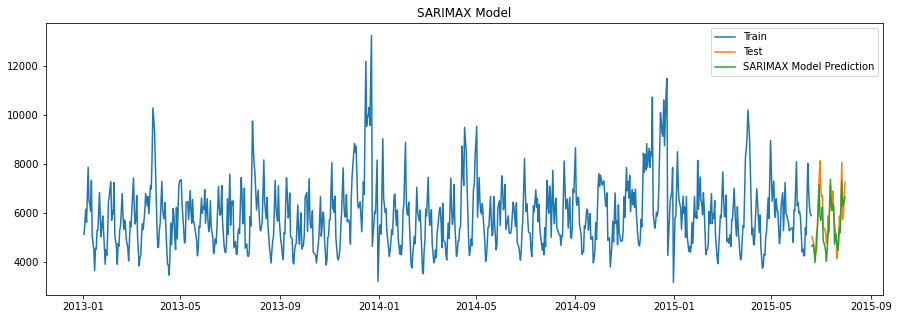

In [194]:
#Create a copy of test dataframe
store31_sarimaxmodel_pred = store31_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store31_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store31_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store31,store31_train_sarimax,store31_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store31_train_sarimax[col] = scaler31.inverse_transform(store31[col][:store31_train.shape[0]])
store31_test_sarimax[col] = scaler31.inverse_transform(store31[col][store31_train.shape[0]:])
store31_sarimaxmodel_pred[col] = scaler31.inverse_transform(store31_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store31_train_sarimax,store31_test_sarimax,store31_sarimaxmodel_pred,'SARIMAX')

In [195]:
#SARIMAX Model Evaluation.
store31_result = modelEvalution(store31_test_sarimax['Sales'],store31_sarimaxmodel_pred['Sales'],'SARIMAX Model',store31_result)
store31_result

Method    RMSE   MAPE
0    ARIMA Model  947.33  12.57
0   SARIMA Model  806.19  11.96
0  SARIMAX Model  637.82   8.23

##### VARMAX MODEL

In [196]:
#Create a copy of test and train dataframe for this model.
store31_train_varmax = store31_train.copy()
store31_test_varmax = store31_test.copy()

exog = store31_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store31_model_varmax = sm.tsa.VARMAX(store31_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store31 = store31_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store31.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  748
Model:                        VARMAX(1,1)   Log Likelihood                2395.099
Date:                    Wed, 13 Apr 2022   AIC                          -4732.197
Time:                            12:41:22   BIC                          -4598.293
Sample:                                 0   HQIC                         -4680.595
                                    - 748                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.25, 8.06   Jarque-Bera (JB):      1634.62, 300.17
Prob(Q):                        0.61, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.88, 1.04   Skew:                       0.30, 0.15
Prob(H) (two-sided):            0.00, 0.73   Kurtosis:                  10.22, 6.09


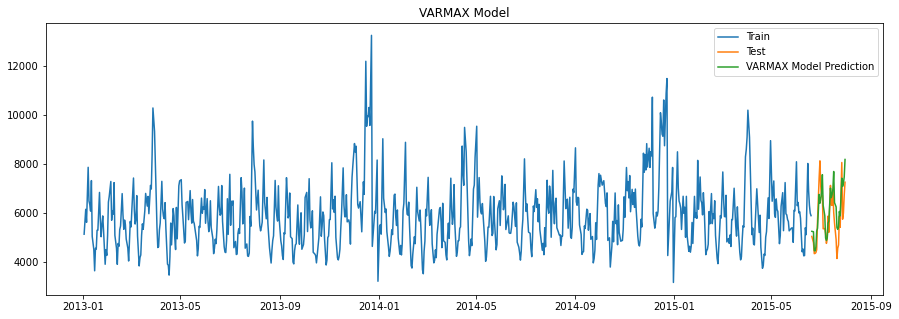

In [197]:
#Create a copy of test dataframe
store31_varmaxmodel_pred = store31_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store31_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','CompetitionOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store31_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store31,store31_train_varmax,store31_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store31_train_varmax[col] = scaler31.inverse_transform(store31[col][:store31_train.shape[0]])
store31_test_varmax[col] = scaler31.inverse_transform(store31[col][store31_train.shape[0]:])
store31_varmaxmodel_pred[col] = scaler31.inverse_transform(store31_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store31_train_varmax,store31_test_varmax,store31_varmaxmodel_pred,'VARMAX')

In [198]:
#VARMAX Model Evaluation.
store31_result = modelEvalution(store31_test_varmax['Sales'],store31_varmaxmodel_pred['Sales'],'VARMAX Model',store31_result)
store31_result

Method    RMSE   MAPE
0    ARIMA Model  947.33  12.57
0   SARIMA Model  806.19  11.96
0  SARIMAX Model  637.82   8.23
0   VARMAX Model  758.02  10.63

#### Store 46

In [199]:
store46.set_index('Date',drop=True,inplace=True)
store46 = store46.sort_index(axis=0)

#create a dataframe to store the results of all the result of models predictions
store46_result = pd.DataFrame()

#Standardize the sales and number of customers variables
col = ['Sales','Customers','Promo','SchoolHoliday','DayOfWeek_2','CompetitionOpen','PromoOpen',
       'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']
store46[col],scaler46 = standardiseColumns(store46[col])

store46.head()

Store     Sales  Customers  Promo  SchoolHoliday StoreType  \
Date                                                                     
2013-01-02     46  0.674785   0.801370    0.5            1.5         c   
2013-01-03     46  0.690920   0.761644    0.5            1.5         c   
2013-01-04     46  0.685709   0.783562    0.5            1.5         c   
2013-01-05     46  0.758168   0.895890    0.5            0.5         c   
2013-01-07     46  1.052816   1.134247    1.5            0.5         c   

            CompetitionDistance  Promo2  Year  Month  Day  WeekOfYear  \
Date                                                                    
2013-01-02               1200.0       1  2013      1    2           1   
2013-01-03               1200.0       1  2013      1    3           1   
2013-01-04               1200.0       1  2013      1    4           1   
2013-01-05               1200.0       1  2013      1    5           1   
2013-01-07               1200.0       1  2013      1    7           2   

            CompetitionOpen  PromoOpen  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  \
Date                                                                            
2013-01-02              0.5   0.500000          0.5          1.5          0.5   
2013-01-03              0.5   0.500000          0.5          0.5          1.5   
2013-01-04              0.5   0.500000          0.5          0.5          0.5   
2013-01-05              0.5   0.500000          0.5          0.5          0.5   
2013-01-07              0.5   0.507937          0.5          0.5          0.5   

            DayOfWeek_5  DayOfWeek_6  
Date                                  
2013-01-02          0.5          0.5  
2013-01-03          0.5          0.5  
2013-01-04          1.5          0.5  
2013-01-05          0.5          1.5  
2013-01-07          0.5          0.5

Store 46


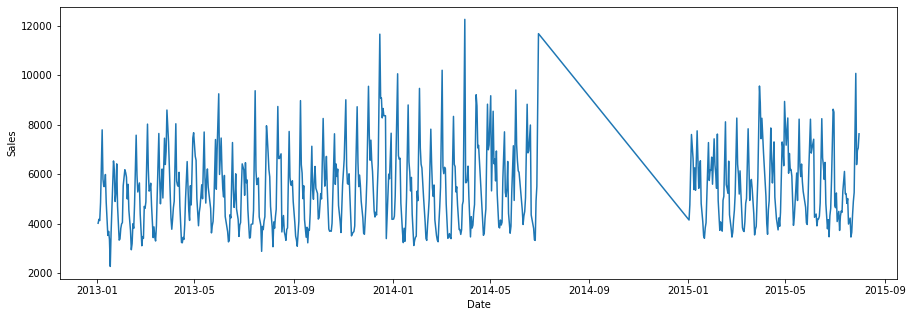

*****************************************************************************************************************************


In [200]:
plot_storeSales(46)

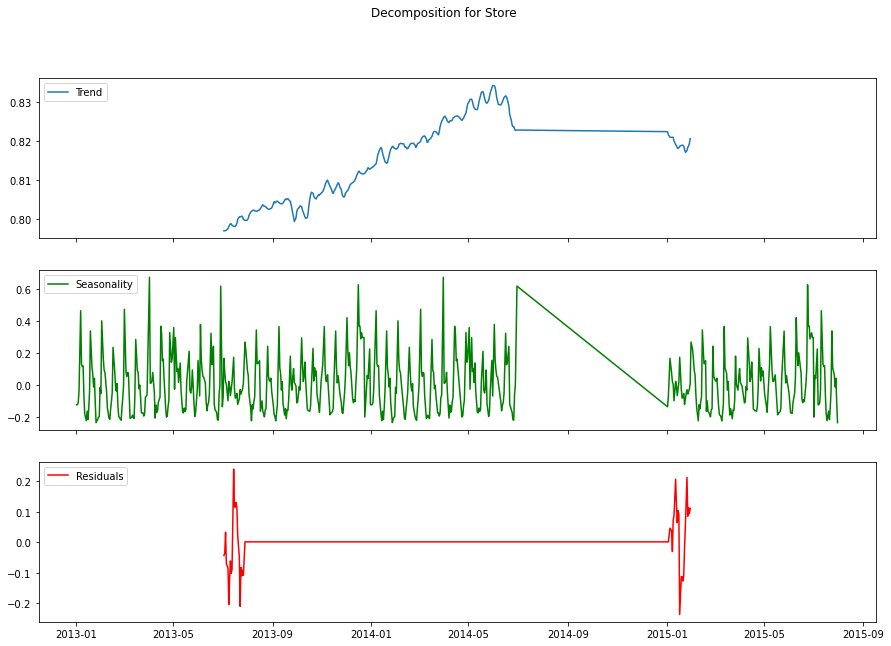

In [201]:
#Plot the decomposition which shows the trend, Seasonality and residuals in sales for store.
def plot_timeseries1(sales):
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=300)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    plt.suptitle('Decomposition for Store')
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')
#Decomposition plot for the Store 46 timeseries.
plot_timeseries1(store46['Sales'])

In [202]:
#Check stationarity of the sales and Customers for store 46
for column in col:
    adfuller_test(store46[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2754
 No. Lags Chosen       = 12
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5649
 No. Lags Chosen       = 13
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [203]:
# 1st difference as CompetitionOpen and PromoOpen are not stationary.
store46_differenced = store46[col].diff().dropna()

In [204]:
#Check stationarity of the sales and Customers for store 46
for column in col:
    adfuller_test(store46_differenced[column],name=column)
    print('\n')

    Augmented Dickey-Fuller Test on "Sales" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.5491
 No. Lags Chosen       = 11
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Customers" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.9836
 No. Lags Chosen       = 11
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Promo" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [205]:
#Check cointegration for store 1
joh_model1 = coint_johansen(store46_differenced[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    427.533662  772.924988
1    345.391327  345.391327 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [206]:
#Train-Test split
store46_train,store46_test = test_train_split(store46)

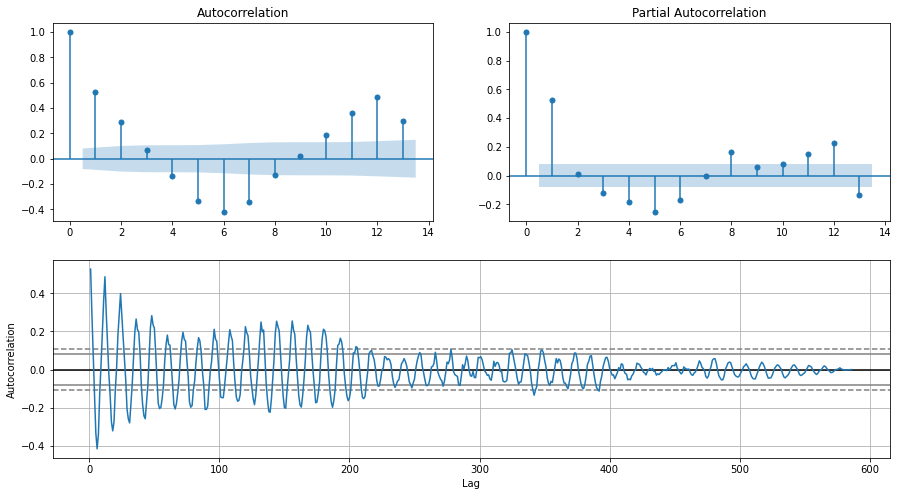

In [207]:
#Plot the ACF and PACF
plot_acf_pacf(store46_train['Sales'],0,13)

##### ARIMA MODEL

In [208]:
#Create a copy of test and train dataframe for this model.
store46_train_arima = store46_train.copy()
store46_test_arima = store46_test.copy()

#Build the ARIMA Model
store46_model_arima = ARIMA(store46_train_arima['Sales'], order=(7,1,1))
arima_model_store46 = store46_model_arima.fit()

# summary of fit model
print(arima_model_store46.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  586
Model:                 ARIMA(7, 1, 1)   Log Likelihood                 391.395
Date:                Wed, 13 Apr 2022   AIC                           -764.790
Time:                        13:03:31   BIC                           -725.446
Sample:                             0   HQIC                          -749.457
                                - 586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2894      0.041      6.977      0.000       0.208       0.371
ar.L2          0.0231      0.049      0.476      0.634      -0.072       0.118
ar.L3         -0.0217      0.050     -0.431      0.6

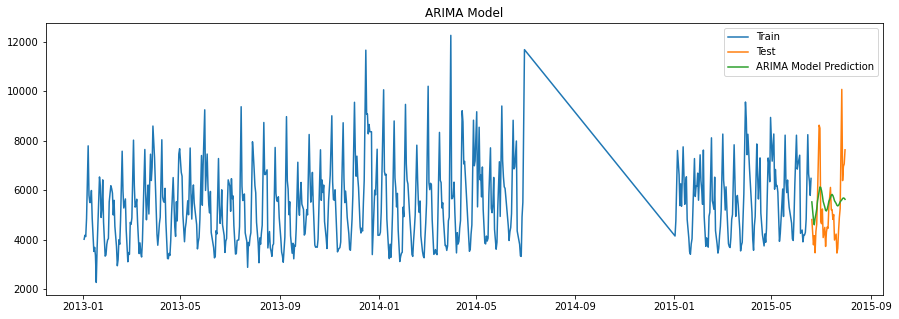

In [209]:
store46_arimamodel_pred = store46_test_arima.copy()

#Predict the sales for 6 weeks
store46_arimamodel_pred['Sales'] = predict_sales(arima_model_store46,store46_train_arima,store46_test_arima)

#Inverse the dataframe for sales visualization and model evaluation.
store46_train_arima[col] = scaler46.inverse_transform(store46[col][:store46_train.shape[0]])
store46_test_arima[col] = scaler46.inverse_transform(store46[col][store46_train.shape[0]:])
store46_arimamodel_pred[col] = scaler46.inverse_transform(store46_arimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store46_train_arima,store46_test_arima,store46_arimamodel_pred,'ARIMA')

In [210]:
#ARIMA Model Evaluation.
store46_result = modelEvalution(store46_test_arima['Sales'],store46_arimamodel_pred['Sales'],'ARIMA Model',store46_result)
store46_result

Method     RMSE   MAPE
0  ARIMA Model  1402.42  22.26

##### SARIMA MODEL

In [211]:
#Create a copy of test and train dataframe for this model.
store46_train_sarima = store46_train.copy()
store46_test_sarima = store46_test.copy()

#SARIMA Model Building
store46_model_sarima = SARIMAX(store46_train_sarima['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12)) 
sarima_model_store46 = store46_model_sarima.fit()

# summary of fit model
print(sarima_model_store46.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  586
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 397.521
Date:                            Wed, 13 Apr 2022   AIC                           -761.042
Time:                                    13:05:45   BIC                           -687.077
Sample:                                         0   HQIC                          -732.189
                                            - 586                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3387      0.035      9.619      0.000       0.270       0.408
ar.L2          0.0694      0.045   

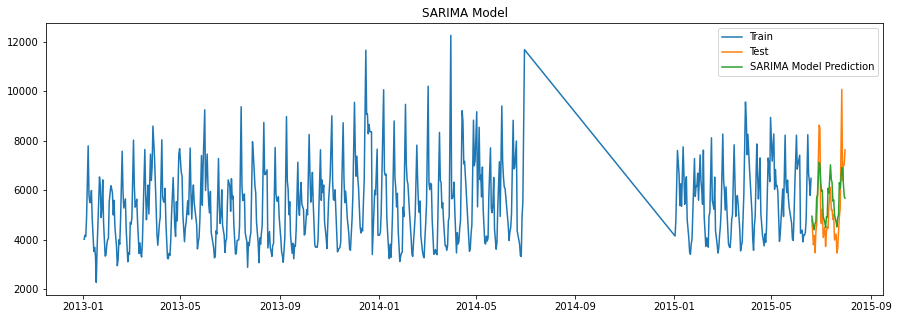

In [212]:
store46_sarimamodel_pred = store46_test_sarima.copy()

#Predict the sales for 6 weeks
store46_sarimamodel_pred['Sales'] = predict_sales(sarima_model_store46,store46_train_sarima,store46_test_sarima)

#Inverse the dataframe for sales visualization and model evaluation.
store46_train_sarima[col] = scaler46.inverse_transform(store46[col][:store46_train.shape[0]])
store46_test_sarima[col] = scaler46.inverse_transform(store46[col][store46_train.shape[0]:])
store46_sarimamodel_pred[col] = scaler46.inverse_transform(store46_sarimamodel_pred[col])

#plot the the prediction
plot_predictiongrah(store46_train_sarima,store46_test_sarima,store46_sarimamodel_pred,'SARIMA')

In [213]:
#SARIMA Model Evaluation.
store46_result = modelEvalution(store46_test_sarima['Sales'],store46_sarimamodel_pred['Sales'],'SARIMA Model',store46_result)
store46_result

Method     RMSE   MAPE
0   ARIMA Model  1402.42  22.26
0  SARIMA Model  1117.51  18.39

##### SARIMAX MODEL

In [214]:
#Create a copy of test and train dataframe for this model.
store46_train_sarimax = store46_train.copy()
store46_test_sarimax = store46_test.copy()

#SARIMAX Model Building.
exog = store46_train_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','PromoOpen',
                             'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store46_model_sarimax = SARIMAX(store46_train_sarimax['Sales'], order=(7, 1, 1), seasonal_order=(7, 1, 1, 12),exog=exog) 
sarimax_model_store46 = store46_model_sarimax.fit()

# summary of fit model
print(sarimax_model_store46.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  586
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood                 651.782
Date:                            Wed, 13 Apr 2022   AIC                          -1251.564
Time:                                    13:10:27   BIC                          -1138.441
Sample:                                         0   HQIC                         -1207.437
                                            - 586                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Promo               0.2843      0.012     24.223      0.000       0.261       0.307
SchoolHoliday       

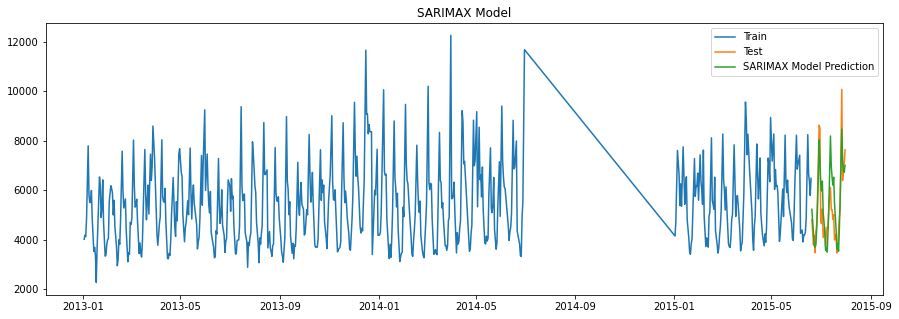

In [215]:
#Create a copy of test dataframe
store46_sarimaxmodel_pred = store46_test_sarimax.copy()

#Predict the sales for 6 weeks
exog = store46_test_sarimax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','PromoOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store46_sarimaxmodel_pred['Sales'] = predict_sales(sarimax_model_store46,store46_train_sarimax,store46_test_sarimax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store46_train_sarimax[col] = scaler46.inverse_transform(store46[col][:store46_train.shape[0]])
store46_test_sarimax[col] = scaler46.inverse_transform(store46[col][store46_train.shape[0]:])
store46_sarimaxmodel_pred[col] = scaler46.inverse_transform(store46_sarimaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store46_train_sarimax,store46_test_sarimax,store46_sarimaxmodel_pred,'SARIMAX')

In [216]:
#SARIMAX Model Evaluation.
store46_result = modelEvalution(store46_test_sarimax['Sales'],store46_sarimaxmodel_pred['Sales'],'SARIMAX Model',store46_result)
store46_result

Method     RMSE   MAPE
0    ARIMA Model  1402.42  22.26
0   SARIMA Model  1117.51  18.39
0  SARIMAX Model   942.12  14.57

##### VARMAX MODEL

In [217]:
#Create a copy of test and train dataframe for this model.
store46_train_varmax = store46_train.copy()
store46_test_varmax = store46_test.copy()

exog = store46_train_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','PromoOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]

store46_model_varmax = sm.tsa.VARMAX(store46_train_varmax[['Sales', 'Customers']].astype('float64'), order=(1,1), trend='n', exog=exog)
varmax_model_store46 = store46_model_varmax.fit(maxiter=1000, disp=False)
print(varmax_model_store46.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  586
Model:                        VARMAX(1,1)   Log Likelihood                1673.650
Date:                    Wed, 13 Apr 2022   AIC                          -3289.299
Time:                            13:11:27   BIC                          -3162.473
Sample:                                 0   HQIC                         -3239.876
                                    - 586                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             2.74, 6.42   Jarque-Bera (JB):       758.32, 393.52
Prob(Q):                        0.10, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.42, 1.36   Skew:                       1.14, 0.50
Prob(H) (two-sided):            0.02, 0.03   Kurtosis:                   8.08, 6.89


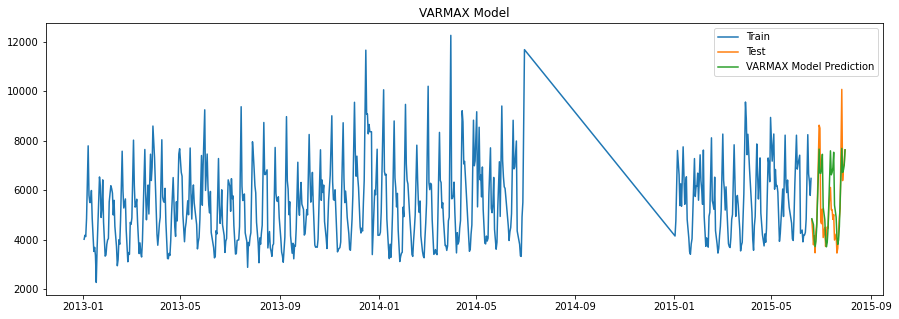

In [218]:
#Create a copy of test dataframe
store46_varmaxmodel_pred = store46_test_varmax.copy()

#Predict the sales for 6 weeks
exog = store46_test_varmax[['Promo','SchoolHoliday','CompetitionOpen','DayOfWeek_2','PromoOpen',
                            'DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6']]
store46_varmaxmodel_pred[['Sales','Customers']] = predict_sales(varmax_model_store46,store46_train_varmax,store46_test_varmax,exogeneousVariable=exog)

#Inverse the dataframe for sales visualization and model evaluation.
store46_train_varmax[col] = scaler46.inverse_transform(store46[col][:store46_train.shape[0]])
store46_test_varmax[col] = scaler46.inverse_transform(store46[col][store46_train.shape[0]:])
store46_varmaxmodel_pred[col] = scaler46.inverse_transform(store46_varmaxmodel_pred[col])

#plot the the prediction
plot_predictiongrah(store46_train_varmax,store46_test_varmax,store46_varmaxmodel_pred,'VARMAX')

In [219]:
#VARMAX Model Evaluation.
store46_result = modelEvalution(store46_test_varmax['Sales'],store46_varmaxmodel_pred['Sales'],'VARMAX Model',store46_result)
store46_result

Method     RMSE   MAPE
0    ARIMA Model  1402.42  22.26
0   SARIMA Model  1117.51  18.39
0  SARIMAX Model   942.12  14.57
0   VARMAX Model  1147.35  16.42

### Model Evaluation

In [220]:
#Create a function that draws below plots to observe the best fitted model on the time seried data.

'''Residual Line Plot - > Look at the residuals over time as a line plot. We would not expect any trend 
   and cyclic behavior if the model is fitted well,the plot should be random around the value of 0.'''


'''Residual Histogram and Density Plots - > These plots can be used to better understand the distribution of errors 
   We would expect the forecast errors to be normally distributed around a zero mean.Plots can help discover skews
   in this distribution. We can use both histograms and density plots to better understand the distribution of residual
   errors.'''


'''Residual Autocorrelation Plot -> Autocorrelation explains the strength of the relationship between observation
   and observations at prior time steps. We would not expect there to be any correlation left between the residuals.'''


'''Residual Q-Q Plot - > This is also called a quantile plot, can be used to check the normality of the distribution
   of residuals. The values are ordered and compared to an idealized Gaussian distribution on a scatter plot.
   We expect all the dots to overlap the diagonal line to confirm a complete match between the two distributions.'''


def evaluation(store,bestModel):
    model_name = bestModel['Method'][0].split(' ')[0].lower()
    test_val = globals()[store+'_test_'+model_name]['Sales']
    pred_val = globals()[store+'_'+model_name+'model_pred']['Sales']
    residuals = test_val - pred_val
    
    plt.figure(figsize=(20,10),constrained_layout = True)
    
    plt.subplot(2,2,1)
    plt.title("Residual Line Plot",fontweight ='bold',fontsize = 15)
    residuals.plot()
    
    plt.subplot(2,2,2)
    plt.title("Residual Histogram Plot",fontweight ='bold',fontsize = 15)
    residuals.hist()
    
    plt.subplot(2,2,3)
    plt.title("Residual Density Plot",fontweight ='bold',fontsize = 15)           
    residuals.plot(kind='kde')
    
    plt.subplot(2,2,4)
    autocorrelation_plot(residuals)
    plt.title("Residual Autocorrelation Plot",fontweight ='bold',fontsize = 15)
                
    
    qqresiduals = np.array(residuals)
    sm.qqplot(qqresiduals, line='r')
    plt.title("Residual Q-Q Plot",fontweight ='bold',fontsize = 10)
    
    plt.tight_layout()
    plt.show()

##### Store 1

In [221]:
#Best Model to predict he sales for next 6 weeks for store 1.
best_model_store1 = store1_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 1")
best_model_store1

The Best fitted model for store 1


Method    RMSE  MAPE
0  VARMAX Model  398.32  7.13

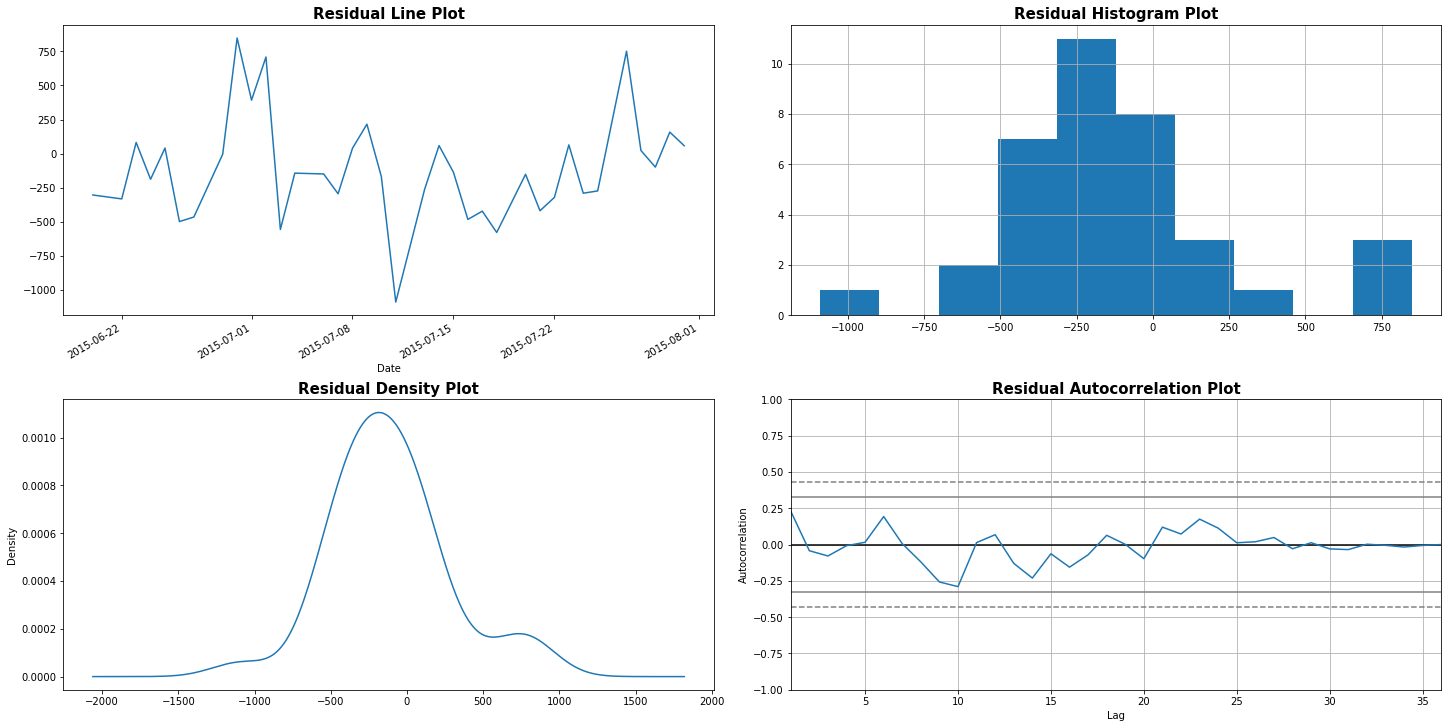

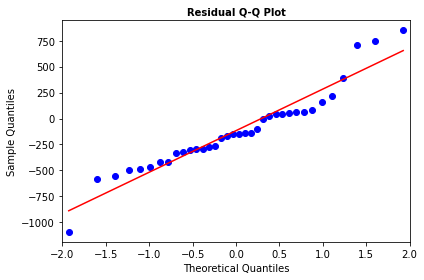

In [222]:
#Evaluation of the Best Model for Store 1.
evaluation('store1',best_model_store1)

##### Store 3

In [223]:
#Best Model to predict he sales for next 6 weeks for store 3.
best_model_store3 = store3_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 3")
best_model_store3

The Best fitted model for store 3


Method     RMSE   MAPE
0  SARIMAX Model  1149.76  12.65

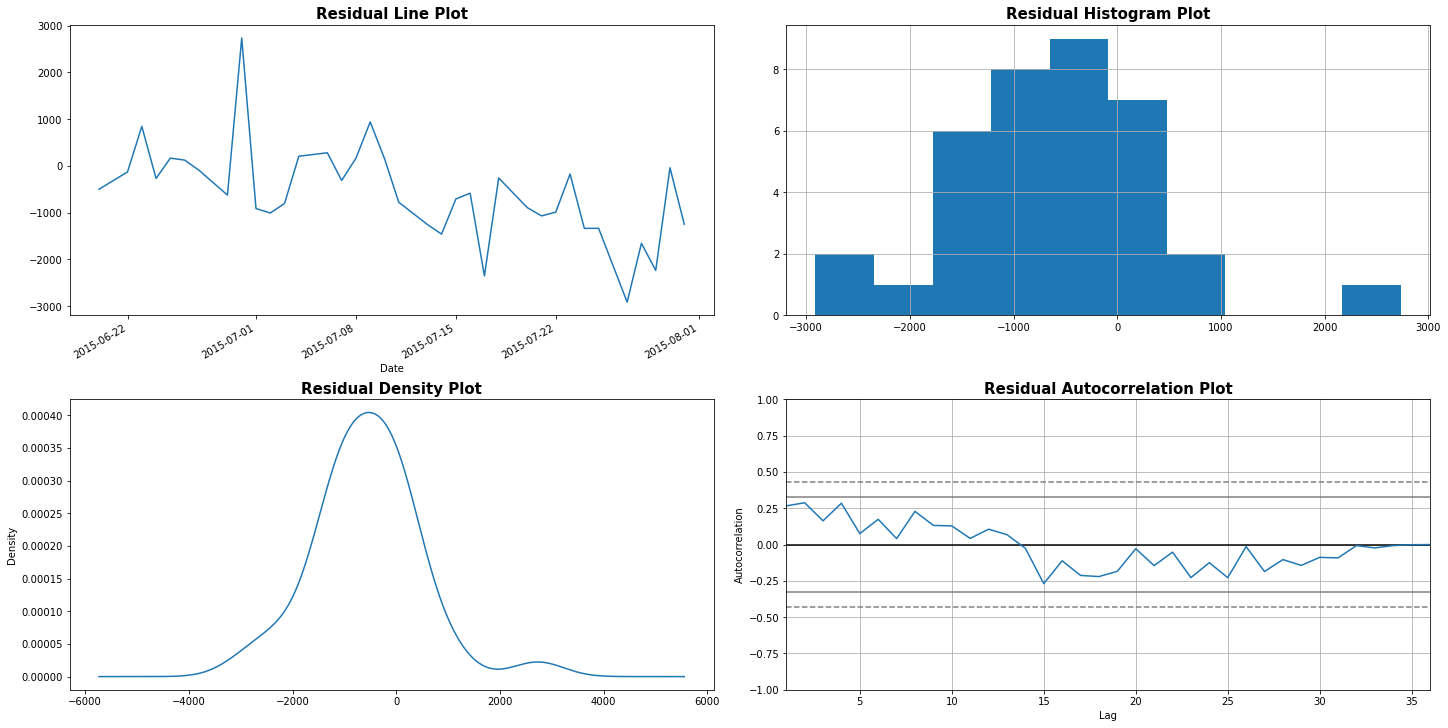

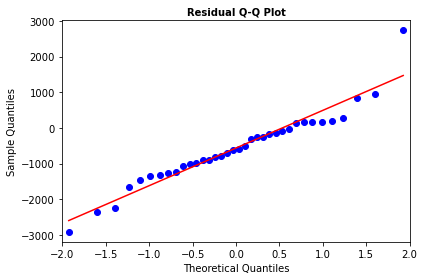

In [224]:
#Evaluation of the Best Model for Store 3.
evaluation('store3',best_model_store3)

##### Store 8

In [225]:
#Best Model to predict he sales for next 6 weeks for store 8.
best_model_store8 = store8_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 8")
best_model_store8

The Best fitted model for store 8


Method    RMSE   MAPE
0  SARIMAX Model  818.26  11.32

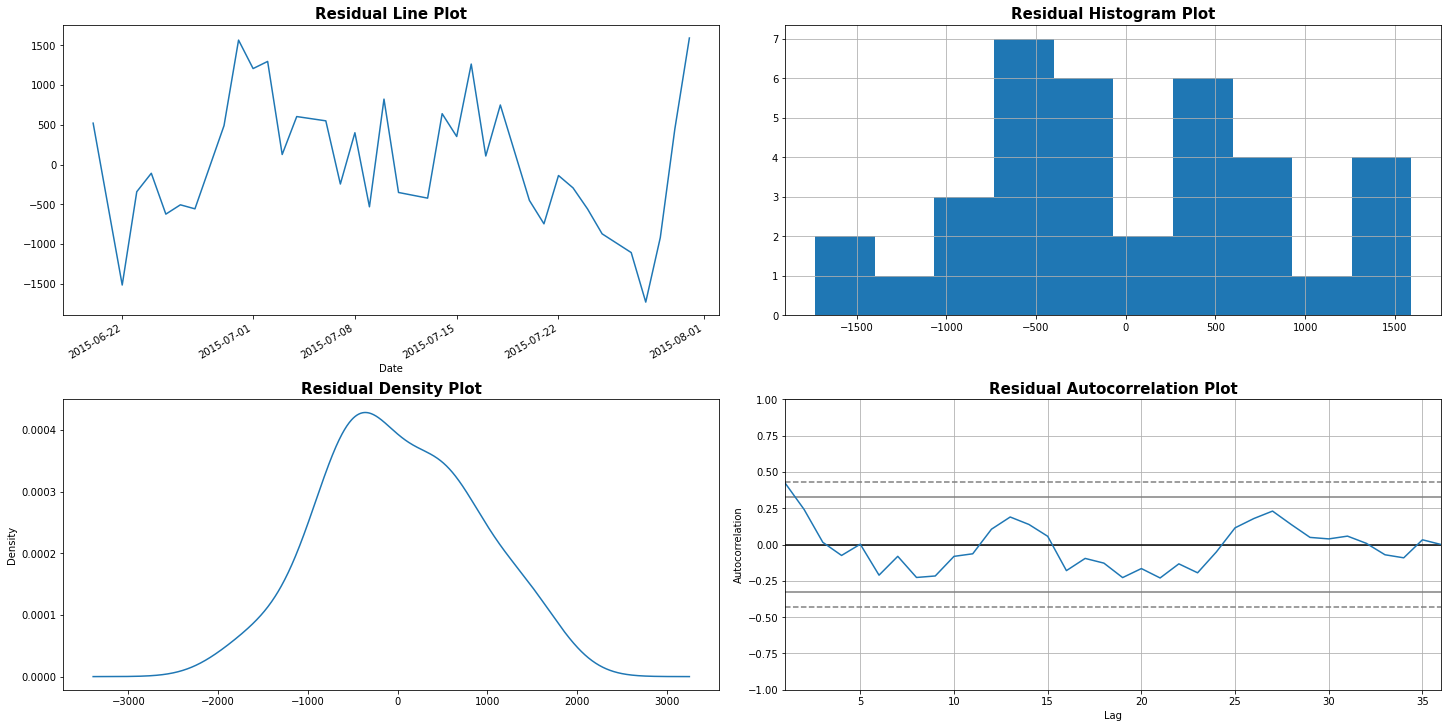

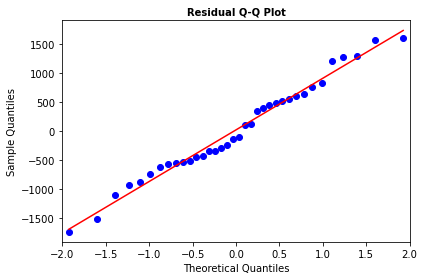

In [226]:
#Evaluation of the Best Model for Store 8.
evaluation('store8',best_model_store8)

##### Store 9

In [227]:
#Best Model to predict he sales for next 6 weeks for store 9.
best_model_store9 = store9_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 9")
best_model_store9

The Best fitted model for store 9


Method     RMSE   MAPE
0  SARIMAX Model  1125.64  13.42

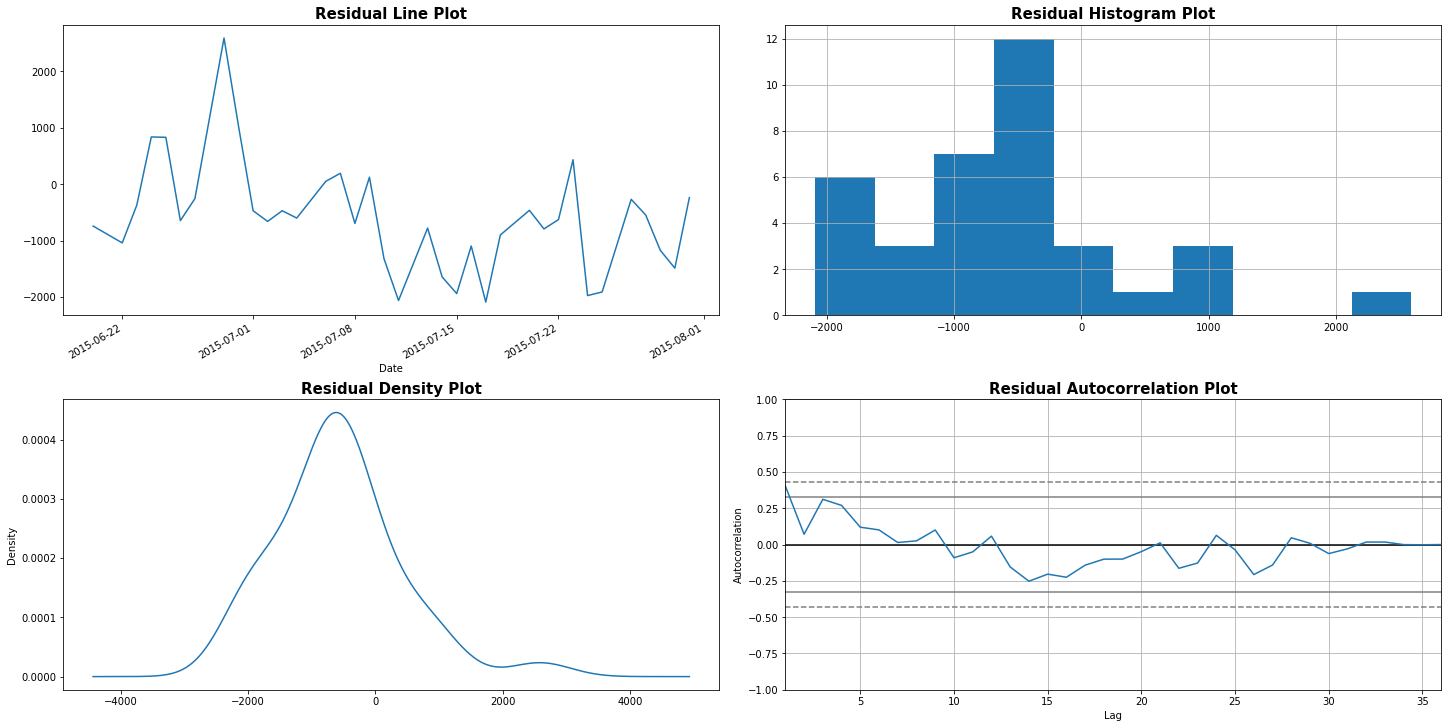

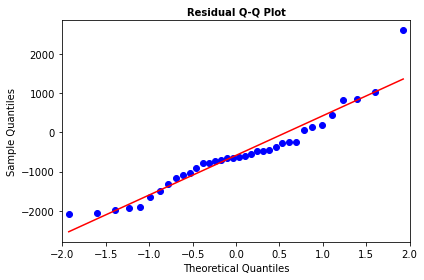

In [228]:
#Evaluation of the Best Model for Store 9.
evaluation('store9',best_model_store9)

##### Store 13

In [229]:
#Best Model to predict he sales for next 6 weeks for store 13.
best_model_store13 = store13_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 13")
best_model_store13

The Best fitted model for store 13


Method     RMSE   MAPE
0  SARIMAX Model  1240.68  14.81

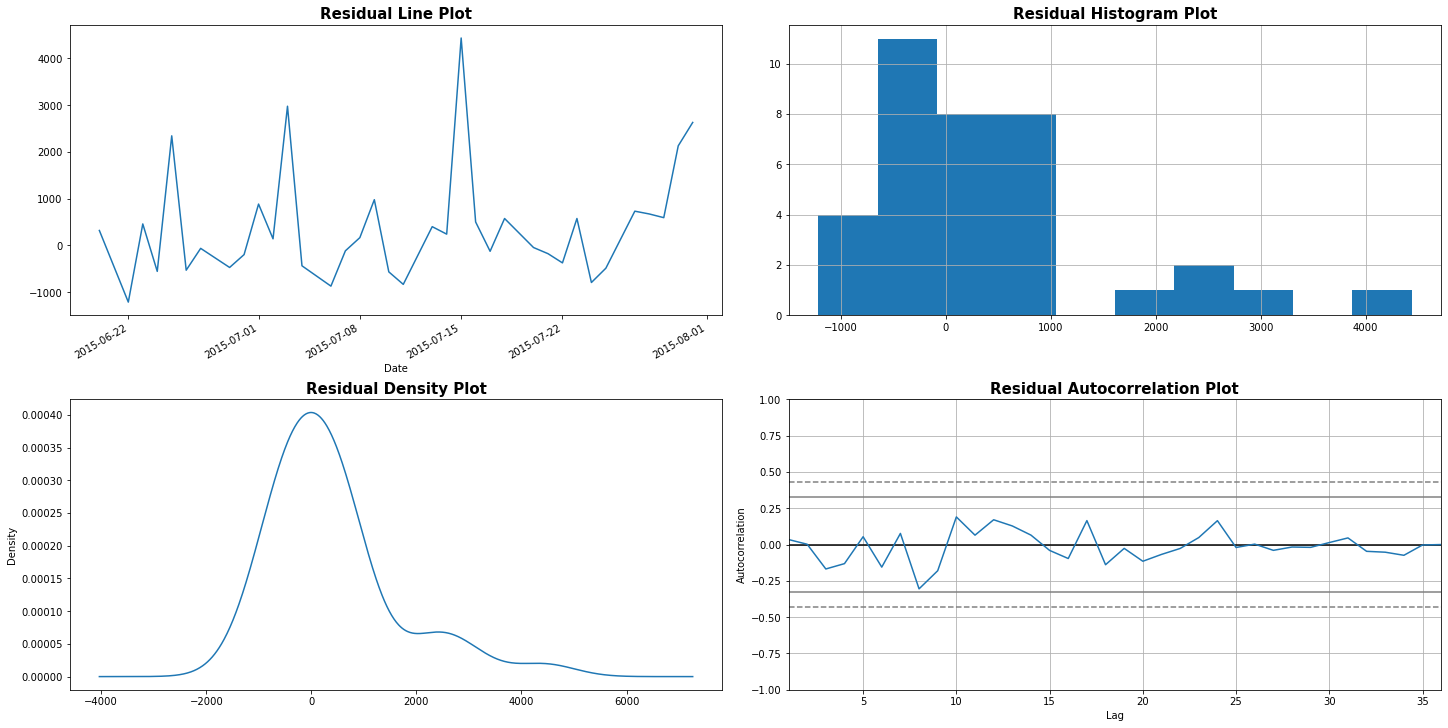

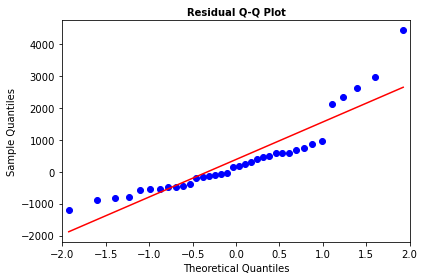

In [230]:
#Evaluation of the Best Model for Store 13.
evaluation('store13',best_model_store13)

##### Store 25

In [231]:
#Best Model to predict he sales for next 6 weeks for store 25.
best_model_store25 = store25_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 25")
best_model_store25

The Best fitted model for store 25


Method     RMSE   MAPE
0  SARIMAX Model  1320.21  11.19

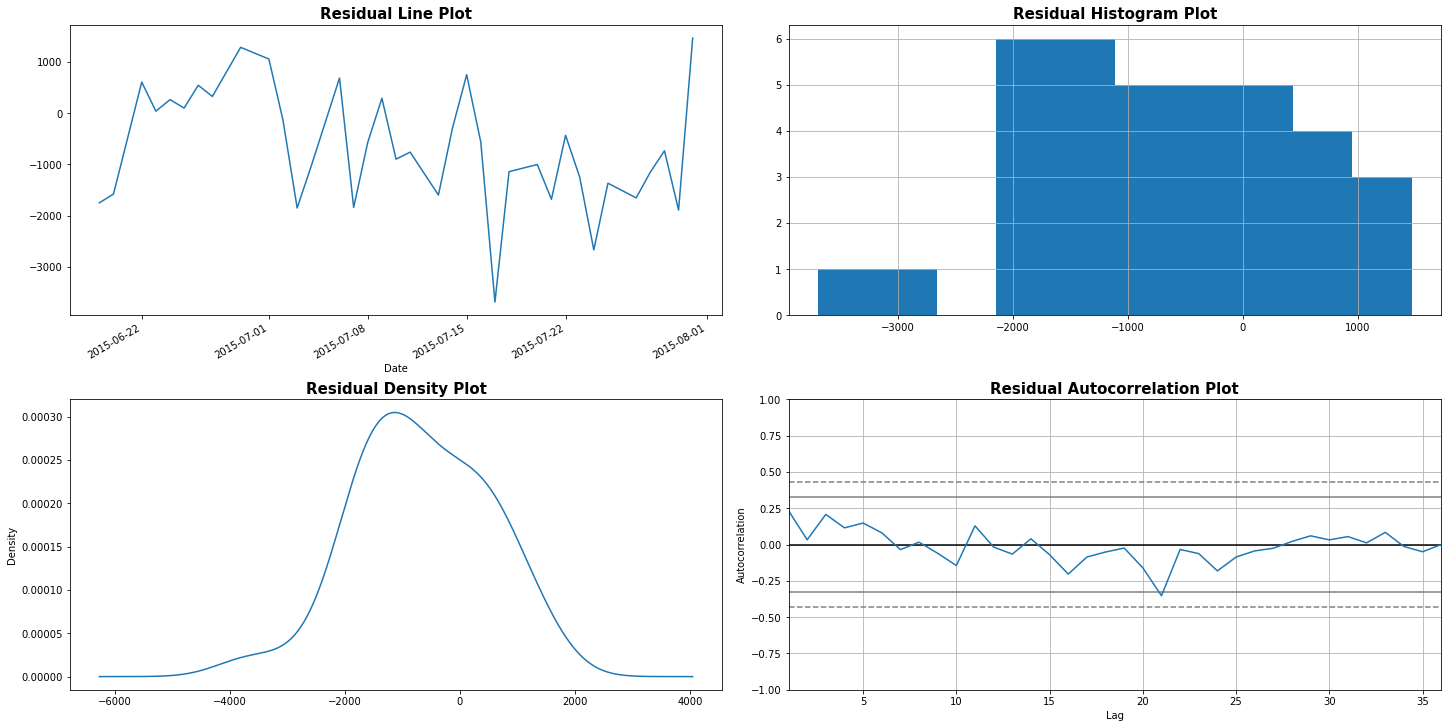

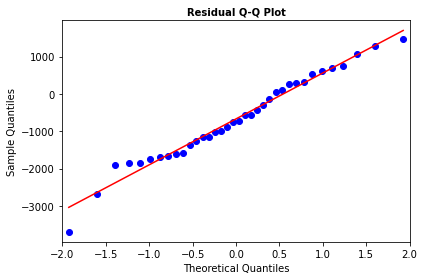

In [232]:
#Evaluation of the Best Model for Store 25.
evaluation('store25',best_model_store25)

##### Store 29

In [233]:
#Best Model to predict he sales for next 6 weeks for store 29.
best_model_store29 = store29_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 29")
best_model_store29

The Best fitted model for store 29


Method     RMSE   MAPE
0  SARIMAX Model  1180.93  12.59

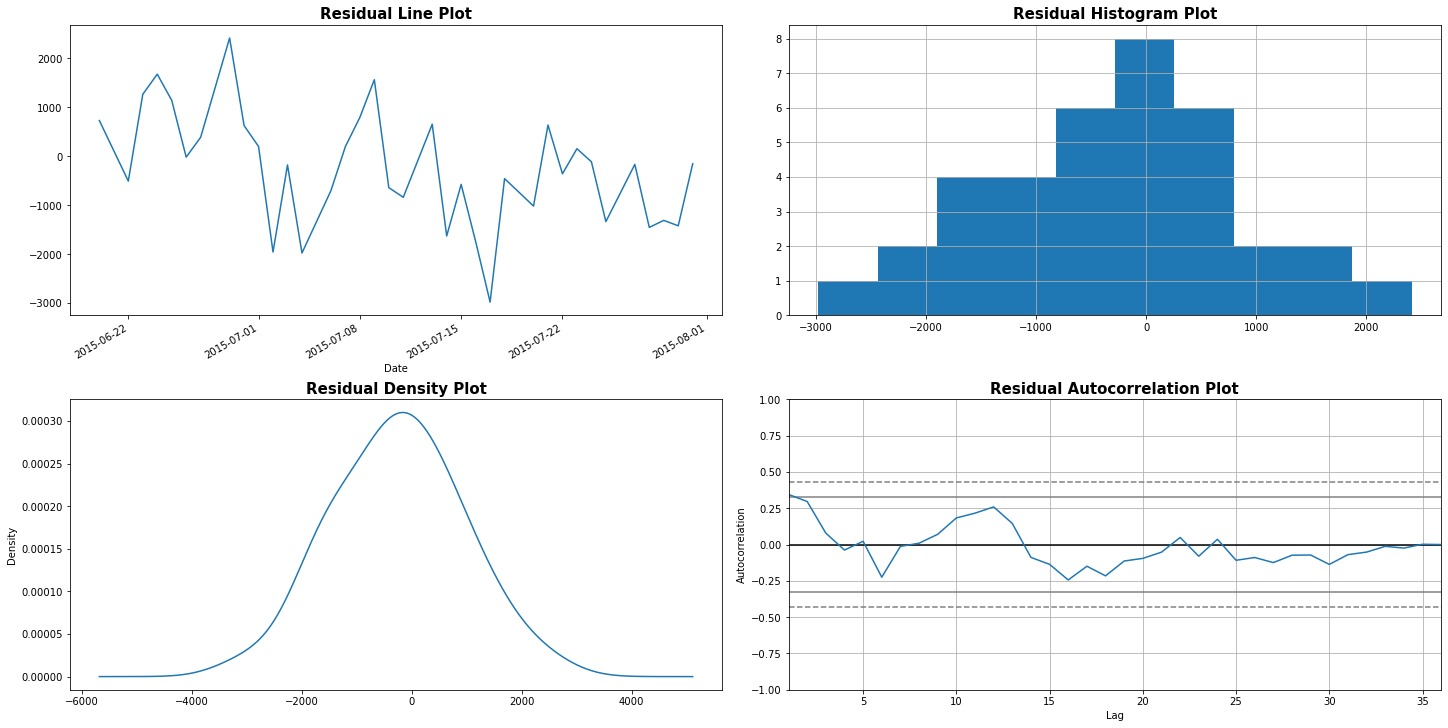

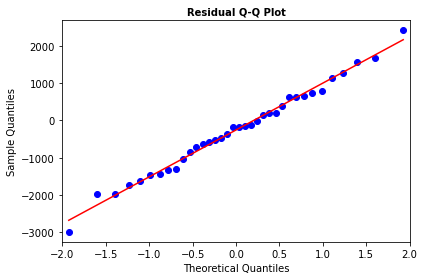

In [234]:
#Evaluation of the Best Model for Store 29.
evaluation('store29',best_model_store29)

##### Store 31

In [235]:
#Best Model to predict he sales for next 6 weeks for store 31.
best_model_store31 = store31_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 31")
best_model_store31

The Best fitted model for store 31


Method    RMSE  MAPE
0  SARIMAX Model  637.82  8.23

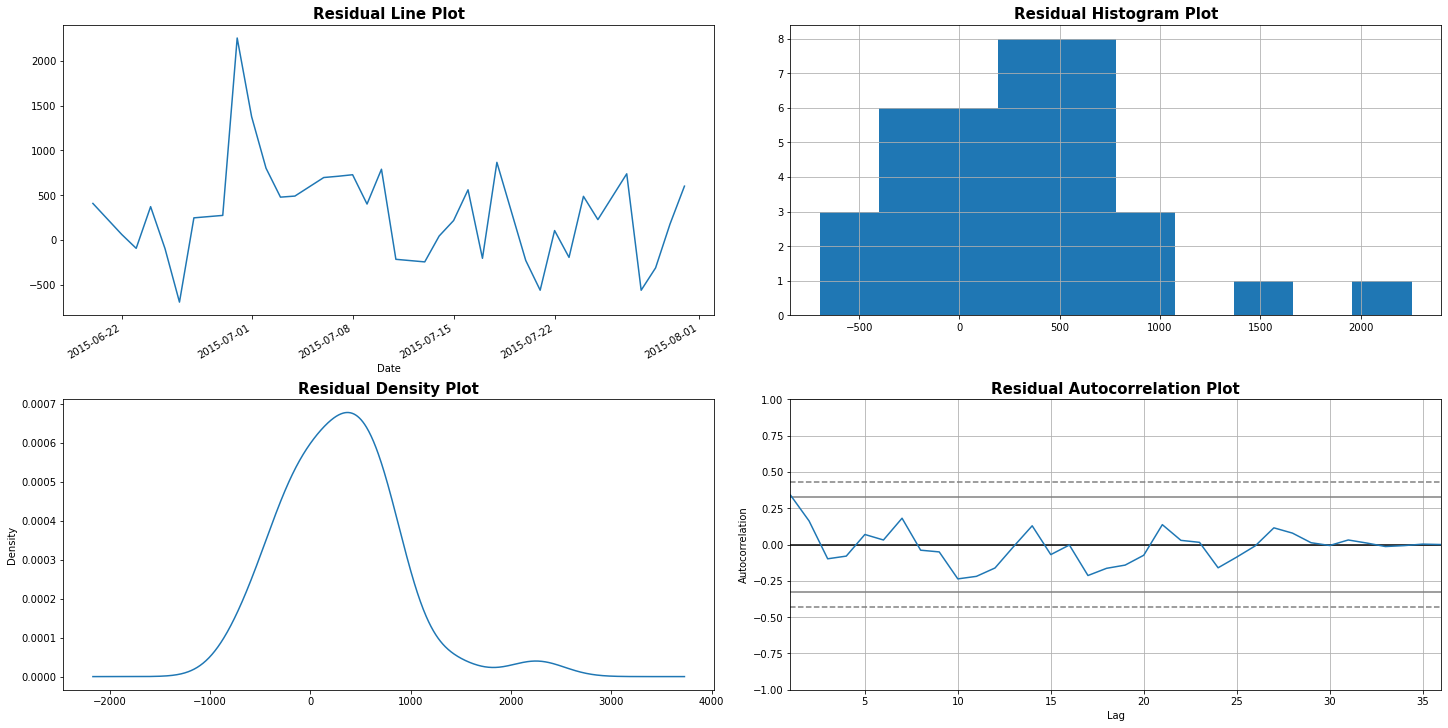

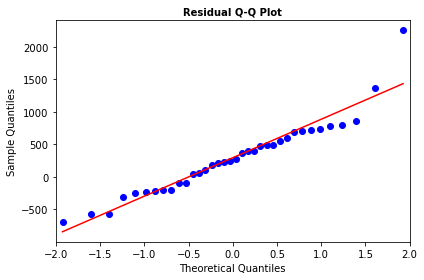

In [236]:
#Evaluation of the Best Model for Store 31.
evaluation('store31',best_model_store31)

##### Store 46

In [237]:
#Best Model to predict he sales for next 6 weeks for store 46.
best_model_store46 = store46_result.sort_values(by=['MAPE']).iloc[:1]
print(f"The Best fitted model for store 46")
best_model_store46

The Best fitted model for store 46


Method    RMSE   MAPE
0  SARIMAX Model  942.12  14.57

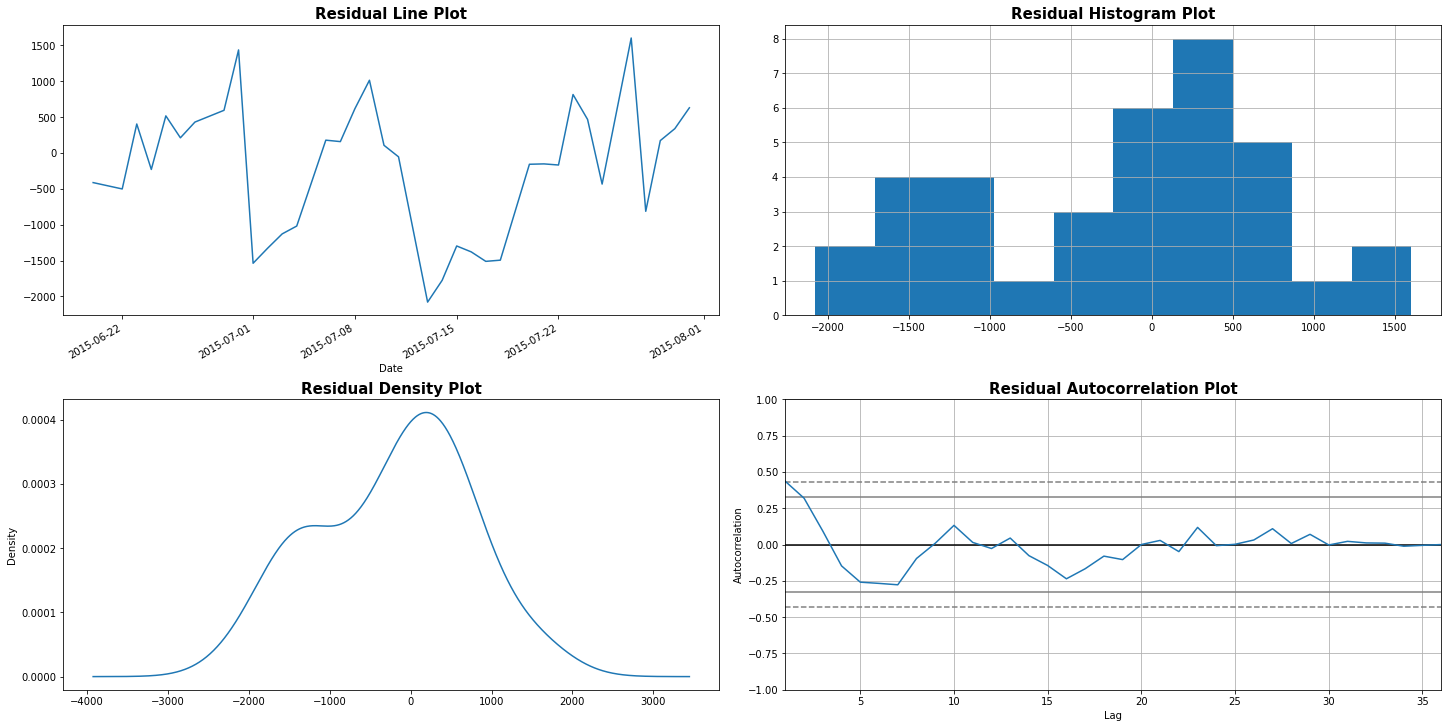

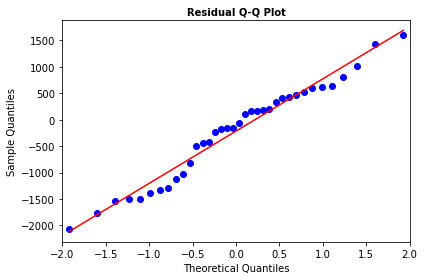

In [238]:
#Evaluation of the Best Model for Store 46.
evaluation('store46',best_model_store46)

### Submitted By: Kshitij Raj